In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff7 as ds
from copy import copy as dup
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from numba import int64
from numba import int32

#for 3d plots
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
#for 3d plots
import matplotlib.animation as animation

#for saving animations
import pickle

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Graphics parameters
%matplotlib widget
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
# These are run control parameters
""" Fliq is the QLL (shape: nx)
    Ntot is the the combined values of the ice layers (Nice), combined with the QLL layer (Nliq or Fliq or NQLL variously referred to as)
        Ntot is shaped (2, nx)
"""

noisy_init = False
noise_std_dev = 0.01

# Flag for explicit updating Fliq(Ntot) every step 
updatingFliq = True
# Set up a maximum number of iterations or layers
uselayers = True

if uselayers:
    layermax_0D = 4
    layermax_1D = 4
    layermax_2D = 2
else:
    countermax_0D = 100
    countermax_1D = 15000
    countermax_2D = 1000#15000

In [4]:
# File loading variables
lastfile = 'NeshData/continuum_model6 28-5-2016[1][1].npz'; Load_old_file = False
nextfile = 'NeshData/continuum_model6 28-5-2016[1][1].npz'; Save_new_file = False
trajfile = 'NeshData/continuum_model6 28-5-2016[1][1].traj.npz'; trajflag = False
traj0file= 'NeshData/continuum_model6 28-5-2016[1][1].traj0.npz'; traj0flag = False

In [5]:
#Setting up the system
# Number of iterations to calculate Nliq from Ntot (Increased niter means more iterative calculation: converges on greater accuracy at cost of time)
niter = 1

# Loading/initializing state
if Load_old_file:  #load an old system
    print("loading", lastfile)
    npzfile = np.load(lastfile)
    Fliq = npzfile['Fliq']
    Nice = npzfile['Nice']
    Nbar = npzfile['Nbar']
    Nstar = npzfile['Nstar']
    x = npzfile['x']
    nx = len(x)
    deltaX = x[1]-x[0]
else:
    #new system
    nx = 500 # Number of points in simulation box
    xmax = 50 # range of x
    x = np.linspace(0, xmax, nx)
    
    deltaX = x[1]-x[0]
    Nbar = 1.0 # new Nbar from VMD, 260K #this replaces Fliq at start in 0d model
    Nstar = .9/(2*np.pi)
    # Initialize as a pre-equilibrated layer of liquid over ice
    Nice = np.ones(nx)

    if noisy_init:
        # Initialize with noise
        noise = np.random.normal(0,noise_std_dev,nx)
        Nice += noise

    
    Fliq = ds.getNliq_array(Nice,Nstar,Nbar,niter)

# Lay out the system
Ntot = Fliq + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]
#Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const #NOTE: this is unused

In [6]:
#Time and diffusion parameters
# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 #-0.10 # Must be bigger than sigma0 to get growth, less than 0 for ablation
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax)
#sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid') 
# sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic')
# sigmastepstyle = 'parabolic'
# if sigmastepstyle=='sinusoid':
#     sigmastep = sigmastep_sinusoid
# elif sigmastepstyle=='parabolic':
#     sigmastep = sigmastep_parabolic
# else:
#     print('bad choice')

In [9]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltaT_max (Diffusion time)', dtmax)
print('deltaT =', deltaT)
print('deprate =', deprate, 'monolayers/us')
print('nmid', nmid)
print('N*', Nstar)
print('N*x2pi', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltaX', deltaX)
print('sigma_0 =', sigma0)
print('sigmastepmax =', sigmastepmax)
print('center reduction', center_reduction, '%')
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deltaT_max (Diffusion time) 50.20060160400962
deltaT = 1.0040120320801924
deprate = 0.16333333333333333 monolayers/us
nmid 250
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.10020040080160321
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 0.25 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


2.0
1.0040120320801924
breaking because reached max number of layers grown
0-D Modeled growth rate, um/s 1.8991811200036144
0-D Modeled growth rate, ml/us 0.006330603733345382
0-D Modeled alpha 0.1937939918371035


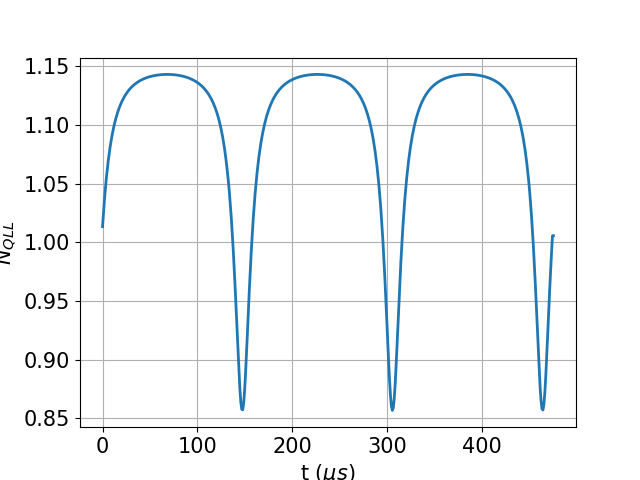

In [10]:
# This is the 0-d run
# Bundle parameters for ODE solver
params = np.array([Nbar, Nstar, sigmastepmax, sigma0, deprate])

print(Ntot[0])
y0 = [Nbar,0.0]#Ntot[0]] 
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltaT]

print(deltaT)

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,niter))
    ylast = list(y[1,:])
    tlast += deltaT
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to Fliq
    Fliqlast, Ntotlast = ylast

    if updatingFliq:
        Fliqlast = ds.getNliq(Ntotlast,Nstar,Nbar,niter) # This updates Fliqlast and ylast!
        ykeep_0D[counter][0] = Fliqlast # Saves the updated Fliq for this step
    Nicelast = Ntotlast - Fliqlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)

    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    # See whether to break
    if uselayers:
        if sigmastepmax > 0:
            if layer > layermax_0D-1:
                print('breaking because reached max number of layers grown')
                break
        else:
            if layer < -layermax_0D:
                print('breaking because reached max number of layers ablated')
                break 
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)
# Plot results
fignum +=1
plt.figure(fignum)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)


In [11]:
#Calculating number of expected steps to reach steady state
L = xmax/2; print(L) # micrometers
c_r = center_reduction / 100; print(c_r) # dimensionless
nu_kin_ml = deprate; print(nu_kin_ml) # monolayers per microsecond
sigma_I = sigmastepmax; print(sigma_I) # dimensionless
print(D) # D is in micrometers^2/microsecond
M = np.array([.0027, .0025])
B = np.array([2.9, 1.59])
beta = np.array([0.65, 0.65])
xfactor = nu_kin_ml*L**2*c_r**beta*sigma_I/D
NSS = M*xfactor + B
print('Nss predicted')
print('sinusoid:', NSS[0])
print('parabolic:', NSS[1])

25.0
0.0025
0.16333333333333333
0.2
0.0002
Nss predicted
sinusoid: 8.510216387742963
parabolic: 6.784644803465706


In [12]:
# This is the 1-d run
# Bundle parameters for ODE solver
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
int_params = np.array(list(map(int32,[niter,nx])))

# Initial conditions for ODE solver
y0 = np.array([Fliq,Ntot])
ylast = dup(y0)

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
Fliqkeep = [dup(Fliq)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
updatingFliq = True # seems to be neccesary for expected 1d model behavior
counter = 0
lastlayer = 0
lastdiff = 0

while True:
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(float_params,int_params,sigmastep),rtol=1e-12)

    ylast = np.reshape(y[1],(2,nx))
    tlast += deltaT
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = ds.getNliq_array(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltaT

    # Stuff into keeper arrays if requested
    if trajflag:
        Nicekeep.append(Nice)
        Ntotkeep.append(Ntot)
        Fliqkeep.append(Fliq)
        tkeep.append(ttot)

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
        
    # Test whether we're finished
    if uselayers:
        if sigmastepmax > 0:
            if layer > layermax_1D-1:
                print('breaking because reached max number of layers grown')
                break
        else:
            if layer < -layermax_1D:
                print('breaking because reached max number of layers ablated')
                break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

0 0 7.389127195001066e-06 7.389127195001066e-06
157 1 0.010700400454605852 0.01069301132741085
315 2 0.05286694191553343 0.042166541460927576
472 3 0.2177234655524547 0.16485652363692127
breaking because reached max number of layers grown


Height of Ice 0
1-D growth, corner 3.0001750034744816
1-D growth, center 2.661376031935659
1-D Modeled growth rate, corner, um/s 1.8952555840341976
1-D Modeled growth rate, corner, ml/us 0.006317518613447325
1-D Modeled growth rate, center, um/s 1.6812311881471669
1-D Modeled alpha, corner 0.19340880637594704
1-D Modeled alpha, center 0.17198416154929141
Difference, % -11.077388474757717
0-D Modeled growth rate, um/s 1.8991811200036144
0-D Modeled growth rate, ml/us 0.006330603733345382
0-D Modeled alpha 0.1937939918371035
Growth ratio 1D (corner)/0D 0.9979330375981152
Growth ratio 1D (center)/0D 0.8852400492186692
Contribution of diffusion -11.47599507813308 %
Libbrecht's predicted growth rate, um/s 1.8393582063217946
Libbrecht's predicted alpha 0.18768961288997904
Time taken: 0 min 0.0027892589569091797 secs


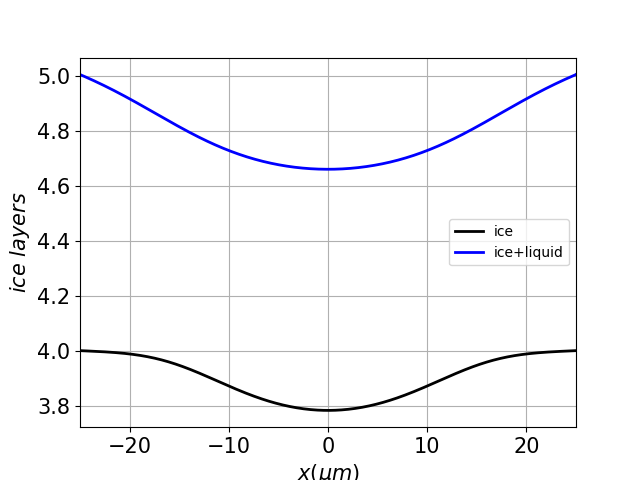

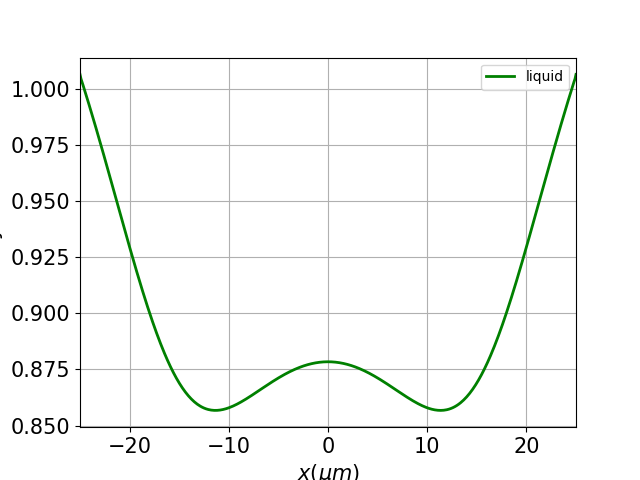

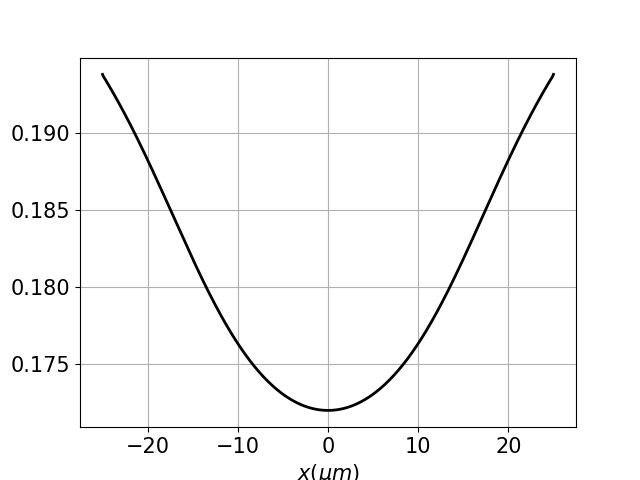

In [16]:
# Growth statistics
sec1 = time.time()

# minpoint = min(Nice)
minpoint = 0
ncorner = 4
print("Height of Ice", minpoint)
delta_Ntot_entire = Ntot-Ntotkeep[0]
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus)
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])
alpha = growthrate_entire/nu_kin/sigmastep
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)


# Comparisons with 0-D model
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d/umpersec_over_mlyperus)
print( "0-D Modeled alpha", alpha_0d)
print( "Growth ratio 1D (corner)/0D", growthrate_entire[ncorner]/growthrate_0d)
print( "Growth ratio 1D (center)/0D", growthrate_entire[nmid]/growthrate_0d)
print( "Contribution of diffusion", (growthrate_entire[nmid]-growthrate_0d)/growthrate_0d*100, '%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
print("Libbrecht's predicted alpha", alpha_L)

# Timing statistics
sec2 = time.time()
print("Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs")

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Fliq+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Fliq, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, alpha, 'k', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ \alpha $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')

0.25
0.2025
0.19750002008024065


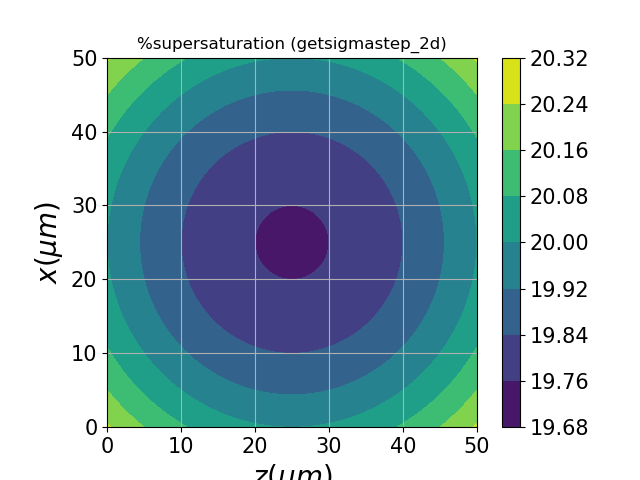

In [27]:
#Setting up the 2D system

nx = 500 # Number of points in simulation box
xmax = 50 # range of x
x = np.linspace(0, xmax, nx)

ny = nx
ymax = xmax
y = np.linspace(0, ymax, ny)

deltaX = x[1]-x[0]
deltaY = y[1]-y[0]

Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
# Initialize as a pre-equilibrated layer of liquid over ice

Nice = np.ones((nx,ny))

if noisy_init:
    # Initialize with noise
    noise = np.random.normal(0,noise_std_dev,(nx,ny))
    Nice += noise

Fliq = ds.getNliq_2d_array(Nice,Nstar,Nbar,niter)
print(center_reduction)
sigmastep_2d = ds.getsigmastep_2d(x,y,center_reduction/100,sigmastepmax)


# Examine results from getsigmastep_2d as a grid
print(np.max(sigmastep_2d))
print(np.min(sigmastep_2d))
fig,ax = plt.subplots()
CS = ax.contourf(x,y,sigmastep_2d*100)
ax.set_xlabel(r'$z (\mu m)$', fontsize=20)
ax.set_ylabel(r'$x (\mu m)$', fontsize=20)
plt.grid(True)
plt.gca().set_aspect('equal')
fig.colorbar(CS)
plt.title('%supersaturation (getsigmastep_2d)')


# Lay out the system
Ntot = Fliq + Nice
# nmid = int(nx/2)
# nquart = int(nx/4)
# xmid = max(x)/2
# xmax = x[nx-1]
Nice_start = Nice[0]

#Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const #NOTE: this is unused

In [28]:
# This is the 2-d run using odeint

# Bundle parameters for ODE solver
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
int_params = np.array(list(map(int64,[niter,nx,ny]))) # functions in ds7 require int64

# Initial conditions for ODE solver
y0 = np.array([Fliq,Ntot])
ylast = dup(y0)

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
Fliqkeep = [dup(Fliq)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0,0]
Nice0 = Nice[0,0]
Ntot0_start = Ntot[0,0]
Ntot0 = Ntot[0,0]
updatingFliq = False#True
counter = 0
lastlayer = 0
lastdiff = 0
while True:
    # Integrate up to next time step
    y = odeint(ds.f2d, np.reshape(ylast,np.prod(np.shape(ylast))), tinterval, args=(float_params,int_params,sigmastep_2d),rtol=1e-12)
    # Update the state                  #NOTE: prod(shape(ylast)) is like (2*nx*ny)
    ylast = np.reshape(y[1],(2,nx,ny))
    #ylast = np.reshape(y.y,(2,nx,ny))

    tlast += deltaT
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = ds.getNliq_2d_array(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq

    Nice0 = Nice[0,0]
    Ntot0 = Ntot[0,0]
    ttot += deltaT

    # Stuff into keeper arrays for making graphics
    Nicekeep.append(Nice)
    Ntotkeep.append(Ntot)
    Fliqkeep.append(Fliq)
    tkeep.append(ttot)

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = np.min(Nice)
        maxpoint = np.max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
        
    # Test whether we're finished
    if uselayers:
        print("appx progress:" , round((layer/(layermax_2D-1))*100, 2),"%",end="\r")
        if sigmastepmax > 0:
            if layer > layermax_2D-1:
                print('breaking because reached max number of layers grown')
                break
        else:
            if layer < -layermax_2D:
                print('breaking because reached max number of layers ablated')
                break
    else:
        if counter > countermax_2D-1:
            print('breaking because reached max number of iterations')
            break

depsurf quartersection:  [[0.01603501 0.01603202 0.01602905 ... 0.01566214 0.01566211 0.0156621 ]
 [0.01603202 0.01602904 0.01602607 ... 0.01565915 0.01565913 0.01565912]
 [0.01602905 0.01602607 0.0160231  ... 0.01565618 0.01565616 0.01565615]
 ...
 [0.01566214 0.01565915 0.01565618 ... 0.01528927 0.01528924 0.01528923]
 [0.01566211 0.01565913 0.01565616 ... 0.01528924 0.01528922 0.01528921]
 [0.0156621  0.01565912 0.01565615 ... 0.01528923 0.01528921 0.0152892 ]]
depsurf quartersection:  [[0.01603501 0.01603202 0.01602905 ... 0.01566214 0.01566211 0.0156621 ]
 [0.01603202 0.01602904 0.01602607 ... 0.01565915 0.01565913 0.01565912]
 [0.01602905 0.01602607 0.0160231  ... 0.01565618 0.01565616 0.01565615]
 ...
 [0.01566214 0.01565915 0.01565618 ... 0.01528927 0.01528924 0.01528923]
 [0.01566211 0.01565913 0.01565616 ... 0.01528924 0.01528922 0.01528921]
 [0.0156621  0.01565912 0.01565615 ... 0.01528923 0.01528921 0.01528919]]
depsurf quartersection:  [[0.016035   0.01603202 0.01602905 ..

depsurf quartersection:  [[0.01449377 0.0144911  0.01448843 ... 0.01415931 0.01415929 0.01415928]
 [0.0144911  0.01448842 0.01448575 ... 0.01415664 0.01415661 0.0141566 ]
 [0.01448843 0.01448575 0.01448309 ... 0.01415397 0.01415395 0.01415394]
 ...
 [0.01415931 0.01415664 0.01415397 ... 0.01382474 0.01382472 0.0138247 ]
 [0.01415929 0.01415661 0.01415395 ... 0.01382472 0.01382469 0.01382468]
 [0.01415928 0.0141566  0.01415394 ... 0.0138247  0.01382468 0.01382467]]
depsurf quartersection:  [[0.01449378 0.0144911  0.01448844 ... 0.01415932 0.0141593  0.01415929]
 [0.0144911  0.01448842 0.01448576 ... 0.01415664 0.01415662 0.01415661]
 [0.01448844 0.01448576 0.01448309 ... 0.01415397 0.01415395 0.01415394]
 ...
 [0.01415932 0.01415664 0.01415397 ... 0.01382474 0.01382472 0.01382471]
 [0.0141593  0.01415662 0.01415395 ... 0.01382472 0.0138247  0.01382469]
 [0.01415929 0.01415661 0.01415394 ... 0.01382471 0.01382469 0.01382468]]
0 0 7.390963683118201e-05 7.390963683118201e-05
depsurf quarte

depsurf quartersection:  [[0.01311965 0.01311723 0.01311483 ... 0.01281817 0.01281815 0.01281814]
 [0.01311723 0.01311481 0.01311241 ... 0.01281575 0.01281573 0.01281572]
 [0.01311483 0.01311241 0.01311    ... 0.01281334 0.01281332 0.01281331]
 ...
 [0.01281817 0.01281575 0.01281334 ... 0.01251654 0.01251652 0.01251651]
 [0.01281815 0.01281573 0.01281332 ... 0.01251652 0.0125165  0.01251649]
 [0.01281814 0.01281572 0.01281331 ... 0.01251651 0.01251649 0.01251648]]
depsurf quartersection:  [[0.01311966 0.01311723 0.01311483 ... 0.01281817 0.01281815 0.01281814]
 [0.01311723 0.01311481 0.01311241 ... 0.01281575 0.01281573 0.01281572]
 [0.01311483 0.01311241 0.01311001 ... 0.01281335 0.01281333 0.01281332]
 ...
 [0.01281817 0.01281575 0.01281335 ... 0.01251654 0.01251652 0.01251651]
 [0.01281815 0.01281573 0.01281333 ... 0.01251652 0.0125165  0.01251649]
 [0.01281814 0.01281572 0.01281332 ... 0.01251651 0.01251649 0.01251648]]
depsurf quartersection:  [[0.01323338 0.01323093 0.01322851 ..

depsurf quartersection:  [[0.01189915 0.01189694 0.01189476 ... 0.01162559 0.01162557 0.01162556]
 [0.01189694 0.01189473 0.01189255 ... 0.01162338 0.01162336 0.01162335]
 [0.01189476 0.01189255 0.01189037 ... 0.0116212  0.01162118 0.01162117]
 ...
 [0.01162559 0.01162338 0.0116212  ... 0.01135193 0.01135192 0.01135191]
 [0.01162557 0.01162336 0.01162118 ... 0.01135192 0.0113519  0.01135189]
 [0.01162556 0.01162335 0.01162117 ... 0.01135191 0.01135189 0.01135188]]
depsurf quartersection:  [[0.0120691  0.01206686 0.01206465 ... 0.01179174 0.01179172 0.01179171]
 [0.01206686 0.01206462 0.01206241 ... 0.0117895  0.01178948 0.01178947]
 [0.01206465 0.01206241 0.0120602  ... 0.01178729 0.01178727 0.01178726]
 ...
 [0.01179174 0.0117895  0.01178729 ... 0.01151427 0.01151425 0.01151424]
 [0.01179172 0.01178948 0.01178727 ... 0.01151425 0.01151423 0.01151423]
 [0.01179171 0.01178947 0.01178726 ... 0.01151424 0.01151423 0.01151422]]
depsurf quartersection:  [[0.0120691  0.01206686 0.01206465 ..

depsurf quartersection:  [[0.01104015 0.01103808 0.01103604 ... 0.01078529 0.01078528 0.01078527]
 [0.01103808 0.01103601 0.01103397 ... 0.01078322 0.01078321 0.0107832 ]
 [0.01103604 0.01103397 0.01103194 ... 0.01078119 0.01078118 0.01078117]
 ...
 [0.01078529 0.01078322 0.01078119 ... 0.01053045 0.01053043 0.01053042]
 [0.01078528 0.01078321 0.01078118 ... 0.01053043 0.01053041 0.0105304 ]
 [0.01078527 0.0107832  0.01078117 ... 0.01053042 0.0105304  0.0105304 ]]
depsurf quartersection:  [[0.01104015 0.01103808 0.01103604 ... 0.01078529 0.01078528 0.01078527]
 [0.01103808 0.01103601 0.01103397 ... 0.01078322 0.01078321 0.0107832 ]
 [0.01103604 0.01103397 0.01103194 ... 0.01078119 0.01078118 0.01078117]
 ...
 [0.01078529 0.01078322 0.01078119 ... 0.01053044 0.01053043 0.01053042]
 [0.01078528 0.01078321 0.01078118 ... 0.01053043 0.01053041 0.0105304 ]
 [0.01078527 0.0107832  0.01078117 ... 0.01053042 0.0105304  0.0105304 ]]
depsurf quartersection:  [[0.01104014 0.01103807 0.01103604 ..

depsurf quartersection:  [[0.00984877 0.00984688 0.00984504 ... 0.00961834 0.00961832 0.00961831]
 [0.00984688 0.00984499 0.00984315 ... 0.00961645 0.00961643 0.00961642]
 [0.00984504 0.00984315 0.00984131 ... 0.00961461 0.00961459 0.00961459]
 ...
 [0.00961834 0.00961645 0.00961461 ... 0.00938814 0.00938812 0.00938811]
 [0.00961832 0.00961643 0.00961459 ... 0.00938812 0.00938811 0.0093881 ]
 [0.00961831 0.00961642 0.00961459 ... 0.00938811 0.0093881  0.00938809]]
depsurf quartersection:  [[0.01013026 0.01012833 0.01012644 ... 0.00989423 0.00989422 0.00989421]
 [0.01012833 0.01012639 0.01012451 ... 0.0098923  0.00989228 0.00989228]
 [0.01012644 0.01012451 0.01012263 ... 0.00989042 0.0098904  0.0098904 ]
 ...
 [0.00989423 0.0098923  0.00989042 ... 0.00965837 0.00965836 0.00965835]
 [0.00989422 0.00989228 0.0098904  ... 0.00965836 0.00965834 0.00965833]
 [0.00989421 0.00989228 0.0098904  ... 0.00965835 0.00965833 0.00965833]]
depsurf quartersection:  [[0.01013026 0.01012833 0.01012644 ..

depsurf quartersection:  [[0.00897866 0.00897689 0.00897518 ... 0.00876476 0.00876475 0.00876474]
 [0.00897689 0.00897511 0.0089734  ... 0.00876299 0.00876298 0.00876297]
 [0.00897518 0.0089734  0.00897169 ... 0.00876129 0.00876127 0.00876127]
 ...
 [0.00876476 0.00876299 0.00876129 ... 0.00855135 0.00855134 0.00855133]
 [0.00876475 0.00876298 0.00876127 ... 0.00855134 0.00855132 0.00855132]
 [0.00876474 0.00876297 0.00876127 ... 0.00855133 0.00855132 0.00855131]]
depsurf quartersection:  [[0.00897866 0.00897689 0.00897518 ... 0.00876477 0.00876475 0.00876474]
 [0.00897689 0.00897511 0.0089734  ... 0.00876299 0.00876298 0.00876297]
 [0.00897518 0.0089734  0.0089717  ... 0.00876129 0.00876127 0.00876127]
 ...
 [0.00876477 0.00876299 0.00876129 ... 0.00855135 0.00855134 0.00855133]
 [0.00876475 0.00876298 0.00876127 ... 0.00855134 0.00855132 0.00855132]
 [0.00876474 0.00876297 0.00876127 ... 0.00855133 0.00855132 0.00855131]]
depsurf quartersection:  [[0.00932451 0.00932269 0.00932093 ..

depsurf quartersection:  [[0.00860958 0.00860785 0.00860619 ... 0.00840232 0.00840231 0.0084023 ]
 [0.00860785 0.00860612 0.00860446 ... 0.00840059 0.00840058 0.00840057]
 [0.00860619 0.00860446 0.00860281 ... 0.00839894 0.00839893 0.00839892]
 ...
 [0.00840232 0.00840059 0.00839894 ... 0.00819568 0.00819567 0.00819566]
 [0.00840231 0.00840058 0.00839893 ... 0.00819567 0.00819565 0.00819565]
 [0.0084023  0.00840057 0.00839892 ... 0.00819566 0.00819565 0.00819564]]
depsurf quartersection:  [[0.00860958 0.00860785 0.00860619 ... 0.00840232 0.00840231 0.0084023 ]
 [0.00860785 0.00860612 0.00860446 ... 0.00840059 0.00840058 0.00840057]
 [0.00860619 0.00860446 0.0086028  ... 0.00839894 0.00839893 0.00839892]
 ...
 [0.00840232 0.00840059 0.00839894 ... 0.00819568 0.00819566 0.00819566]
 [0.00840231 0.00840058 0.00839893 ... 0.00819566 0.00819565 0.00819565]
 [0.0084023  0.00840057 0.00839892 ... 0.00819566 0.00819565 0.00819564]]
depsurf quartersection:  [[0.00860958 0.00860785 0.00860619 ..

depsurf quartersection:  [[0.00797375 0.00797209 0.00797052 ... 0.00777735 0.00777734 0.00777733]
 [0.00797209 0.00797043 0.00796886 ... 0.0077757  0.00777569 0.00777568]
 [0.00797052 0.00796886 0.00796729 ... 0.00777414 0.00777412 0.00777412]
 ...
 [0.00777735 0.0077757  0.00777414 ... 0.00758184 0.00758183 0.00758182]
 [0.00777734 0.00777569 0.00777412 ... 0.00758183 0.00758182 0.00758181]
 [0.00777733 0.00777568 0.00777412 ... 0.00758182 0.00758181 0.00758181]]
depsurf quartersection:  [[0.00797375 0.00797209 0.00797052 ... 0.00777735 0.00777734 0.00777733]
 [0.00797209 0.00797043 0.00796886 ... 0.0077757  0.00777569 0.00777568]
 [0.00797052 0.00796886 0.00796729 ... 0.00777414 0.00777412 0.00777412]
 ...
 [0.00777735 0.0077757  0.00777414 ... 0.00758184 0.00758183 0.00758182]
 [0.00777734 0.00777569 0.00777412 ... 0.00758183 0.00758182 0.00758181]
 [0.00777733 0.00777568 0.00777412 ... 0.00758182 0.00758181 0.0075818 ]]
depsurf quartersection:  [[0.00797375 0.00797209 0.00797052 ..

depsurf quartersection:  [[0.00740684 0.00740524 0.00740373 ... 0.00721945 0.00721944 0.00721944]
 [0.00740524 0.00740364 0.00740213 ... 0.00721786 0.00721785 0.00721785]
 [0.00740373 0.00740213 0.00740063 ... 0.00721637 0.00721636 0.00721635]
 ...
 [0.00721945 0.00721786 0.00721637 ... 0.00703325 0.00703323 0.00703323]
 [0.00721944 0.00721785 0.00721636 ... 0.00703323 0.00703322 0.00703322]
 [0.00721944 0.00721785 0.00721635 ... 0.00703323 0.00703322 0.00703321]]
depsurf quartersection:  [[0.00740684 0.00740524 0.00740373 ... 0.00721945 0.00721944 0.00721944]
 [0.00740524 0.00740363 0.00740213 ... 0.00721786 0.00721785 0.00721784]
 [0.00740373 0.00740213 0.00740063 ... 0.00721637 0.00721636 0.00721635]
 ...
 [0.00721945 0.00721786 0.00721637 ... 0.00703325 0.00703323 0.00703323]
 [0.00721944 0.00721785 0.00721636 ... 0.00703323 0.00703322 0.00703322]
 [0.00721944 0.00721784 0.00721635 ... 0.00703323 0.00703322 0.00703321]]
depsurf quartersection:  [[0.00740148 0.00739988 0.00739838 ..

depsurf quartersection:  [[0.00689524 0.00689369 0.00689224 ... 0.00671539 0.00671538 0.00671537]
 [0.00689369 0.00689213 0.00689069 ... 0.00671385 0.00671384 0.00671383]
 [0.00689224 0.00689069 0.00688925 ... 0.00671242 0.0067124  0.0067124 ]
 ...
 [0.00671539 0.00671385 0.00671242 ... 0.00653702 0.00653701 0.006537  ]
 [0.00671538 0.00671384 0.0067124  ... 0.00653701 0.006537   0.00653699]
 [0.00671537 0.00671383 0.0067124  ... 0.006537   0.00653699 0.00653699]]
depsurf quartersection:  [[0.00689524 0.00689369 0.00689224 ... 0.00671539 0.00671538 0.00671537]
 [0.00689369 0.00689213 0.00689069 ... 0.00671385 0.00671384 0.00671383]
 [0.00689224 0.00689069 0.00688925 ... 0.00671242 0.0067124  0.0067124 ]
 ...
 [0.00671539 0.00671385 0.00671242 ... 0.00653702 0.00653701 0.006537  ]
 [0.00671538 0.00671384 0.0067124  ... 0.00653701 0.006537   0.00653699]
 [0.00671537 0.00671383 0.0067124  ... 0.006537   0.00653699 0.00653699]]
depsurf quartersection:  [[0.00689046 0.0068889  0.00688746 ..

depsurf quartersection:  [[0.00643716 0.00643564 0.00643424 ... 0.00626351 0.0062635  0.00626349]
 [0.00643564 0.00643412 0.00643272 ... 0.006262   0.00626199 0.00626199]
 [0.00643424 0.00643272 0.00643133 ... 0.00626062 0.00626061 0.0062606 ]
 ...
 [0.00626351 0.006262   0.00626062 ... 0.00609166 0.00609165 0.00609164]
 [0.0062635  0.00626199 0.00626061 ... 0.00609165 0.00609164 0.00609163]
 [0.00626349 0.00626199 0.0062606  ... 0.00609164 0.00609163 0.00609163]]
depsurf quartersection:  [[0.00643287 0.00643135 0.00642995 ... 0.00625927 0.00625926 0.00625926]
 [0.00643135 0.00642983 0.00642843 ... 0.00625777 0.00625776 0.00625775]
 [0.00642995 0.00642843 0.00642704 ... 0.00625638 0.00625637 0.00625637]
 ...
 [0.00625927 0.00625777 0.00625638 ... 0.00608748 0.00608747 0.00608747]
 [0.00625926 0.00625776 0.00625637 ... 0.00608747 0.00608746 0.00608746]
 [0.00625926 0.00625775 0.00625637 ... 0.00608747 0.00608746 0.00608745]]
depsurf quartersection:  [[0.00643287 0.00643135 0.00642995 ..

depsurf quartersection:  [[0.00602587 0.00602438 0.00602302 ... 0.0058573  0.00585729 0.00585728]
 [0.00602438 0.00602288 0.00602152 ... 0.00585582 0.00585581 0.00585581]
 [0.00602302 0.00602152 0.00602016 ... 0.00585448 0.00585447 0.00585446]
 ...
 [0.0058573  0.00585582 0.00585448 ... 0.00569087 0.00569086 0.00569085]
 [0.00585729 0.00585581 0.00585447 ... 0.00569086 0.00569085 0.00569084]
 [0.00585728 0.00585581 0.00585446 ... 0.00569085 0.00569084 0.00569083]]
depsurf quartersection:  [[0.00598746 0.00598597 0.00598462 ... 0.00581934 0.00581933 0.00581933]
 [0.00598597 0.00598449 0.00598313 ... 0.00581787 0.00581786 0.00581785]
 [0.00598462 0.00598313 0.00598177 ... 0.00581653 0.00581652 0.00581652]
 ...
 [0.00581934 0.00581787 0.00581653 ... 0.0056534  0.00565338 0.00565338]
 [0.00581933 0.00581786 0.00581652 ... 0.00565338 0.00565337 0.00565337]
 [0.00581933 0.00581785 0.00581652 ... 0.00565338 0.00565337 0.00565336]]
depsurf quartersection:  [[0.00598746 0.00598597 0.00598462 ..

depsurf quartersection:  [[0.00559011 0.00558864 0.00558732 ... 0.00542636 0.00542635 0.00542634]
 [0.00558864 0.00558718 0.00558585 ... 0.00542491 0.0054249  0.00542489]
 [0.00558732 0.00558585 0.00558453 ... 0.00542361 0.0054236  0.00542359]
 ...
 [0.00542636 0.00542491 0.00542361 ... 0.00526516 0.00526515 0.00526515]
 [0.00542635 0.0054249  0.0054236  ... 0.00526515 0.00526514 0.00526514]
 [0.00542634 0.00542489 0.00542359 ... 0.00526515 0.00526514 0.00526513]]
depsurf quartersection:  [[0.00559011 0.00558864 0.00558732 ... 0.00542636 0.00542635 0.00542634]
 [0.00558864 0.00558718 0.00558585 ... 0.00542491 0.0054249  0.00542489]
 [0.00558732 0.00558585 0.00558453 ... 0.00542361 0.0054236  0.00542359]
 ...
 [0.00542636 0.00542491 0.00542361 ... 0.00526516 0.00526515 0.00526515]
 [0.00542635 0.0054249  0.0054236  ... 0.00526515 0.00526514 0.00526514]
 [0.00542634 0.00542489 0.00542359 ... 0.00526515 0.00526514 0.00526513]]
depsurf quartersection:  [[0.00555615 0.00555468 0.00555336 ..

depsurf quartersection:  [[0.00523454 0.00523308 0.00523178 ... 0.00507422 0.00507421 0.00507421]
 [0.00523308 0.00523163 0.00523033 ... 0.00507279 0.00507278 0.00507278]
 [0.00523178 0.00523033 0.00522903 ... 0.00507151 0.0050715  0.0050715 ]
 ...
 [0.00507422 0.00507279 0.00507151 ... 0.00491686 0.00491685 0.00491685]
 [0.00507421 0.00507278 0.0050715  ... 0.00491685 0.00491684 0.00491684]
 [0.00507421 0.00507278 0.0050715  ... 0.00491685 0.00491684 0.00491683]]
depsurf quartersection:  [[0.00523454 0.00523308 0.00523178 ... 0.00507422 0.00507421 0.00507421]
 [0.00523308 0.00523163 0.00523033 ... 0.00507279 0.00507278 0.00507278]
 [0.00523178 0.00523033 0.00522903 ... 0.00507151 0.0050715  0.0050715 ]
 ...
 [0.00507422 0.00507279 0.00507151 ... 0.00491686 0.00491685 0.00491685]
 [0.00507421 0.00507278 0.0050715  ... 0.00491685 0.00491684 0.00491684]
 [0.00507421 0.00507278 0.0050715  ... 0.00491685 0.00491684 0.00491683]]
depsurf quartersection:  [[0.00520409 0.00520264 0.00520134 ..

depsurf quartersection:  [[0.00472229 0.00472084 0.00471957 ... 0.00456601 0.004566   0.004566  ]
 [0.00472084 0.0047194  0.00471813 ... 0.0045646  0.00456459 0.00456458]
 [0.00471957 0.00471813 0.00471685 ... 0.00456335 0.00456334 0.00456334]
 ...
 [0.00456601 0.0045646  0.00456335 ... 0.00441339 0.00441338 0.00441337]
 [0.004566   0.00456459 0.00456334 ... 0.00441338 0.00441337 0.00441336]
 [0.004566   0.00456458 0.00456334 ... 0.00441337 0.00441336 0.00441336]]
depsurf quartersection:  [[0.00472229 0.00472085 0.00471957 ... 0.00456602 0.00456601 0.004566  ]
 [0.00472085 0.0047194  0.00471813 ... 0.0045646  0.00456459 0.00456459]
 [0.00471957 0.00471813 0.00471686 ... 0.00456336 0.00456335 0.00456334]
 ...
 [0.00456602 0.0045646  0.00456336 ... 0.00441339 0.00441338 0.00441337]
 [0.00456601 0.00456459 0.00456335 ... 0.00441338 0.00441337 0.00441336]
 [0.004566   0.00456459 0.00456334 ... 0.00441337 0.00441336 0.00441336]]
depsurf quartersection:  [[0.00476284 0.00476139 0.00476012 ..

depsurf quartersection:  [[0.00451418 0.00451274 0.00451147 ... 0.00435918 0.00435917 0.00435917]
 [0.00451274 0.00451129 0.00451003 ... 0.00435777 0.00435776 0.00435775]
 [0.00451147 0.00451003 0.00450876 ... 0.00435653 0.00435652 0.00435652]
 ...
 [0.00435918 0.00435777 0.00435653 ... 0.00420817 0.00420816 0.00420815]
 [0.00435917 0.00435776 0.00435652 ... 0.00420816 0.00420815 0.00420814]
 [0.00435917 0.00435775 0.00435652 ... 0.00420815 0.00420814 0.00420814]]
depsurf quartersection:  [[0.00451418 0.00451274 0.00451147 ... 0.00435918 0.00435917 0.00435917]
 [0.00451274 0.00451129 0.00451003 ... 0.00435777 0.00435776 0.00435775]
 [0.00451147 0.00451003 0.00450876 ... 0.00435653 0.00435652 0.00435652]
 ...
 [0.00435918 0.00435777 0.00435653 ... 0.00420817 0.00420816 0.00420815]
 [0.00435917 0.00435776 0.00435652 ... 0.00420816 0.00420815 0.00420814]
 [0.00435917 0.00435775 0.00435652 ... 0.00420815 0.00420814 0.00420814]]
depsurf quartersection:  [[0.00451418 0.00451273 0.00451147 ..

depsurf quartersection:  [[0.00428744 0.00428599 0.00428473 ... 0.00413355 0.00413354 0.00413353]
 [0.00428599 0.00428455 0.00428329 ... 0.00413214 0.00413213 0.00413212]
 [0.00428473 0.00428329 0.00428202 ... 0.00413091 0.0041309  0.00413089]
 ...
 [0.00413355 0.00413214 0.00413091 ... 0.00398405 0.00398404 0.00398404]
 [0.00413354 0.00413213 0.0041309  ... 0.00398404 0.00398404 0.00398403]
 [0.00413353 0.00413212 0.00413089 ... 0.00398404 0.00398403 0.00398403]]
depsurf quartersection:  [[0.00428744 0.00428599 0.00428473 ... 0.00413355 0.00413354 0.00413353]
 [0.00428599 0.00428455 0.00428329 ... 0.00413214 0.00413213 0.00413212]
 [0.00428473 0.00428329 0.00428202 ... 0.00413091 0.0041309  0.00413089]
 ...
 [0.00413355 0.00413214 0.00413091 ... 0.00398405 0.00398404 0.00398404]
 [0.00413354 0.00413213 0.0041309  ... 0.00398404 0.00398404 0.00398403]
 [0.00413353 0.00413212 0.00413089 ... 0.00398404 0.00398403 0.00398403]]
depsurf quartersection:  [[0.00428744 0.00428599 0.00428473 ..

depsurf quartersection:  [[0.00408025 0.0040788  0.00407754 ... 0.00392708 0.00392707 0.00392707]
 [0.0040788  0.00407735 0.00407609 ... 0.00392567 0.00392566 0.00392566]
 [0.00407754 0.00407609 0.00407484 ... 0.00392445 0.00392444 0.00392444]
 ...
 [0.00392708 0.00392567 0.00392445 ... 0.00377874 0.00377873 0.00377872]
 [0.00392707 0.00392566 0.00392444 ... 0.00377873 0.00377872 0.00377871]
 [0.00392707 0.00392566 0.00392444 ... 0.00377872 0.00377871 0.00377871]]
depsurf quartersection:  [[0.00408025 0.0040788  0.00407754 ... 0.00392708 0.00392707 0.00392707]
 [0.0040788  0.00407735 0.00407609 ... 0.00392567 0.00392566 0.00392566]
 [0.00407754 0.00407609 0.00407484 ... 0.00392445 0.00392444 0.00392444]
 ...
 [0.00392708 0.00392567 0.00392445 ... 0.00377874 0.00377873 0.00377872]
 [0.00392707 0.00392566 0.00392444 ... 0.00377873 0.00377872 0.00377871]
 [0.00392707 0.00392566 0.00392444 ... 0.00377872 0.00377871 0.00377871]]
depsurf quartersection:  [[0.00407827 0.00407682 0.00407556 ..

depsurf quartersection:  [[0.00389058 0.00388912 0.00388786 ... 0.00373778 0.00373777 0.00373776]
 [0.00388912 0.00388766 0.0038864  ... 0.00373636 0.00373635 0.00373635]
 [0.00388786 0.0038864  0.00388514 ... 0.00373514 0.00373513 0.00373513]
 ...
 [0.00373778 0.00373636 0.00373514 ... 0.00359025 0.00359024 0.00359024]
 [0.00373777 0.00373635 0.00373513 ... 0.00359024 0.00359023 0.00359023]
 [0.00373776 0.00373635 0.00373513 ... 0.00359024 0.00359023 0.00359022]]
depsurf quartersection:  [[0.00388876 0.0038873  0.00388604 ... 0.00373597 0.00373596 0.00373595]
 [0.0038873  0.00388584 0.00388458 ... 0.00373455 0.00373454 0.00373453]
 [0.00388604 0.00388458 0.00388333 ... 0.00373333 0.00373332 0.00373332]
 ...
 [0.00373597 0.00373455 0.00373333 ... 0.00358845 0.00358844 0.00358843]
 [0.00373596 0.00373454 0.00373332 ... 0.00358844 0.00358843 0.00358842]
 [0.00373595 0.00373453 0.00373332 ... 0.00358843 0.00358842 0.00358842]]
depsurf quartersection:  [[0.00388876 0.0038873  0.00388604 ..

depsurf quartersection:  [[0.00371494 0.00371347 0.0037122  ... 0.0035622  0.0035622  0.00356219]
 [0.00371347 0.003712   0.00371074 ... 0.00356078 0.00356077 0.00356077]
 [0.0037122  0.00371074 0.00370947 ... 0.00355956 0.00355955 0.00355955]
 ...
 [0.0035622  0.00356078 0.00355956 ... 0.00341521 0.0034152  0.0034152 ]
 [0.0035622  0.00356077 0.00355955 ... 0.0034152  0.00341519 0.00341519]
 [0.00356219 0.00356077 0.00355955 ... 0.0034152  0.00341519 0.00341518]]
depsurf quartersection:  [[0.00371327 0.0037118  0.00371054 ... 0.00356054 0.00356053 0.00356052]
 [0.0037118  0.00371034 0.00370907 ... 0.00355911 0.0035591  0.0035591 ]
 [0.00371054 0.00370907 0.00370781 ... 0.0035579  0.00355789 0.00355788]
 ...
 [0.00356054 0.00355911 0.0035579  ... 0.00341355 0.00341354 0.00341354]
 [0.00356053 0.0035591  0.00355789 ... 0.00341354 0.00341353 0.00341353]
 [0.00356052 0.0035591  0.00355788 ... 0.00341354 0.00341353 0.00341352]]
depsurf quartersection:  [[0.00371327 0.0037118  0.00371054 ..

depsurf quartersection:  [[0.00355217 0.00355069 0.00354942 ... 0.00339921 0.0033992  0.0033992 ]
 [0.00355069 0.00354921 0.00354794 ... 0.00339778 0.00339777 0.00339777]
 [0.00354942 0.00354794 0.00354667 ... 0.00339656 0.00339655 0.00339655]
 ...
 [0.00339921 0.00339778 0.00339656 ... 0.00325249 0.00325248 0.00325248]
 [0.0033992  0.00339777 0.00339655 ... 0.00325248 0.00325247 0.00325247]
 [0.0033992  0.00339777 0.00339655 ... 0.00325248 0.00325247 0.00325246]]
depsurf quartersection:  [[0.00355217 0.00355069 0.00354942 ... 0.00339921 0.0033992  0.0033992 ]
 [0.00355069 0.00354921 0.00354794 ... 0.00339778 0.00339777 0.00339777]
 [0.00354942 0.00354794 0.00354667 ... 0.00339656 0.00339655 0.00339655]
 ...
 [0.00339921 0.00339778 0.00339656 ... 0.00325249 0.00325248 0.00325248]
 [0.0033992  0.00339777 0.00339655 ... 0.00325248 0.00325247 0.00325247]
 [0.0033992  0.00339777 0.00339655 ... 0.00325248 0.00325247 0.00325246]]
depsurf quartersection:  [[0.00353694 0.00353546 0.00353419 ..

depsurf quartersection:  [[0.00339141 0.00338991 0.00338863 ... 0.00323792 0.00323791 0.00323791]
 [0.00338991 0.00338842 0.00338714 ... 0.00323648 0.00323647 0.00323646]
 [0.00338863 0.00338714 0.00338586 ... 0.00323526 0.00323525 0.00323524]
 ...
 [0.00323792 0.00323648 0.00323526 ... 0.00309123 0.00309122 0.00309122]
 [0.00323791 0.00323647 0.00323525 ... 0.00309122 0.00309121 0.00309121]
 [0.00323791 0.00323646 0.00323524 ... 0.00309122 0.00309121 0.0030912 ]]
depsurf quartersection:  [[0.00339141 0.00338991 0.00338863 ... 0.00323792 0.00323791 0.00323791]
 [0.00338991 0.00338842 0.00338714 ... 0.00323648 0.00323647 0.00323646]
 [0.00338863 0.00338714 0.00338586 ... 0.00323526 0.00323525 0.00323524]
 ...
 [0.00323792 0.00323648 0.00323526 ... 0.00309123 0.00309122 0.00309122]
 [0.00323791 0.00323647 0.00323525 ... 0.00309122 0.00309121 0.00309121]
 [0.00323791 0.00323646 0.00323524 ... 0.00309122 0.00309121 0.0030912 ]]
depsurf quartersection:  [[0.0033775  0.003376   0.00337472 ..

depsurf quartersection:  [[0.00325725 0.00325574 0.00325445 ... 0.00310304 0.00310303 0.00310303]
 [0.00325574 0.00325423 0.00325294 ... 0.00310159 0.00310158 0.00310157]
 [0.00325445 0.00325294 0.00325165 ... 0.00310036 0.00310035 0.00310034]
 ...
 [0.00310304 0.00310159 0.00310036 ... 0.00295616 0.00295615 0.00295614]
 [0.00310303 0.00310158 0.00310035 ... 0.00295615 0.00295614 0.00295613]
 [0.00310303 0.00310157 0.00310034 ... 0.00295614 0.00295613 0.00295613]]
depsurf quartersection:  [[0.00324442 0.0032429  0.00324162 ... 0.00309013 0.00309012 0.00309011]
 [0.0032429  0.00324139 0.0032401  ... 0.00308867 0.00308866 0.00308865]
 [0.00324162 0.0032401  0.00323881 ... 0.00308744 0.00308743 0.00308743]
 ...
 [0.00309013 0.00308867 0.00308744 ... 0.00294321 0.0029432  0.0029432 ]
 [0.00309012 0.00308866 0.00308743 ... 0.0029432  0.00294319 0.00294319]
 [0.00309011 0.00308865 0.00308743 ... 0.0029432  0.00294319 0.00294318]]
depsurf quartersection:  [[0.00324442 0.0032429  0.00324162 ..

depsurf quartersection:  [[0.00312155 0.00312002 0.00311872 ... 0.00296631 0.0029663  0.0029663 ]
 [0.00312002 0.00311849 0.00311719 ... 0.00296484 0.00296483 0.00296482]
 [0.00311872 0.00311719 0.00311589 ... 0.0029636  0.00296359 0.00296359]
 ...
 [0.00296631 0.00296484 0.0029636  ... 0.00281899 0.00281898 0.00281898]
 [0.0029663  0.00296483 0.00296359 ... 0.00281898 0.00281898 0.00281897]
 [0.0029663  0.00296482 0.00296359 ... 0.00281898 0.00281897 0.00281897]]
depsurf quartersection:  [[0.00312155 0.00312002 0.00311872 ... 0.00296631 0.0029663  0.0029663 ]
 [0.00312002 0.00311849 0.00311719 ... 0.00296484 0.00296483 0.00296482]
 [0.00311872 0.00311719 0.00311589 ... 0.0029636  0.00296359 0.00296359]
 ...
 [0.00296631 0.00296484 0.0029636  ... 0.00281899 0.00281898 0.00281898]
 [0.0029663  0.00296483 0.00296359 ... 0.00281898 0.00281898 0.00281897]
 [0.0029663  0.00296482 0.00296359 ... 0.00281898 0.00281897 0.00281897]]
depsurf quartersection:  [[0.00310979 0.00310826 0.00310696 ..

depsurf quartersection:  [[0.0029971  0.00299555 0.00299423 ... 0.00284058 0.00284057 0.00284057]
 [0.00299555 0.002994   0.00299268 ... 0.0028391  0.00283909 0.00283908]
 [0.00299423 0.00299268 0.00299137 ... 0.00283785 0.00283784 0.00283783]
 ...
 [0.00284058 0.0028391  0.00283785 ... 0.00269263 0.00269262 0.00269262]
 [0.00284057 0.00283909 0.00283784 ... 0.00269262 0.00269261 0.00269261]
 [0.00284057 0.00283908 0.00283783 ... 0.00269262 0.00269261 0.00269261]]
depsurf quartersection:  [[0.0029971  0.00299555 0.00299423 ... 0.00284058 0.00284057 0.00284057]
 [0.00299555 0.002994   0.00299268 ... 0.0028391  0.00283909 0.00283908]
 [0.00299423 0.00299268 0.00299137 ... 0.00283785 0.00283784 0.00283783]
 ...
 [0.00284058 0.0028391  0.00283785 ... 0.00269263 0.00269262 0.00269262]
 [0.00284057 0.00283909 0.00283784 ... 0.00269262 0.00269261 0.00269261]
 [0.00284057 0.00283908 0.00283783 ... 0.00269262 0.00269261 0.00269261]]
depsurf quartersection:  [[0.00298631 0.00298475 0.00298343 ..

depsurf quartersection:  [[0.0028928  0.00289123 0.0028899  ... 0.00273493 0.00273492 0.00273491]
 [0.00289123 0.00288965 0.00288832 ... 0.00273342 0.00273342 0.00273341]
 [0.0028899  0.00288832 0.00288699 ... 0.00273217 0.00273216 0.00273215]
 ...
 [0.00273493 0.00273342 0.00273217 ... 0.00258624 0.00258623 0.00258622]
 [0.00273492 0.00273342 0.00273216 ... 0.00258623 0.00258622 0.00258622]
 [0.00273491 0.00273341 0.00273215 ... 0.00258622 0.00258622 0.00258621]]
depsurf quartersection:  [[0.0028928  0.00289123 0.0028899  ... 0.00273493 0.00273492 0.00273491]
 [0.00289123 0.00288965 0.00288832 ... 0.00273342 0.00273342 0.00273341]
 [0.0028899  0.00288832 0.00288699 ... 0.00273217 0.00273216 0.00273215]
 ...
 [0.00273493 0.00273342 0.00273217 ... 0.00258624 0.00258623 0.00258622]
 [0.00273492 0.00273342 0.00273216 ... 0.00258623 0.00258622 0.00258622]
 [0.00273491 0.00273341 0.00273215 ... 0.00258622 0.00258622 0.00258621]]
depsurf quartersection:  [[0.0028828  0.00288123 0.00287989 ..

depsurf quartersection:  [[0.00278689 0.0027853  0.00278395 ... 0.00262733 0.00262732 0.00262732]
 [0.0027853  0.0027837  0.00278235 ... 0.00262581 0.0026258  0.0026258 ]
 [0.00278395 0.00278235 0.002781   ... 0.00262454 0.00262453 0.00262453]
 ...
 [0.00262733 0.00262581 0.00262454 ... 0.00247766 0.00247765 0.00247765]
 [0.00262732 0.0026258  0.00262453 ... 0.00247765 0.00247764 0.00247764]
 [0.00262732 0.0026258  0.00262453 ... 0.00247765 0.00247764 0.00247764]]
depsurf quartersection:  [[0.00278689 0.0027853  0.00278395 ... 0.00262733 0.00262732 0.00262732]
 [0.0027853  0.0027837  0.00278235 ... 0.00262581 0.0026258  0.0026258 ]
 [0.00278395 0.00278235 0.002781   ... 0.00262454 0.00262453 0.00262453]
 ...
 [0.00262733 0.00262581 0.00262454 ... 0.00247766 0.00247765 0.00247765]
 [0.00262732 0.0026258  0.00262453 ... 0.00247765 0.00247764 0.00247764]
 [0.00262732 0.0026258  0.00262453 ... 0.00247765 0.00247764 0.00247764]]
depsurf quartersection:  [[0.00269795 0.00269633 0.00269496 ..

depsurf quartersection:  [[0.00261539 0.00261374 0.00261235 ... 0.00245224 0.00245223 0.00245223]
 [0.00261374 0.0026121  0.00261071 ... 0.00245068 0.00245067 0.00245067]
 [0.00261235 0.00261071 0.00260932 ... 0.00244939 0.00244938 0.00244937]
 ...
 [0.00245224 0.00245068 0.00244939 ... 0.00230037 0.00230036 0.00230036]
 [0.00245223 0.00245067 0.00244938 ... 0.00230036 0.00230035 0.00230035]
 [0.00245223 0.00245067 0.00244937 ... 0.00230036 0.00230035 0.00230034]]
depsurf quartersection:  [[0.00261539 0.00261374 0.00261236 ... 0.00245224 0.00245223 0.00245223]
 [0.00261374 0.0026121  0.00261071 ... 0.00245068 0.00245067 0.00245067]
 [0.00261236 0.00261071 0.00260933 ... 0.00244939 0.00244938 0.00244937]
 ...
 [0.00245224 0.00245068 0.00244939 ... 0.00230037 0.00230036 0.00230036]
 [0.00245223 0.00245067 0.00244938 ... 0.00230036 0.00230035 0.00230035]
 [0.00245223 0.00245067 0.00244937 ... 0.00230036 0.00230035 0.00230034]]
depsurf quartersection:  [[0.00265014 0.00264851 0.00264713 ..

depsurf quartersection:  [[0.00257099 0.00256933 0.00256793 ... 0.00240671 0.0024067  0.00240669]
 [0.00256933 0.00256768 0.00256627 ... 0.00240514 0.00240513 0.00240512]
 [0.00256793 0.00256627 0.00256487 ... 0.00240383 0.00240382 0.00240382]
 ...
 [0.00240671 0.00240514 0.00240383 ... 0.00225412 0.00225411 0.0022541 ]
 [0.0024067  0.00240513 0.00240382 ... 0.00225411 0.0022541  0.00225409]
 [0.00240669 0.00240512 0.00240382 ... 0.0022541  0.00225409 0.00225409]]
depsurf quartersection:  [[0.00257099 0.00256933 0.00256793 ... 0.00240671 0.0024067  0.00240669]
 [0.00256933 0.00256768 0.00256627 ... 0.00240514 0.00240513 0.00240512]
 [0.00256793 0.00256627 0.00256487 ... 0.00240383 0.00240382 0.00240382]
 ...
 [0.00240671 0.00240514 0.00240383 ... 0.00225412 0.00225411 0.0022541 ]
 [0.0024067  0.00240513 0.00240382 ... 0.00225411 0.0022541  0.00225409]
 [0.00240669 0.00240512 0.00240382 ... 0.0022541  0.00225409 0.00225409]]
depsurf quartersection:  [[0.00257099 0.00256933 0.00256793 ..

depsurf quartersection:  [[0.00249746 0.00249577 0.00249435 ... 0.00233105 0.00233104 0.00233103]
 [0.00249577 0.00249409 0.00249266 ... 0.00232946 0.00232945 0.00232944]
 [0.00249435 0.00249266 0.00249124 ... 0.00232814 0.00232813 0.00232812]
 ...
 [0.00233105 0.00232946 0.00232814 ... 0.00217711 0.0021771  0.00217709]
 [0.00233104 0.00232945 0.00232813 ... 0.0021771  0.00217709 0.00217708]
 [0.00233103 0.00232944 0.00232812 ... 0.00217709 0.00217708 0.00217708]]
depsurf quartersection:  [[0.00249746 0.00249577 0.00249435 ... 0.00233105 0.00233104 0.00233103]
 [0.00249577 0.00249409 0.00249266 ... 0.00232946 0.00232945 0.00232944]
 [0.00249435 0.00249266 0.00249124 ... 0.00232814 0.00232813 0.00232812]
 ...
 [0.00233105 0.00232946 0.00232814 ... 0.00217711 0.0021771  0.00217709]
 [0.00233104 0.00232945 0.00232813 ... 0.0021771  0.00217709 0.00217708]
 [0.00233103 0.00232944 0.00232812 ... 0.00217709 0.00217708 0.00217708]]
depsurf quartersection:  [[0.00249675 0.00249506 0.00249364 ..

depsurf quartersection:  [[0.0024291  0.00242739 0.00242594 ... 0.00226042 0.00226041 0.0022604 ]
 [0.00242739 0.00242568 0.00242423 ... 0.00225881 0.0022588  0.00225879]
 [0.00242594 0.00242423 0.00242278 ... 0.00225747 0.00225746 0.00225746]
 ...
 [0.00226042 0.00225881 0.00225747 ... 0.002105   0.00210499 0.00210499]
 [0.00226041 0.0022588  0.00225746 ... 0.00210499 0.00210499 0.00210498]
 [0.0022604  0.00225879 0.00225746 ... 0.00210499 0.00210498 0.00210498]]
depsurf quartersection:  [[0.0024291  0.00242739 0.00242594 ... 0.00226042 0.00226041 0.0022604 ]
 [0.00242739 0.00242568 0.00242423 ... 0.00225881 0.0022588  0.00225879]
 [0.00242594 0.00242423 0.00242278 ... 0.00225747 0.00225746 0.00225746]
 ...
 [0.00226042 0.00225881 0.00225747 ... 0.002105   0.00210499 0.00210499]
 [0.00226041 0.0022588  0.00225746 ... 0.00210499 0.00210499 0.00210498]
 [0.0022604  0.00225879 0.00225746 ... 0.00210499 0.00210498 0.00210498]]
depsurf quartersection:  [[0.00242844 0.00242673 0.00242528 ..

depsurf quartersection:  [[0.00236554 0.0023638  0.00236233 ... 0.00219443 0.00219442 0.00219441]
 [0.0023638  0.00236206 0.00236059 ... 0.0021928  0.00219279 0.00219278]
 [0.00236233 0.00236059 0.00235912 ... 0.00219144 0.00219143 0.00219143]
 ...
 [0.00219443 0.0021928  0.00219144 ... 0.00203743 0.00203742 0.00203742]
 [0.00219442 0.00219279 0.00219143 ... 0.00203742 0.00203741 0.00203741]
 [0.00219441 0.00219278 0.00219143 ... 0.00203742 0.00203741 0.0020374 ]]
depsurf quartersection:  [[0.00236493 0.00236319 0.00236172 ... 0.00219379 0.00219378 0.00219378]
 [0.00236319 0.00236145 0.00235998 ... 0.00219216 0.00219215 0.00219214]
 [0.00236172 0.00235998 0.0023585  ... 0.0021908  0.00219079 0.00219079]
 ...
 [0.00219379 0.00219216 0.0021908  ... 0.00203678 0.00203677 0.00203676]
 [0.00219378 0.00219215 0.00219079 ... 0.00203677 0.00203676 0.00203675]
 [0.00219378 0.00219214 0.00219079 ... 0.00203676 0.00203675 0.00203675]]
depsurf quartersection:  [[0.00236493 0.00236319 0.00236172 ..

depsurf quartersection:  [[0.00230586 0.00230409 0.00230259 ... 0.00213214 0.00213213 0.00213212]
 [0.00230409 0.00230232 0.00230082 ... 0.00213048 0.00213047 0.00213047]
 [0.00230259 0.00230082 0.00229932 ... 0.00212911 0.0021291  0.00212909]
 ...
 [0.00213214 0.00213048 0.00212911 ... 0.00197343 0.00197342 0.00197341]
 [0.00213213 0.00213047 0.0021291  ... 0.00197342 0.00197341 0.0019734 ]
 [0.00213212 0.00213047 0.00212909 ... 0.00197341 0.0019734  0.0019734 ]]
depsurf quartersection:  [[0.00230586 0.00230409 0.00230259 ... 0.00213214 0.00213213 0.00213212]
 [0.00230409 0.00230232 0.00230082 ... 0.00213048 0.00213047 0.00213047]
 [0.00230259 0.00230082 0.00229932 ... 0.00212911 0.0021291  0.00212909]
 ...
 [0.00213214 0.00213048 0.00212911 ... 0.00197343 0.00197342 0.00197341]
 [0.00213213 0.00213047 0.0021291  ... 0.00197342 0.00197341 0.0019734 ]
 [0.00213212 0.00213047 0.00212909 ... 0.00197341 0.0019734  0.0019734 ]]
depsurf quartersection:  [[0.00230529 0.00230352 0.00230202 ..

depsurf quartersection:  [[0.00225039 0.00224859 0.00224706 ... 0.0020739  0.00207389 0.00207388]
 [0.00224859 0.00224679 0.00224526 ... 0.00207222 0.00207221 0.0020722 ]
 [0.00224706 0.00224526 0.00224373 ... 0.00207082 0.00207081 0.00207081]
 ...
 [0.0020739  0.00207222 0.00207082 ... 0.00191337 0.00191336 0.00191335]
 [0.00207389 0.00207221 0.00207081 ... 0.00191336 0.00191335 0.00191334]
 [0.00207388 0.0020722  0.00207081 ... 0.00191335 0.00191334 0.00191334]]
depsurf quartersection:  [[0.00225039 0.00224859 0.00224706 ... 0.0020739  0.00207389 0.00207388]
 [0.00224859 0.00224679 0.00224526 ... 0.00207222 0.00207221 0.0020722 ]
 [0.00224706 0.00224526 0.00224373 ... 0.00207082 0.00207081 0.00207081]
 ...
 [0.0020739  0.00207222 0.00207082 ... 0.00191337 0.00191336 0.00191335]
 [0.00207389 0.00207221 0.00207081 ... 0.00191336 0.00191335 0.00191334]
 [0.00207388 0.0020722  0.00207081 ... 0.00191335 0.00191334 0.00191334]]
depsurf quartersection:  [[0.00224987 0.00224806 0.00224653 ..

depsurf quartersection:  [[0.00219934 0.00219751 0.00219595 ... 0.00201995 0.00201993 0.00201993]
 [0.00219751 0.00219567 0.00219411 ... 0.00201824 0.00201823 0.00201822]
 [0.00219595 0.00219411 0.00219256 ... 0.00201682 0.00201681 0.00201681]
 ...
 [0.00201995 0.00201824 0.00201682 ... 0.0018575  0.00185749 0.00185748]
 [0.00201993 0.00201823 0.00201681 ... 0.00185749 0.00185748 0.00185747]
 [0.00201993 0.00201822 0.00201681 ... 0.00185748 0.00185747 0.00185747]]
depsurf quartersection:  [[0.00219934 0.00219751 0.00219595 ... 0.00201995 0.00201993 0.00201993]
 [0.00219751 0.00219567 0.00219411 ... 0.00201824 0.00201823 0.00201822]
 [0.00219595 0.00219411 0.00219256 ... 0.00201682 0.00201681 0.00201681]
 ...
 [0.00201995 0.00201824 0.00201682 ... 0.0018575  0.00185749 0.00185748]
 [0.00201993 0.00201823 0.00201681 ... 0.00185749 0.00185748 0.00185747]
 [0.00201993 0.00201822 0.00201681 ... 0.00185748 0.00185747 0.00185747]]
depsurf quartersection:  [[0.00219885 0.00219701 0.00219545 ..

depsurf quartersection:  [[0.00215188 0.00215001 0.00214842 ... 0.00196942 0.00196941 0.00196941]
 [0.00215001 0.00214814 0.00214655 ... 0.00196769 0.00196768 0.00196768]
 [0.00214842 0.00214655 0.00214496 ... 0.00196625 0.00196624 0.00196624]
 ...
 [0.00196942 0.00196769 0.00196625 ... 0.00180495 0.00180494 0.00180494]
 [0.00196941 0.00196768 0.00196624 ... 0.00180494 0.00180493 0.00180493]
 [0.00196941 0.00196768 0.00196624 ... 0.00180494 0.00180493 0.00180492]]
depsurf quartersection:  [[0.00215142 0.00214955 0.00214796 ... 0.00196893 0.00196892 0.00196892]
 [0.00214955 0.00214768 0.00214609 ... 0.0019672  0.00196719 0.00196719]
 [0.00214796 0.00214609 0.0021445  ... 0.00196576 0.00196575 0.00196575]
 ...
 [0.00196893 0.0019672  0.00196576 ... 0.00180444 0.00180443 0.00180443]
 [0.00196892 0.00196719 0.00196575 ... 0.00180443 0.00180442 0.00180442]
 [0.00196892 0.00196719 0.00196575 ... 0.00180443 0.00180442 0.00180441]]
depsurf quartersection:  [[0.00215142 0.00214955 0.00214796 ..

depsurf quartersection:  [[0.00210735 0.00210544 0.00210382 ... 0.00192164 0.00192162 0.00192162]
 [0.00210544 0.00210354 0.00210192 ... 0.00191988 0.00191987 0.00191986]
 [0.00210382 0.00210192 0.00210029 ... 0.00191842 0.0019184  0.0019184 ]
 ...
 [0.00192164 0.00191988 0.00191842 ... 0.00175502 0.00175501 0.001755  ]
 [0.00192162 0.00191987 0.0019184  ... 0.00175501 0.001755   0.00175499]
 [0.00192162 0.00191986 0.0019184  ... 0.001755   0.00175499 0.00175499]]
depsurf quartersection:  [[0.00210735 0.00210544 0.00210382 ... 0.00192164 0.00192162 0.00192162]
 [0.00210544 0.00210354 0.00210192 ... 0.00191988 0.00191987 0.00191986]
 [0.00210382 0.00210192 0.00210029 ... 0.00191842 0.0019184  0.0019184 ]
 ...
 [0.00192164 0.00191988 0.00191842 ... 0.00175502 0.00175501 0.001755  ]
 [0.00192162 0.00191987 0.0019184  ... 0.00175501 0.001755   0.00175499]
 [0.00192162 0.00191986 0.0019184  ... 0.001755   0.00175499 0.00175499]]
depsurf quartersection:  [[0.00210312 0.00210121 0.00209958 ..

depsurf quartersection:  [[0.00206643 0.00206448 0.00206282 ... 0.00187732 0.00187731 0.0018773 ]
 [0.00206448 0.00206254 0.00206088 ... 0.00187554 0.00187552 0.00187552]
 [0.00206282 0.00206088 0.00205923 ... 0.00187405 0.00187404 0.00187403]
 ...
 [0.00187732 0.00187554 0.00187405 ... 0.00170846 0.00170845 0.00170845]
 [0.00187731 0.00187552 0.00187404 ... 0.00170845 0.00170844 0.00170844]
 [0.0018773  0.00187552 0.00187403 ... 0.00170845 0.00170844 0.00170843]]
depsurf quartersection:  [[0.0020625  0.00206055 0.00205889 ... 0.00187304 0.00187303 0.00187303]
 [0.00206055 0.00205861 0.00205695 ... 0.00187126 0.00187125 0.00187124]
 [0.00205889 0.00205695 0.00205529 ... 0.00186977 0.00186976 0.00186975]
 ...
 [0.00187304 0.00187126 0.00186977 ... 0.00170396 0.00170395 0.00170394]
 [0.00187303 0.00187125 0.00186976 ... 0.00170395 0.00170394 0.00170393]
 [0.00187303 0.00187124 0.00186975 ... 0.00170394 0.00170393 0.00170393]]
depsurf quartersection:  [[0.0020625  0.00206055 0.00205889 ..

depsurf quartersection:  [[0.00202482 0.00202284 0.00202114 ... 0.00183179 0.00183177 0.00183177]
 [0.00202284 0.00202086 0.00201916 ... 0.00182997 0.00182996 0.00182995]
 [0.00202114 0.00201916 0.00201746 ... 0.00182845 0.00182844 0.00182844]
 ...
 [0.00183179 0.00182997 0.00182845 ... 0.00166034 0.00166033 0.00166033]
 [0.00183177 0.00182996 0.00182844 ... 0.00166033 0.00166032 0.00166032]
 [0.00183177 0.00182995 0.00182844 ... 0.00166033 0.00166032 0.00166031]]
depsurf quartersection:  [[0.00202482 0.00202284 0.00202114 ... 0.00183179 0.00183177 0.00183177]
 [0.00202284 0.00202086 0.00201916 ... 0.00182997 0.00182996 0.00182995]
 [0.00202114 0.00201916 0.00201746 ... 0.00182845 0.00182844 0.00182844]
 ...
 [0.00183179 0.00182997 0.00182845 ... 0.00166034 0.00166033 0.00166033]
 [0.00183177 0.00182996 0.00182844 ... 0.00166033 0.00166032 0.00166032]
 [0.00183177 0.00182995 0.00182844 ... 0.00166033 0.00166032 0.00166031]]
depsurf quartersection:  [[0.00202121 0.00201922 0.00201752 ..

depsurf quartersection:  [[0.00198992 0.00198789 0.00198616 ... 0.00179312 0.00179311 0.0017931 ]
 [0.00198789 0.00198587 0.00198413 ... 0.00179128 0.00179127 0.00179126]
 [0.00198616 0.00198413 0.0019824  ... 0.00178973 0.00178972 0.00178972]
 ...
 [0.00179312 0.00179128 0.00178973 ... 0.00161921 0.0016192  0.00161919]
 [0.00179311 0.00179127 0.00178972 ... 0.0016192  0.00161919 0.00161918]
 [0.0017931  0.00179126 0.00178972 ... 0.00161919 0.00161918 0.00161918]]
depsurf quartersection:  [[0.00198657 0.00198455 0.0019828  ... 0.00178939 0.00178938 0.00178937]
 [0.00198455 0.00198252 0.00198078 ... 0.00178754 0.00178753 0.00178753]
 [0.0019828  0.00198078 0.00197904 ... 0.001786   0.00178599 0.00178598]
 ...
 [0.00178939 0.00178754 0.001786   ... 0.00161523 0.00161521 0.00161521]
 [0.00178938 0.00178753 0.00178599 ... 0.00161521 0.0016152  0.0016152 ]
 [0.00178937 0.00178753 0.00178598 ... 0.00161521 0.0016152  0.00161519]]
depsurf quartersection:  [[0.00198657 0.00198455 0.0019828  ..

depsurf quartersection:  [[0.00195454 0.00195247 0.00195069 ... 0.0017534  0.00175339 0.00175338]
 [0.00195247 0.00195041 0.00194862 ... 0.00175152 0.00175151 0.0017515 ]
 [0.00195069 0.00194862 0.00194684 ... 0.00174995 0.00174993 0.00174993]
 ...
 [0.0017534  0.00175152 0.00174995 ... 0.00157664 0.00157663 0.00157662]
 [0.00175339 0.00175151 0.00174993 ... 0.00157663 0.00157662 0.00157661]
 [0.00175338 0.0017515  0.00174993 ... 0.00157662 0.00157661 0.00157661]]
depsurf quartersection:  [[0.00195148 0.0019494  0.00194762 ... 0.00174993 0.00174991 0.00174991]
 [0.0019494  0.00194733 0.00194555 ... 0.00174805 0.00174803 0.00174803]
 [0.00194762 0.00194555 0.00194376 ... 0.00174647 0.00174646 0.00174645]
 ...
 [0.00174993 0.00174805 0.00174647 ... 0.0015729  0.00157289 0.00157289]
 [0.00174991 0.00174803 0.00174646 ... 0.00157289 0.00157288 0.00157288]
 [0.00174991 0.00174803 0.00174645 ... 0.00157289 0.00157288 0.00157287]]
depsurf quartersection:  [[0.00195148 0.0019494  0.00194762 ..

depsurf quartersection:  [[0.00192216 0.00192004 0.00191821 ... 0.00171643 0.00171642 0.00171641]
 [0.00192004 0.00191792 0.0019161  ... 0.00171452 0.00171451 0.0017145 ]
 [0.00191821 0.0019161  0.00191427 ... 0.00171291 0.0017129  0.00171289]
 ...
 [0.00171643 0.00171452 0.00171291 ... 0.00153669 0.00153668 0.00153667]
 [0.00171642 0.00171451 0.0017129  ... 0.00153668 0.00153666 0.00153666]
 [0.00171641 0.0017145  0.00171289 ... 0.00153667 0.00153666 0.00153665]]
depsurf quartersection:  [[0.00192216 0.00192004 0.00191821 ... 0.00171643 0.00171642 0.00171641]
 [0.00192004 0.00191792 0.0019161  ... 0.00171452 0.00171451 0.0017145 ]
 [0.00191821 0.0019161  0.00191427 ... 0.00171291 0.0017129  0.00171289]
 ...
 [0.00171643 0.00171452 0.00171291 ... 0.00153669 0.00153668 0.00153667]
 [0.00171642 0.00171451 0.0017129  ... 0.00153668 0.00153666 0.00153666]
 [0.00171641 0.0017145  0.00171289 ... 0.00153667 0.00153666 0.00153665]]
depsurf quartersection:  [[0.00191935 0.00191723 0.0019154  ..

depsurf quartersection:  [[0.00189517 0.001893   0.00189113 ... 0.00168507 0.00168506 0.00168505]
 [0.001893   0.00189084 0.00188897 ... 0.00168312 0.00168311 0.0016831 ]
 [0.00189113 0.00188897 0.0018871  ... 0.00168149 0.00168147 0.00168147]
 ...
 [0.00168507 0.00168312 0.00168149 ... 0.00150248 0.00150247 0.00150247]
 [0.00168506 0.00168311 0.00168147 ... 0.00150247 0.00150246 0.00150246]
 [0.00168505 0.0016831  0.00168147 ... 0.00150247 0.00150246 0.00150245]]
depsurf quartersection:  [[0.00189259 0.00189042 0.00188854 ... 0.00168204 0.00168203 0.00168203]
 [0.00189042 0.00188826 0.00188638 ... 0.0016801  0.00168008 0.00168008]
 [0.00188854 0.00188638 0.00188451 ... 0.00167846 0.00167844 0.00167844]
 ...
 [0.00168204 0.0016801  0.00167846 ... 0.00149917 0.00149916 0.00149915]
 [0.00168203 0.00168008 0.00167844 ... 0.00149916 0.00149915 0.00149914]
 [0.00168203 0.00168008 0.00167844 ... 0.00149915 0.00149914 0.00149914]]
depsurf quartersection:  [[0.00189259 0.00189042 0.00188854 ..

depsurf quartersection:  [[0.00186804 0.00186583 0.0018639  ... 0.00165289 0.00165288 0.00165287]
 [0.00186583 0.00186361 0.00186169 ... 0.00165091 0.0016509  0.00165089]
 [0.0018639  0.00186169 0.00185977 ... 0.00164924 0.00164922 0.00164922]
 ...
 [0.00165289 0.00165091 0.00164924 ... 0.00146704 0.00146703 0.00146703]
 [0.00165288 0.0016509  0.00164922 ... 0.00146703 0.00146702 0.00146702]
 [0.00165287 0.00165089 0.00164922 ... 0.00146703 0.00146702 0.00146701]]
depsurf quartersection:  [[0.00186804 0.00186583 0.0018639  ... 0.00165289 0.00165288 0.00165287]
 [0.00186583 0.00186361 0.00186169 ... 0.00165091 0.0016509  0.00165089]
 [0.0018639  0.00186169 0.00185977 ... 0.00164924 0.00164922 0.00164922]
 ...
 [0.00165289 0.00165091 0.00164924 ... 0.00146704 0.00146703 0.00146703]
 [0.00165288 0.0016509  0.00164922 ... 0.00146703 0.00146702 0.00146702]
 [0.00165287 0.00165089 0.00164922 ... 0.00146703 0.00146702 0.00146701]]
depsurf quartersection:  [[0.0018456  0.00184334 0.00184136 ..

depsurf quartersection:  [[0.00182519 0.00182287 0.00182085 ... 0.00160017 0.00160015 0.00160015]
 [0.00182287 0.00182056 0.00181854 ... 0.00159812 0.0015981  0.0015981 ]
 [0.00182085 0.00181854 0.00181651 ... 0.00159637 0.00159636 0.00159635]
 ...
 [0.00160017 0.00159812 0.00159637 ... 0.001408   0.00140799 0.00140798]
 [0.00160015 0.0015981  0.00159636 ... 0.00140799 0.00140797 0.00140797]
 [0.00160015 0.0015981  0.00159635 ... 0.00140798 0.00140797 0.00140796]]
depsurf quartersection:  [[0.00182519 0.00182287 0.00182085 ... 0.00160017 0.00160015 0.00160015]
 [0.00182287 0.00182056 0.00181854 ... 0.00159812 0.0015981  0.0015981 ]
 [0.00182085 0.00181854 0.00181651 ... 0.00159637 0.00159636 0.00159635]
 ...
 [0.00160017 0.00159812 0.00159637 ... 0.001408   0.00140799 0.00140798]
 [0.00160015 0.0015981  0.00159636 ... 0.00140799 0.00140798 0.00140797]
 [0.00160015 0.0015981  0.00159635 ... 0.00140798 0.00140797 0.00140796]]
depsurf quartersection:  [[0.00183372 0.00183143 0.00182943 ..

depsurf quartersection:  [[0.00181443 0.00181208 0.00181002 ... 0.00158642 0.00158641 0.0015864 ]
 [0.00181208 0.00180974 0.00180769 ... 0.00158435 0.00158434 0.00158433]
 [0.00181002 0.00180769 0.00180563 ... 0.00158259 0.00158257 0.00158257]
 ...
 [0.00158642 0.00158435 0.00158259 ... 0.00139235 0.00139234 0.00139234]
 [0.00158641 0.00158434 0.00158257 ... 0.00139234 0.00139233 0.00139233]
 [0.0015864  0.00158433 0.00158257 ... 0.00139234 0.00139233 0.00139232]]
depsurf quartersection:  [[0.00181443 0.00181208 0.00181002 ... 0.00158642 0.00158641 0.0015864 ]
 [0.00181208 0.00180974 0.00180769 ... 0.00158435 0.00158434 0.00158433]
 [0.00181002 0.00180769 0.00180563 ... 0.00158259 0.00158257 0.00158257]
 ...
 [0.00158642 0.00158435 0.00158259 ... 0.00139235 0.00139234 0.00139234]
 [0.00158641 0.00158434 0.00158257 ... 0.00139234 0.00139233 0.00139233]
 [0.0015864  0.00158433 0.00158257 ... 0.00139234 0.00139233 0.00139232]]
depsurf quartersection:  [[0.00181443 0.00181208 0.00181002 ..

depsurf quartersection:  [[0.00179703 0.00179464 0.00179252 ... 0.0015636  0.00156358 0.00156358]
 [0.00179464 0.00179224 0.00179013 ... 0.00156149 0.00156147 0.00156147]
 [0.00179252 0.00179013 0.00178802 ... 0.00155969 0.00155967 0.00155967]
 ...
 [0.0015636  0.00156149 0.00155969 ... 0.00136609 0.00136608 0.00136608]
 [0.00156358 0.00156147 0.00155967 ... 0.00136608 0.00136607 0.00136606]
 [0.00156358 0.00156147 0.00155967 ... 0.00136608 0.00136606 0.00136606]]
depsurf quartersection:  [[0.00179687 0.00179447 0.00179235 ... 0.00156338 0.00156336 0.00156336]
 [0.00179447 0.00179207 0.00178996 ... 0.00156127 0.00156125 0.00156125]
 [0.00179235 0.00178996 0.00178785 ... 0.00155947 0.00155945 0.00155945]
 ...
 [0.00156338 0.00156127 0.00155947 ... 0.00136584 0.00136583 0.00136582]
 [0.00156336 0.00156125 0.00155945 ... 0.00136583 0.00136582 0.00136581]
 [0.00156336 0.00156125 0.00155945 ... 0.00136582 0.00136581 0.0013658 ]]
depsurf quartersection:  [[0.00179687 0.00179447 0.00179235 ..

depsurf quartersection:  [[0.00178133 0.00177888 0.0017767  ... 0.00154215 0.00154214 0.00154213]
 [0.00177888 0.00177642 0.00177425 ... 0.00154    0.00153999 0.00153998]
 [0.0017767  0.00177425 0.00177208 ... 0.00153816 0.00153815 0.00153814]
 ...
 [0.00154215 0.00154    0.00153816 ... 0.00134103 0.00134102 0.00134101]
 [0.00154214 0.00153999 0.00153815 ... 0.00134102 0.00134101 0.001341  ]
 [0.00154213 0.00153998 0.00153814 ... 0.00134101 0.001341   0.001341  ]]
depsurf quartersection:  [[0.00178133 0.00177888 0.0017767  ... 0.00154215 0.00154214 0.00154213]
 [0.00177888 0.00177642 0.00177425 ... 0.00154    0.00153999 0.00153998]
 [0.0017767  0.00177425 0.00177208 ... 0.00153816 0.00153815 0.00153814]
 ...
 [0.00154215 0.00154    0.00153816 ... 0.00134103 0.00134102 0.00134101]
 [0.00154214 0.00153999 0.00153815 ... 0.00134102 0.00134101 0.001341  ]
 [0.00154213 0.00153998 0.00153814 ... 0.00134101 0.001341   0.001341  ]]
depsurf quartersection:  [[0.00178118 0.00177873 0.00177655 ..

depsurf quartersection:  [[0.00176744 0.00176493 0.00176269 ... 0.00152224 0.00152223 0.00152222]
 [0.00176493 0.00176242 0.00176018 ... 0.00152005 0.00152004 0.00152003]
 [0.00176269 0.00176018 0.00175795 ... 0.00151817 0.00151816 0.00151815]
 ...
 [0.00152224 0.00152005 0.00151817 ... 0.00131736 0.00131735 0.00131734]
 [0.00152223 0.00152004 0.00151816 ... 0.00131735 0.00131733 0.00131733]
 [0.00152222 0.00152003 0.00151815 ... 0.00131734 0.00131733 0.00131732]]
depsurf quartersection:  [[0.00176744 0.00176493 0.00176269 ... 0.00152224 0.00152223 0.00152222]
 [0.00176493 0.00176242 0.00176018 ... 0.00152005 0.00152004 0.00152003]
 [0.00176269 0.00176018 0.00175795 ... 0.00151817 0.00151816 0.00151815]
 ...
 [0.00152224 0.00152005 0.00151817 ... 0.00131736 0.00131735 0.00131734]
 [0.00152223 0.00152004 0.00151816 ... 0.00131735 0.00131733 0.00131733]
 [0.00152222 0.00152003 0.00151815 ... 0.00131734 0.00131733 0.00131732]]
depsurf quartersection:  [[0.00176731 0.0017648  0.00176256 ..

depsurf quartersection:  [[0.00175543 0.00175285 0.00175055 ... 0.00150398 0.00150396 0.00150395]
 [0.00175285 0.00175028 0.00174798 ... 0.00150174 0.00150173 0.00150172]
 [0.00175055 0.00174798 0.00174569 ... 0.00149982 0.00149981 0.0014998 ]
 ...
 [0.00150398 0.00150174 0.00149982 ... 0.00129521 0.0012952  0.0012952 ]
 [0.00150396 0.00150173 0.00149981 ... 0.0012952  0.00129519 0.00129518]
 [0.00150395 0.00150172 0.0014998  ... 0.0012952  0.00129518 0.00129518]]
depsurf quartersection:  [[0.00175532 0.00175274 0.00175044 ... 0.0015038  0.00150379 0.00150378]
 [0.00175274 0.00175017 0.00174787 ... 0.00150157 0.00150155 0.00150155]
 [0.00175044 0.00174787 0.00174557 ... 0.00149965 0.00149963 0.00149962]
 ...
 [0.0015038  0.00150157 0.00149965 ... 0.001295   0.00129499 0.00129498]
 [0.00150379 0.00150155 0.00149963 ... 0.00129499 0.00129497 0.00129497]
 [0.00150378 0.00150155 0.00149962 ... 0.00129498 0.00129497 0.00129496]]
depsurf quartersection:  [[0.00175532 0.00175274 0.00175044 ..

depsurf quartersection:  [[0.001745   0.00174236 0.00173999 ... 0.00148693 0.00148692 0.00148691]
 [0.00174236 0.00173972 0.00173735 ... 0.00148466 0.00148464 0.00148463]
 [0.00173999 0.00173735 0.00173499 ... 0.00148269 0.00148268 0.00148267]
 ...
 [0.00148693 0.00148466 0.00148269 ... 0.00127409 0.00127408 0.00127407]
 [0.00148692 0.00148464 0.00148268 ... 0.00127408 0.00127407 0.00127406]
 [0.00148691 0.00148463 0.00148267 ... 0.00127407 0.00127406 0.00127406]]
depsurf quartersection:  [[0.001745   0.00174236 0.00173999 ... 0.00148693 0.00148692 0.00148691]
 [0.00174236 0.00173972 0.00173735 ... 0.00148466 0.00148464 0.00148463]
 [0.00173999 0.00173735 0.00173499 ... 0.00148269 0.00148268 0.00148267]
 ...
 [0.00148693 0.00148466 0.00148269 ... 0.00127409 0.00127408 0.00127407]
 [0.00148692 0.00148464 0.00148268 ... 0.00127408 0.00127407 0.00127406]
 [0.00148691 0.00148463 0.00148267 ... 0.00127407 0.00127406 0.00127406]]
depsurf quartersection:  [[0.00174406 0.00174141 0.00173903 ..

depsurf quartersection:  [[0.00173555 0.00173283 0.00173039 ... 0.00146991 0.00146989 0.00146989]
 [0.00173283 0.00173012 0.00172768 ... 0.00146758 0.00146757 0.00146756]
 [0.00173039 0.00172768 0.00172524 ... 0.00146557 0.00146555 0.00146554]
 ...
 [0.00146991 0.00146758 0.00146557 ... 0.00125244 0.00125243 0.00125242]
 [0.00146989 0.00146757 0.00146555 ... 0.00125243 0.00125241 0.00125241]
 [0.00146989 0.00146756 0.00146554 ... 0.00125242 0.00125241 0.0012524 ]]
depsurf quartersection:  [[0.00173555 0.00173283 0.00173039 ... 0.00146991 0.00146989 0.00146989]
 [0.00173283 0.00173012 0.00172768 ... 0.00146758 0.00146757 0.00146756]
 [0.00173039 0.00172768 0.00172524 ... 0.00146557 0.00146555 0.00146554]
 ...
 [0.00146991 0.00146758 0.00146557 ... 0.00125244 0.00125243 0.00125242]
 [0.00146989 0.00146757 0.00146555 ... 0.00125243 0.00125241 0.00125241]
 [0.00146989 0.00146756 0.00146554 ... 0.00125242 0.00125241 0.0012524 ]]
depsurf quartersection:  [[0.00173479 0.00173206 0.00172961 ..

depsurf quartersection:  [[0.00172805 0.00172525 0.00172272 ... 0.00145443 0.00145441 0.0014544 ]
 [0.00172525 0.00172247 0.00171994 ... 0.00145205 0.00145203 0.00145203]
 [0.00172272 0.00171994 0.00171742 ... 0.00144998 0.00144997 0.00144996]
 ...
 [0.00145443 0.00145205 0.00144998 ... 0.00123212 0.0012321  0.0012321 ]
 [0.00145441 0.00145203 0.00144997 ... 0.0012321  0.00123209 0.00123209]
 [0.0014544  0.00145203 0.00144996 ... 0.0012321  0.00123209 0.00123208]]
depsurf quartersection:  [[0.00172805 0.00172525 0.00172272 ... 0.00145443 0.00145441 0.0014544 ]
 [0.00172525 0.00172247 0.00171994 ... 0.00145205 0.00145203 0.00145203]
 [0.00172272 0.00171994 0.00171742 ... 0.00144998 0.00144997 0.00144996]
 ...
 [0.00145443 0.00145205 0.00144998 ... 0.00123212 0.0012321  0.0012321 ]
 [0.00145441 0.00145203 0.00144997 ... 0.0012321  0.00123209 0.00123209]
 [0.0014544  0.00145203 0.00144996 ... 0.0012321  0.00123209 0.00123208]]
depsurf quartersection:  [[0.00172746 0.00172466 0.00172212 ..

depsurf quartersection:  [[0.00172246 0.00171959 0.00171697 ... 0.00144043 0.00144041 0.0014404 ]
 [0.00171959 0.00171672 0.0017141  ... 0.001438   0.00143798 0.00143797]
 [0.00171697 0.0017141  0.00171149 ... 0.00143587 0.00143586 0.00143585]
 ...
 [0.00144043 0.001438   0.00143587 ... 0.00121306 0.00121305 0.00121304]
 [0.00144041 0.00143798 0.00143586 ... 0.00121305 0.00121304 0.00121303]
 [0.0014404  0.00143797 0.00143585 ... 0.00121304 0.00121303 0.00121302]]
depsurf quartersection:  [[0.00172246 0.00171959 0.00171697 ... 0.00144043 0.00144041 0.0014404 ]
 [0.00171959 0.00171672 0.0017141  ... 0.001438   0.00143798 0.00143797]
 [0.00171697 0.0017141  0.00171149 ... 0.00143587 0.00143586 0.00143585]
 ...
 [0.00144043 0.001438   0.00143587 ... 0.00121306 0.00121305 0.00121304]
 [0.00144041 0.00143798 0.00143586 ... 0.00121305 0.00121304 0.00121303]
 [0.0014404  0.00143797 0.00143585 ... 0.00121304 0.00121303 0.00121302]]
depsurf quartersection:  [[0.00172205 0.00171917 0.00171654 ..

depsurf quartersection:  [[0.00171877 0.00171581 0.0017131  ... 0.00142786 0.00142785 0.00142784]
 [0.00171581 0.00171285 0.00171014 ... 0.00142538 0.00142536 0.00142535]
 [0.0017131  0.00171014 0.00170744 ... 0.00142319 0.00142318 0.00142317]
 ...
 [0.00142786 0.00142538 0.00142319 ... 0.00119521 0.0011952  0.00119519]
 [0.00142785 0.00142536 0.00142318 ... 0.0011952  0.00119518 0.00119518]
 [0.00142784 0.00142535 0.00142317 ... 0.00119519 0.00119518 0.00119517]]
depsurf quartersection:  [[0.00171704 0.00171399 0.00171119 ... 0.00141764 0.00141762 0.00141762]
 [0.00171399 0.00171096 0.00170816 ... 0.0014151  0.00141509 0.00141508]
 [0.00171119 0.00170816 0.00170537 ... 0.00141287 0.00141285 0.00141284]
 ...
 [0.00141764 0.0014151  0.00141287 ... 0.00117998 0.00117997 0.00117996]
 [0.00141762 0.00141509 0.00141285 ... 0.00117997 0.00117995 0.00117995]
 [0.00141762 0.00141508 0.00141284 ... 0.00117996 0.00117995 0.00117994]]
depsurf quartersection:  [[0.00171704 0.00171399 0.00171119 ..

depsurf quartersection:  [[0.00171685 0.00171372 0.00171083 ... 0.00140854 0.00140852 0.00140851]
 [0.00171372 0.0017106  0.00170771 ... 0.00140595 0.00140593 0.00140592]
 [0.00171083 0.00170771 0.00170483 ... 0.00140365 0.00140363 0.00140362]
 ...
 [0.00140854 0.00140595 0.00140365 ... 0.00116566 0.00116564 0.00116563]
 [0.00140852 0.00140593 0.00140363 ... 0.00116564 0.00116563 0.00116562]
 [0.00140851 0.00140592 0.00140362 ... 0.00116563 0.00116562 0.00116561]]
depsurf quartersection:  [[0.00171674 0.00171365 0.0017108  ... 0.00141232 0.0014123  0.00141229]
 [0.00171365 0.00171056 0.00170772 ... 0.00140975 0.00140973 0.00140972]
 [0.0017108  0.00170772 0.00170487 ... 0.00140748 0.00140746 0.00140745]
 ...
 [0.00141232 0.00140975 0.00140748 ... 0.00117171 0.00117169 0.00117169]
 [0.0014123  0.00140973 0.00140746 ... 0.00117169 0.00117168 0.00117167]
 [0.00141229 0.00140972 0.00140745 ... 0.00117169 0.00117167 0.00117167]]
depsurf quartersection:  [[0.00171674 0.00171365 0.0017108  ..

depsurf quartersection:  [[0.00171743 0.00171425 0.0017113  ... 0.00140383 0.00140382 0.00140381]
 [0.00171425 0.00171108 0.00170813 ... 0.00140121 0.00140119 0.00140118]
 [0.0017113  0.00170813 0.0017052  ... 0.00139888 0.00139887 0.00139886]
 ...
 [0.00140383 0.00140121 0.00139888 ... 0.00115788 0.00115787 0.00115786]
 [0.00140382 0.00140119 0.00139887 ... 0.00115787 0.00115786 0.00115785]
 [0.00140381 0.00140118 0.00139886 ... 0.00115786 0.00115785 0.00115784]]
depsurf quartersection:  [[0.00171743 0.00171425 0.0017113  ... 0.00140383 0.00140382 0.00140381]
 [0.00171425 0.00171108 0.00170813 ... 0.00140121 0.00140119 0.00140118]
 [0.0017113  0.00170813 0.0017052  ... 0.00139888 0.00139887 0.00139886]
 ...
 [0.00140383 0.00140121 0.00139888 ... 0.00115788 0.00115787 0.00115786]
 [0.00140382 0.00140119 0.00139887 ... 0.00115787 0.00115786 0.00115785]
 [0.00140381 0.00140118 0.00139886 ... 0.00115786 0.00115785 0.00115784]]
depsurf quartersection:  [[0.00171743 0.00171425 0.0017113  ..

depsurf quartersection:  [[0.00171967 0.0017164  0.00171335 ... 0.00139643 0.00139641 0.0013964 ]
 [0.0017164  0.00171313 0.00171009 ... 0.00139375 0.00139373 0.00139372]
 [0.00171335 0.00171009 0.00170705 ... 0.00139136 0.00139134 0.00139133]
 ...
 [0.00139643 0.00139375 0.00139136 ... 0.00114491 0.0011449  0.00114489]
 [0.00139641 0.00139373 0.00139134 ... 0.0011449  0.00114488 0.00114488]
 [0.0013964  0.00139372 0.00139133 ... 0.00114489 0.00114488 0.00114487]]
depsurf quartersection:  [[0.0017197  0.00171643 0.00171337 ... 0.00139636 0.00139634 0.00139633]
 [0.00171643 0.00171316 0.00171011 ... 0.00139368 0.00139366 0.00139365]
 [0.00171337 0.00171011 0.00170707 ... 0.00139129 0.00139127 0.00139126]
 ...
 [0.00139636 0.00139368 0.00139129 ... 0.00114479 0.00114477 0.00114476]
 [0.00139634 0.00139366 0.00139127 ... 0.00114477 0.00114476 0.00114475]
 [0.00139633 0.00139365 0.00139126 ... 0.00114476 0.00114475 0.00114474]]
depsurf quartersection:  [[0.0017197  0.00171643 0.00171337 ..

depsurf quartersection:  [[0.0017235  0.00172013 0.00171698 ... 0.00139001 0.00138999 0.00138998]
 [0.00172013 0.00171677 0.00171362 ... 0.00138727 0.00138725 0.00138724]
 [0.00171698 0.00171362 0.00171047 ... 0.00138482 0.0013848  0.00138479]
 ...
 [0.00139001 0.00138727 0.00138482 ... 0.00113264 0.00113263 0.00113262]
 [0.00138999 0.00138725 0.0013848  ... 0.00113263 0.00113261 0.00113261]
 [0.00138998 0.00138724 0.00138479 ... 0.00113262 0.00113261 0.0011326 ]]
depsurf quartersection:  [[0.00172355 0.00172018 0.00171702 ... 0.00138995 0.00138993 0.00138993]
 [0.00172018 0.00171681 0.00171366 ... 0.00138721 0.00138719 0.00138718]
 [0.00171702 0.00171366 0.00171051 ... 0.00138476 0.00138474 0.00138473]
 ...
 [0.00138995 0.00138721 0.00138476 ... 0.00113252 0.00113251 0.0011325 ]
 [0.00138993 0.00138719 0.00138474 ... 0.00113251 0.0011325  0.00113249]
 [0.00138993 0.00138718 0.00138473 ... 0.0011325  0.00113249 0.00113248]]
depsurf quartersection:  [[0.00172355 0.00172018 0.00171702 ..

depsurf quartersection:  [[0.001729   0.00172552 0.00172225 ... 0.0013846  0.00138458 0.00138458]
 [0.00172552 0.00172206 0.00171879 ... 0.0013818  0.00138178 0.00138177]
 [0.00172225 0.00171879 0.00171553 ... 0.00137928 0.00137926 0.00137925]
 ...
 [0.0013846  0.0013818  0.00137928 ... 0.00112107 0.00112105 0.00112105]
 [0.00138458 0.00138178 0.00137926 ... 0.00112105 0.00112104 0.00112103]
 [0.00138458 0.00138177 0.00137925 ... 0.00112105 0.00112103 0.00112102]]
depsurf quartersection:  [[0.001729   0.00172552 0.00172225 ... 0.0013846  0.00138458 0.00138458]
 [0.00172552 0.00172206 0.00171879 ... 0.0013818  0.00138178 0.00138177]
 [0.00172225 0.00171879 0.00171553 ... 0.00137928 0.00137926 0.00137925]
 ...
 [0.0013846  0.0013818  0.00137928 ... 0.00112107 0.00112105 0.00112105]
 [0.00138458 0.00138178 0.00137926 ... 0.00112105 0.00112104 0.00112103]
 [0.00138458 0.00138177 0.00137925 ... 0.00112105 0.00112103 0.00112102]]
depsurf quartersection:  [[0.00172963 0.00172614 0.00172286 ..

depsurf quartersection:  [[0.00173677 0.00173318 0.00172977 ... 0.00137996 0.00137994 0.00137993]
 [0.00173318 0.00172959 0.00172619 ... 0.00137708 0.00137706 0.00137705]
 [0.00172977 0.00172619 0.0017228  ... 0.00137449 0.00137447 0.00137446]
 ...
 [0.00137996 0.00137708 0.00137449 ... 0.00110947 0.00110946 0.00110945]
 [0.00137994 0.00137706 0.00137447 ... 0.00110946 0.00110944 0.00110943]
 [0.00137993 0.00137705 0.00137446 ... 0.00110945 0.00110943 0.00110943]]
depsurf quartersection:  [[0.00173677 0.00173318 0.00172977 ... 0.00137996 0.00137994 0.00137993]
 [0.00173318 0.00172959 0.00172619 ... 0.00137708 0.00137706 0.00137705]
 [0.00172977 0.00172619 0.0017228  ... 0.00137449 0.00137447 0.00137446]
 ...
 [0.00137996 0.00137708 0.00137449 ... 0.00110947 0.00110946 0.00110945]
 [0.00137994 0.00137706 0.00137447 ... 0.00110946 0.00110944 0.00110943]
 [0.00137993 0.00137705 0.00137446 ... 0.00110945 0.00110943 0.00110943]]
depsurf quartersection:  [[0.00173758 0.00173397 0.00173055 ..

depsurf quartersection:  [[0.0017465  0.00174278 0.00173924 ... 0.00137653 0.00137651 0.0013765 ]
 [0.00174278 0.00173907 0.00173553 ... 0.00137358 0.00137356 0.00137355]
 [0.00173924 0.00173553 0.001732   ... 0.0013709  0.00137088 0.00137087]
 ...
 [0.00137653 0.00137358 0.0013709  ... 0.00109876 0.00109875 0.00109874]
 [0.00137651 0.00137356 0.00137088 ... 0.00109875 0.00109873 0.00109873]
 [0.0013765  0.00137355 0.00137087 ... 0.00109874 0.00109873 0.00109872]]
depsurf quartersection:  [[0.0017465  0.00174278 0.00173924 ... 0.00137653 0.00137651 0.0013765 ]
 [0.00174278 0.00173907 0.00173553 ... 0.00137358 0.00137356 0.00137355]
 [0.00173924 0.00173553 0.001732   ... 0.0013709  0.00137088 0.00137087]
 ...
 [0.00137653 0.00137358 0.0013709  ... 0.00109876 0.00109875 0.00109874]
 [0.00137651 0.00137356 0.00137088 ... 0.00109875 0.00109873 0.00109873]
 [0.0013765  0.00137355 0.00137087 ... 0.00109874 0.00109873 0.00109872]]
depsurf quartersection:  [[0.00174748 0.00174375 0.00174019 ..

depsurf quartersection:  [[0.00175822 0.00175437 0.00175067 ... 0.00137431 0.00137428 0.00137427]
 [0.00175437 0.00175052 0.00174684 ... 0.00137128 0.00137126 0.00137125]
 [0.00175067 0.00174684 0.00174316 ... 0.00136851 0.00136849 0.00136848]
 ...
 [0.00137431 0.00137128 0.00136851 ... 0.00108891 0.0010889  0.00108889]
 [0.00137428 0.00137126 0.00136849 ... 0.0010889  0.00108888 0.00108887]
 [0.00137427 0.00137125 0.00136848 ... 0.00108889 0.00108887 0.00108887]]
depsurf quartersection:  [[0.00175939 0.00175552 0.00175181 ... 0.00137416 0.00137414 0.00137413]
 [0.00175552 0.00175167 0.00174796 ... 0.00137113 0.00137111 0.0013711 ]
 [0.00175181 0.00174796 0.00174427 ... 0.00136836 0.00136833 0.00136832]
 ...
 [0.00137416 0.00137113 0.00136836 ... 0.00108806 0.00108804 0.00108804]
 [0.00137414 0.00137111 0.00136833 ... 0.00108804 0.00108803 0.00108802]
 [0.00137413 0.0013711  0.00136832 ... 0.00108804 0.00108802 0.00108801]]
depsurf quartersection:  [[0.00175939 0.00175552 0.00175181 ..

depsurf quartersection:  [[0.00177199 0.001768   0.00176414 ... 0.00137328 0.00137326 0.00137324]
 [0.001768   0.00176401 0.00176016 ... 0.00137017 0.00137015 0.00137014]
 [0.00176414 0.00176016 0.00175633 ... 0.00136732 0.00136729 0.00136728]
 ...
 [0.00137328 0.00137017 0.00136732 ... 0.00107989 0.00107988 0.00107987]
 [0.00137326 0.00137015 0.00136729 ... 0.00107988 0.00107986 0.00107985]
 [0.00137324 0.00137014 0.00136728 ... 0.00107987 0.00107985 0.00107984]]
depsurf quartersection:  [[0.00177199 0.001768   0.00176414 ... 0.00137328 0.00137326 0.00137324]
 [0.001768   0.00176401 0.00176016 ... 0.00137017 0.00137015 0.00137014]
 [0.00176414 0.00176016 0.00175633 ... 0.00136732 0.00136729 0.00136728]
 ...
 [0.00137328 0.00137017 0.00136732 ... 0.00107989 0.00107988 0.00107987]
 [0.00137326 0.00137015 0.00136729 ... 0.00107988 0.00107986 0.00107985]
 [0.00137324 0.00137014 0.00136728 ... 0.00107987 0.00107985 0.00107984]]
depsurf quartersection:  [[0.00178634 0.0017822  0.0017782  ..

depsurf quartersection:  [[0.00180247 0.0017982  0.00179403 ... 0.00137446 0.00137444 0.00137443]
 [0.0017982  0.00179393 0.00178977 ... 0.0013712  0.00137117 0.00137116]
 [0.00179403 0.00178977 0.00178562 ... 0.00136817 0.00136815 0.00136813]
 ...
 [0.00137446 0.0013712  0.00136817 ... 0.00106553 0.00106552 0.00106551]
 [0.00137444 0.00137117 0.00136815 ... 0.00106552 0.0010655  0.00106549]
 [0.00137443 0.00137116 0.00136813 ... 0.00106551 0.00106549 0.00106548]]
depsurf quartersection:  [[0.00180247 0.0017982  0.00179403 ... 0.00137446 0.00137444 0.00137443]
 [0.0017982  0.00179393 0.00178977 ... 0.0013712  0.00137117 0.00137116]
 [0.00179403 0.00178977 0.00178562 ... 0.00136817 0.00136815 0.00136813]
 ...
 [0.00137446 0.0013712  0.00136817 ... 0.00106553 0.00106552 0.00106551]
 [0.00137444 0.00137117 0.00136815 ... 0.00106552 0.0010655  0.00106549]
 [0.00137443 0.00137116 0.00136813 ... 0.00106551 0.00106549 0.00106548]]
depsurf quartersection:  [[0.00179531 0.0017911  0.001787   ..

depsurf quartersection:  [[0.0018125  0.00180814 0.00180387 ... 0.00137553 0.0013755  0.00137549]
 [0.00180814 0.00180378 0.00179952 ... 0.00137221 0.00137219 0.00137218]
 [0.00180387 0.00179952 0.00179528 ... 0.00136913 0.00136911 0.0013691 ]
 ...
 [0.00137553 0.00137221 0.00136913 ... 0.00106191 0.00106189 0.00106188]
 [0.0013755  0.00137219 0.00136911 ... 0.00106189 0.00106188 0.00106187]
 [0.00137549 0.00137218 0.0013691  ... 0.00106188 0.00106187 0.00106186]]
depsurf quartersection:  [[0.0018125  0.00180814 0.00180387 ... 0.00137553 0.0013755  0.00137549]
 [0.00180814 0.00180378 0.00179952 ... 0.00137221 0.00137219 0.00137218]
 [0.00180387 0.00179952 0.00179528 ... 0.00136913 0.00136911 0.0013691 ]
 ...
 [0.00137553 0.00137221 0.00136913 ... 0.00106191 0.00106189 0.00106188]
 [0.0013755  0.00137219 0.00136911 ... 0.00106189 0.00106188 0.00106187]
 [0.00137549 0.00137218 0.0013691  ... 0.00106188 0.00106187 0.00106186]]
depsurf quartersection:  [[0.0018125  0.00180814 0.00180387 ..

depsurf quartersection:  [[0.00183158 0.00182706 0.00182261 ... 0.00137817 0.00137814 0.00137813]
 [0.00182706 0.00182255 0.00181811 ... 0.00137477 0.00137474 0.00137473]
 [0.00182261 0.00181811 0.00181368 ... 0.00137159 0.00137157 0.00137155]
 ...
 [0.00137817 0.00137477 0.00137159 ... 0.00105604 0.00105602 0.00105602]
 [0.00137814 0.00137474 0.00137157 ... 0.00105602 0.00105601 0.001056  ]
 [0.00137813 0.00137473 0.00137155 ... 0.00105602 0.001056   0.00105599]]
depsurf quartersection:  [[0.00183158 0.00182706 0.00182261 ... 0.00137817 0.00137814 0.00137813]
 [0.00182706 0.00182255 0.00181811 ... 0.00137477 0.00137474 0.00137473]
 [0.00182261 0.00181811 0.00181368 ... 0.00137159 0.00137157 0.00137155]
 ...
 [0.00137817 0.00137477 0.00137159 ... 0.00105604 0.00105602 0.00105602]
 [0.00137814 0.00137474 0.00137157 ... 0.00105602 0.00105601 0.001056  ]
 [0.00137813 0.00137473 0.00137155 ... 0.00105602 0.001056   0.00105599]]
depsurf quartersection:  [[0.00183178 0.00182726 0.00182281 ..

depsurf quartersection:  [[0.00185263 0.00184794 0.0018433  ... 0.00138181 0.00138178 0.00138177]
 [0.00184794 0.00184326 0.00183863 ... 0.00137832 0.00137829 0.00137828]
 [0.0018433  0.00183863 0.00183402 ... 0.00137504 0.00137501 0.001375  ]
 ...
 [0.00138181 0.00137832 0.00137504 ... 0.00105078 0.00105077 0.00105076]
 [0.00138178 0.00137829 0.00137501 ... 0.00105077 0.00105075 0.00105074]
 [0.00138177 0.00137828 0.001375   ... 0.00105076 0.00105074 0.00105073]]
depsurf quartersection:  [[0.00185263 0.00184794 0.0018433  ... 0.00138181 0.00138178 0.00138177]
 [0.00184794 0.00184326 0.00183863 ... 0.00137832 0.00137829 0.00137828]
 [0.0018433  0.00183863 0.00183402 ... 0.00137504 0.00137501 0.001375  ]
 ...
 [0.00138181 0.00137832 0.00137504 ... 0.00105078 0.00105077 0.00105076]
 [0.00138178 0.00137829 0.00137501 ... 0.00105077 0.00105075 0.00105074]
 [0.00138177 0.00137828 0.001375   ... 0.00105076 0.00105074 0.00105073]]
depsurf quartersection:  [[0.00185263 0.00184794 0.0018433  ..

depsurf quartersection:  [[0.00187572 0.00187086 0.00186601 ... 0.00138646 0.00138643 0.00138642]
 [0.00187086 0.001866   0.00186117 ... 0.00138287 0.00138285 0.00138283]
 [0.00186601 0.00186117 0.00185635 ... 0.00137949 0.00137946 0.00137945]
 ...
 [0.00138646 0.00138287 0.00137949 ... 0.00104613 0.00104611 0.0010461 ]
 [0.00138643 0.00138285 0.00137946 ... 0.00104611 0.00104609 0.00104608]
 [0.00138642 0.00138283 0.00137945 ... 0.0010461  0.00104608 0.00104607]]
depsurf quartersection:  [[0.00187572 0.00187086 0.00186601 ... 0.00138646 0.00138643 0.00138642]
 [0.00187086 0.001866   0.00186117 ... 0.00138287 0.00138285 0.00138283]
 [0.00186601 0.00186117 0.00185635 ... 0.00137949 0.00137946 0.00137945]
 ...
 [0.00138646 0.00138287 0.00137949 ... 0.00104613 0.00104611 0.0010461 ]
 [0.00138643 0.00138285 0.00137946 ... 0.00104611 0.00104609 0.00104608]
 [0.00138642 0.00138283 0.00137945 ... 0.0010461  0.00104608 0.00104607]]
depsurf quartersection:  [[0.00187596 0.0018711  0.00186625 ..

depsurf quartersection:  [[0.00190122 0.00189616 0.0018911  ... 0.00139219 0.00139217 0.00139215]
 [0.00189616 0.00189112 0.00188607 ... 0.00138851 0.00138848 0.00138847]
 [0.0018911  0.00188607 0.00188104 ... 0.00138501 0.00138499 0.00138497]
 ...
 [0.00139219 0.00138851 0.00138501 ... 0.00104202 0.001042   0.00104199]
 [0.00139217 0.00138848 0.00138499 ... 0.001042   0.00104198 0.00104197]
 [0.00139215 0.00138847 0.00138497 ... 0.00104199 0.00104197 0.00104196]]
depsurf quartersection:  [[0.00190122 0.00189616 0.0018911  ... 0.00139219 0.00139217 0.00139215]
 [0.00189616 0.00189112 0.00188607 ... 0.00138851 0.00138848 0.00138847]
 [0.0018911  0.00188607 0.00188104 ... 0.00138501 0.00138499 0.00138497]
 ...
 [0.00139219 0.00138851 0.00138501 ... 0.00104202 0.001042   0.00104199]
 [0.00139217 0.00138848 0.00138499 ... 0.001042   0.00104198 0.00104197]
 [0.00139215 0.00138847 0.00138497 ... 0.00104199 0.00104197 0.00104196]]
depsurf quartersection:  [[0.00190148 0.00189642 0.00189136 ..

depsurf quartersection:  [[0.001929   0.00192374 0.00191845 ... 0.00139899 0.00139896 0.00139895]
 [0.00192374 0.0019185  0.00191322 ... 0.0013952  0.00139517 0.00139516]
 [0.00191845 0.00191322 0.00190795 ... 0.00139159 0.00139156 0.00139155]
 ...
 [0.00139899 0.0013952  0.00139159 ... 0.00103851 0.00103849 0.00103848]
 [0.00139896 0.00139517 0.00139156 ... 0.00103849 0.00103847 0.00103846]
 [0.00139895 0.00139516 0.00139155 ... 0.00103848 0.00103846 0.00103845]]
depsurf quartersection:  [[0.00192929 0.00192403 0.00191873 ... 0.00139906 0.00139903 0.00139902]
 [0.00192403 0.00191878 0.0019135  ... 0.00139527 0.00139524 0.00139523]
 [0.00191873 0.0019135  0.00190823 ... 0.00139166 0.00139163 0.00139162]
 ...
 [0.00139906 0.00139527 0.00139166 ... 0.00103847 0.00103845 0.00103844]
 [0.00139903 0.00139524 0.00139163 ... 0.00103845 0.00103843 0.00103843]
 [0.00139902 0.00139523 0.00139162 ... 0.00103844 0.00103843 0.00103842]]
depsurf quartersection:  [[0.00192929 0.00192403 0.00191873 ..

depsurf quartersection:  [[0.00195919 0.00195372 0.00194817 ... 0.00140687 0.00140684 0.00140682]
 [0.00195372 0.00194826 0.00194272 ... 0.00140297 0.00140294 0.00140292]
 [0.00194817 0.00194272 0.00193721 ... 0.00139923 0.0013992  0.00139919]
 ...
 [0.00140687 0.00140297 0.00139923 ... 0.00103558 0.00103556 0.00103555]
 [0.00140684 0.00140294 0.0013992  ... 0.00103556 0.00103554 0.00103553]
 [0.00140682 0.00140292 0.00139919 ... 0.00103555 0.00103553 0.00103552]]
depsurf quartersection:  [[0.00196232 0.00195682 0.00195125 ... 0.00140771 0.00140768 0.00140766]
 [0.00195682 0.00195134 0.00194578 ... 0.0014038  0.00140377 0.00140375]
 [0.00195125 0.00194578 0.00194024 ... 0.00140004 0.00140002 0.0014    ]
 ...
 [0.00140771 0.0014038  0.00140004 ... 0.00103532 0.0010353  0.00103529]
 [0.00140768 0.00140377 0.00140002 ... 0.0010353  0.00103528 0.00103527]
 [0.00140766 0.00140375 0.0014     ... 0.00103529 0.00103527 0.00103526]]
depsurf quartersection:  [[0.00196232 0.00195682 0.00195125 ..

depsurf quartersection:  [[0.00199496 0.00198923 0.00198339 ... 0.0014167  0.00141667 0.00141666]
 [0.00198923 0.00198352 0.0019777  ... 0.00141268 0.00141265 0.00141263]
 [0.00198339 0.0019777  0.00197189 ... 0.0014088  0.00140877 0.00140875]
 ...
 [0.0014167  0.00141268 0.0014088  ... 0.00103304 0.00103302 0.00103301]
 [0.00141667 0.00141265 0.00140877 ... 0.00103302 0.001033   0.00103299]
 [0.00141666 0.00141263 0.00140875 ... 0.00103301 0.00103299 0.00103298]]
depsurf quartersection:  [[0.00199496 0.00198923 0.00198339 ... 0.0014167  0.00141667 0.00141666]
 [0.00198923 0.00198352 0.0019777  ... 0.00141268 0.00141265 0.00141263]
 [0.00198339 0.0019777  0.00197189 ... 0.0014088  0.00140877 0.00140875]
 ...
 [0.0014167  0.00141268 0.0014088  ... 0.00103304 0.00103302 0.00103301]
 [0.00141667 0.00141265 0.00140877 ... 0.00103302 0.001033   0.00103299]
 [0.00141666 0.00141263 0.00140875 ... 0.00103301 0.00103299 0.00103298]]
depsurf quartersection:  [[0.00199836 0.00199261 0.00198675 ..

depsurf quartersection:  [[0.00203391 0.00202791 0.00202176 ... 0.00142788 0.00142785 0.00142783]
 [0.00202791 0.00202193 0.0020158  ... 0.00142372 0.00142369 0.00142368]
 [0.00202176 0.0020158  0.00200968 ... 0.00141969 0.00141966 0.00141965]
 ...
 [0.00142788 0.00142372 0.00141969 ... 0.00103119 0.00103117 0.00103116]
 [0.00142785 0.00142369 0.00141966 ... 0.00103117 0.00103115 0.00103113]
 [0.00142783 0.00142368 0.00141965 ... 0.00103116 0.00103113 0.00103112]]
depsurf quartersection:  [[0.00203762 0.00203159 0.00202541 ... 0.00142896 0.00142893 0.00142892]
 [0.00203159 0.00202559 0.00201942 ... 0.0014248  0.00142477 0.00142475]
 [0.00202541 0.00201942 0.00201328 ... 0.00142075 0.00142072 0.0014207 ]
 ...
 [0.00142896 0.0014248  0.00142075 ... 0.00103105 0.00103103 0.00103102]
 [0.00142893 0.00142477 0.00142072 ... 0.00103103 0.00103101 0.001031  ]
 [0.00142892 0.00142475 0.0014207  ... 0.00103102 0.001031   0.00103099]]
depsurf quartersection:  [[0.00203762 0.00203159 0.00202541 ..

depsurf quartersection:  [[0.00208029 0.00207397 0.00206745 ... 0.00144166 0.00144162 0.00144161]
 [0.00207397 0.00206767 0.00206117 ... 0.00143735 0.00143732 0.0014373 ]
 [0.00206745 0.00206117 0.00205468 ... 0.00143314 0.00143311 0.00143309]
 ...
 [0.00144166 0.00143735 0.00143314 ... 0.00102993 0.00102991 0.0010299 ]
 [0.00144162 0.00143732 0.00143311 ... 0.00102991 0.00102989 0.00102988]
 [0.00144161 0.0014373  0.00143309 ... 0.0010299  0.00102988 0.00102987]]
depsurf quartersection:  [[0.00208029 0.00207397 0.00206745 ... 0.00144166 0.00144162 0.00144161]
 [0.00207397 0.00206767 0.00206117 ... 0.00143735 0.00143732 0.0014373 ]
 [0.00206745 0.00206117 0.00205468 ... 0.00143314 0.00143311 0.00143309]
 ...
 [0.00144166 0.00143735 0.00143314 ... 0.00102993 0.00102991 0.0010299 ]
 [0.00144162 0.00143732 0.00143311 ... 0.00102991 0.00102989 0.00102988]
 [0.00144161 0.0014373  0.00143309 ... 0.0010299  0.00102988 0.00102987]]
depsurf quartersection:  [[0.00212224 0.00211564 0.00210878 ..

depsurf quartersection:  [[0.00216741 0.00216049 0.00215327 ... 0.00146845 0.00146841 0.00146839]
 [0.00216049 0.0021536  0.0021464  ... 0.00146386 0.00146383 0.00146381]
 [0.00215327 0.0021464  0.00213923 ... 0.00145933 0.0014593  0.00145928]
 ...
 [0.00146845 0.00146386 0.00145933 ... 0.00102961 0.00102959 0.00102958]
 [0.00146841 0.00146383 0.0014593  ... 0.00102959 0.00102957 0.00102956]
 [0.00146839 0.00146381 0.00145928 ... 0.00102958 0.00102956 0.00102955]]
depsurf quartersection:  [[0.00216741 0.00216049 0.00215327 ... 0.00146845 0.00146841 0.00146839]
 [0.00216049 0.0021536  0.0021464  ... 0.00146386 0.00146383 0.00146381]
 [0.00215327 0.0021464  0.00213923 ... 0.00145933 0.0014593  0.00145928]
 ...
 [0.00146845 0.00146386 0.00145933 ... 0.00102961 0.00102959 0.00102958]
 [0.00146841 0.00146383 0.0014593  ... 0.00102959 0.00102957 0.00102956]
 [0.00146839 0.00146381 0.00145928 ... 0.00102958 0.00102956 0.00102955]]
depsurf quartersection:  [[0.00214758 0.0021408  0.00213374 ..

depsurf quartersection:  [[0.00219467 0.00218757 0.00218013 ... 0.001477   0.00147696 0.00147694]
 [0.00218757 0.00218049 0.00217308 ... 0.00147232 0.00147229 0.00147227]
 [0.00218013 0.00217308 0.00216569 ... 0.0014677  0.00146767 0.00146765]
 ...
 [0.001477   0.00147232 0.0014677  ... 0.00102993 0.00102991 0.0010299 ]
 [0.00147696 0.00147229 0.00146767 ... 0.00102991 0.00102988 0.00102987]
 [0.00147694 0.00147227 0.00146765 ... 0.0010299  0.00102987 0.00102986]]
depsurf quartersection:  [[0.00219467 0.00218757 0.00218013 ... 0.001477   0.00147696 0.00147694]
 [0.00218757 0.00218049 0.00217308 ... 0.00147232 0.00147229 0.00147227]
 [0.00218013 0.00217308 0.00216569 ... 0.0014677  0.00146767 0.00146765]
 ...
 [0.001477   0.00147232 0.0014677  ... 0.00102993 0.00102991 0.0010299 ]
 [0.00147696 0.00147229 0.00146767 ... 0.00102991 0.00102988 0.00102987]
 [0.00147694 0.00147227 0.00146765 ... 0.0010299  0.00102987 0.00102986]]
depsurf quartersection:  [[0.00219467 0.00218757 0.00218013 ..

depsurf quartersection:  [[0.00224531 0.00223787 0.00223002 ... 0.00149301 0.00149298 0.00149296]
 [0.00223787 0.00223045 0.00222263 ... 0.00148819 0.00148815 0.00148813]
 [0.00223002 0.00222263 0.00221485 ... 0.00148339 0.00148335 0.00148333]
 ...
 [0.00149301 0.00148819 0.00148339 ... 0.00103092 0.00103089 0.00103088]
 [0.00149298 0.00148815 0.00148335 ... 0.00103089 0.00103087 0.00103086]
 [0.00149296 0.00148813 0.00148333 ... 0.00103088 0.00103086 0.00103085]]
depsurf quartersection:  [[0.00224584 0.00223839 0.00223054 ... 0.00149318 0.00149314 0.00149313]
 [0.00223839 0.00223097 0.00222315 ... 0.00148836 0.00148832 0.0014883 ]
 [0.00223054 0.00222315 0.00221536 ... 0.00148355 0.00148351 0.0014835 ]
 ...
 [0.00149318 0.00148836 0.00148355 ... 0.00103093 0.00103091 0.0010309 ]
 [0.00149314 0.00148832 0.00148351 ... 0.00103091 0.00103088 0.00103087]
 [0.00149313 0.0014883  0.0014835  ... 0.0010309  0.00103087 0.00103086]]
depsurf quartersection:  [[0.00224584 0.00223839 0.00223054 ..

depsurf quartersection:  [[0.00230033 0.00229251 0.00228423 ... 0.00151056 0.00151052 0.0015105 ]
 [0.00229251 0.00228472 0.00227647 ... 0.00150557 0.00150553 0.00150551]
 [0.00228423 0.00227647 0.00226825 ... 0.00150058 0.00150054 0.00150052]
 ...
 [0.00151056 0.00150557 0.00150058 ... 0.00103248 0.00103246 0.00103245]
 [0.00151052 0.00150553 0.00150054 ... 0.00103246 0.00103243 0.00103242]
 [0.0015105  0.00150551 0.00150052 ... 0.00103245 0.00103242 0.00103241]]
depsurf quartersection:  [[0.0023009  0.00229307 0.00228478 ... 0.00151074 0.0015107  0.00151068]
 [0.00229307 0.00228528 0.00227702 ... 0.00150575 0.00150571 0.00150569]
 [0.00228478 0.00227702 0.00226879 ... 0.00150075 0.00150072 0.0015007 ]
 ...
 [0.00151074 0.00150575 0.00150075 ... 0.0010325  0.00103248 0.00103246]
 [0.0015107  0.00150571 0.00150072 ... 0.00103248 0.00103245 0.00103244]
 [0.00151068 0.00150569 0.0015007  ... 0.00103246 0.00103244 0.00103243]]
depsurf quartersection:  [[0.0023009  0.00229307 0.00228478 ..

depsurf quartersection:  [[0.00235953 0.0023513  0.00234254 ... 0.00152953 0.00152949 0.00152947]
 [0.0023513  0.00234311 0.00233438 ... 0.00152437 0.00152433 0.00152431]
 [0.00234254 0.00233438 0.00232569 ... 0.00151918 0.00151914 0.00151912]
 ...
 [0.00152953 0.00152437 0.00151918 ... 0.00103462 0.00103459 0.00103458]
 [0.00152949 0.00152433 0.00151914 ... 0.00103459 0.00103457 0.00103455]
 [0.00152947 0.00152431 0.00151912 ... 0.00103458 0.00103455 0.00103454]]
depsurf quartersection:  [[0.00235953 0.0023513  0.00234254 ... 0.00152953 0.00152949 0.00152947]
 [0.0023513  0.00234311 0.00233438 ... 0.00152437 0.00152433 0.00152431]
 [0.00234254 0.00233438 0.00232569 ... 0.00151918 0.00151914 0.00151912]
 ...
 [0.00152953 0.00152437 0.00151918 ... 0.00103462 0.00103459 0.00103458]
 [0.00152949 0.00152433 0.00151914 ... 0.00103459 0.00103457 0.00103455]
 [0.00152947 0.00152431 0.00151912 ... 0.00103458 0.00103455 0.00103454]]
depsurf quartersection:  [[0.00236013 0.00235191 0.00234314 ..

depsurf quartersection:  [[0.00242321 0.00241455 0.00240527 ... 0.00155    0.00154996 0.00154994]
 [0.00241455 0.00240592 0.00239668 ... 0.00154466 0.00154461 0.00154459]
 [0.00240527 0.00239668 0.00238748 ... 0.00153925 0.0015392  0.00153918]
 ...
 [0.00155    0.00154466 0.00153925 ... 0.00103733 0.0010373  0.00103729]
 [0.00154996 0.00154461 0.0015392  ... 0.0010373  0.00103728 0.00103726]
 [0.00154994 0.00154459 0.00153918 ... 0.00103729 0.00103726 0.00103725]]
depsurf quartersection:  [[0.00242321 0.00241455 0.00240527 ... 0.00155    0.00154996 0.00154994]
 [0.00241455 0.00240592 0.00239668 ... 0.00154466 0.00154461 0.00154459]
 [0.00240527 0.00239668 0.00238748 ... 0.00153925 0.0015392  0.00153918]
 ...
 [0.00155    0.00154466 0.00153925 ... 0.00103733 0.0010373  0.00103729]
 [0.00154996 0.00154461 0.0015392  ... 0.0010373  0.00103728 0.00103726]
 [0.00154994 0.00154459 0.00153918 ... 0.00103729 0.00103726 0.00103725]]
depsurf quartersection:  [[0.00242977 0.00242107 0.00241174 ..

depsurf quartersection:  [[0.00249104 0.00248191 0.00247208 ... 0.00157181 0.00157176 0.00157174]
 [0.00248191 0.00247281 0.00246302 ... 0.00156627 0.00156622 0.0015662 ]
 [0.00247208 0.00246302 0.00245327 ... 0.00156063 0.00156059 0.00156057]
 ...
 [0.00157181 0.00156627 0.00156063 ... 0.00104058 0.00104056 0.00104054]
 [0.00157176 0.00156622 0.00156059 ... 0.00104056 0.00104053 0.00104052]
 [0.00157174 0.0015662  0.00156057 ... 0.00104054 0.00104052 0.0010405 ]]
depsurf quartersection:  [[0.0024981  0.00248892 0.00247903 ... 0.00157407 0.00157403 0.00157401]
 [0.00248892 0.00247978 0.00246992 ... 0.00156851 0.00156847 0.00156845]
 [0.00247903 0.00246992 0.00246012 ... 0.00156286 0.00156281 0.00156279]
 ...
 [0.00157407 0.00156851 0.00156286 ... 0.00104094 0.00104091 0.0010409 ]
 [0.00157403 0.00156847 0.00156281 ... 0.00104091 0.00104089 0.00104087]
 [0.00157401 0.00156845 0.00156279 ... 0.0010409  0.00104087 0.00104086]]
depsurf quartersection:  [[0.0024981  0.00248892 0.00247903 ..

depsurf quartersection:  [[0.00257159 0.0025619  0.0025514  ... 0.00159765 0.0015976  0.00159758]
 [0.0025619  0.00255225 0.0025418  ... 0.00159188 0.00159184 0.00159182]
 [0.0025514  0.0025418  0.00253139 ... 0.00158599 0.00158594 0.00158592]
 ...
 [0.00159765 0.00159188 0.00158599 ... 0.00104483 0.0010448  0.00104479]
 [0.0015976  0.00159184 0.00158594 ... 0.0010448  0.00104478 0.00104476]
 [0.00159758 0.00159182 0.00158592 ... 0.00104479 0.00104476 0.00104475]]
depsurf quartersection:  [[0.00257159 0.0025619  0.0025514  ... 0.00159765 0.0015976  0.00159758]
 [0.0025619  0.00255225 0.0025418  ... 0.00159188 0.00159184 0.00159182]
 [0.0025514  0.0025418  0.00253139 ... 0.00158599 0.00158594 0.00158592]
 ...
 [0.00159765 0.00159188 0.00158599 ... 0.00104483 0.0010448  0.00104479]
 [0.0015976  0.00159184 0.00158594 ... 0.0010448  0.00104478 0.00104476]
 [0.00159758 0.00159182 0.00158592 ... 0.00104479 0.00104476 0.00104475]]
depsurf quartersection:  [[0.00257924 0.0025695  0.00255894 ..

depsurf quartersection:  [[0.00265069 0.00264044 0.00262928 ... 0.00162291 0.00162287 0.00162284]
 [0.00264044 0.00263024 0.00261913 ... 0.00161693 0.00161689 0.00161686]
 [0.00262928 0.00261913 0.00260807 ... 0.00161078 0.00161073 0.00161071]
 ...
 [0.00162291 0.00161693 0.00161078 ... 0.00104931 0.00104928 0.00104927]
 [0.00162287 0.00161689 0.00161073 ... 0.00104928 0.00104925 0.00104924]
 [0.00162284 0.00161686 0.00161071 ... 0.00104927 0.00104924 0.00104923]]
depsurf quartersection:  [[0.00265069 0.00264044 0.00262928 ... 0.00162291 0.00162287 0.00162284]
 [0.00264044 0.00263024 0.00261913 ... 0.00161693 0.00161689 0.00161686]
 [0.00262928 0.00261913 0.00260807 ... 0.00161078 0.00161073 0.00161071]
 ...
 [0.00162291 0.00161693 0.00161078 ... 0.00104931 0.00104928 0.00104927]
 [0.00162287 0.00161689 0.00161073 ... 0.00104928 0.00104925 0.00104924]
 [0.00162284 0.00161686 0.00161071 ... 0.00104927 0.00104924 0.00104923]]
depsurf quartersection:  [[0.00265892 0.00264862 0.00263739 ..

depsurf quartersection:  [[0.00273586 0.00272501 0.00271313 ... 0.00164997 0.00164992 0.00164989]
 [0.00272501 0.00271421 0.00270238 ... 0.00164376 0.00164371 0.00164368]
 [0.00271313 0.00270238 0.00269062 ... 0.00163733 0.00163728 0.00163725]
 ...
 [0.00164997 0.00164376 0.00163733 ... 0.00105439 0.00105436 0.00105434]
 [0.00164992 0.00164371 0.00163728 ... 0.00105436 0.00105433 0.00105431]
 [0.00164989 0.00164368 0.00163725 ... 0.00105434 0.00105431 0.0010543 ]]
depsurf quartersection:  [[0.00273586 0.00272501 0.00271313 ... 0.00164997 0.00164992 0.00164989]
 [0.00272501 0.00271421 0.00270238 ... 0.00164376 0.00164371 0.00164368]
 [0.00271313 0.00270238 0.00269062 ... 0.00163733 0.00163728 0.00163725]
 ...
 [0.00164997 0.00164376 0.00163733 ... 0.00105439 0.00105436 0.00105434]
 [0.00164992 0.00164371 0.00163728 ... 0.00105436 0.00105433 0.00105431]
 [0.00164989 0.00164368 0.00163725 ... 0.00105434 0.00105431 0.0010543 ]]
depsurf quartersection:  [[0.00274473 0.00273382 0.00272187 ..

depsurf quartersection:  [[0.00283721 0.00282564 0.00281289 ... 0.0016819  0.00168185 0.00168182]
 [0.00282564 0.00281412 0.00280143 ... 0.00167542 0.00167537 0.00167534]
 [0.00281289 0.00280143 0.0027888  ... 0.00166867 0.00166862 0.00166859]
 ...
 [0.0016819  0.00167542 0.00166867 ... 0.00106067 0.00106064 0.00106063]
 [0.00168185 0.00167537 0.00166862 ... 0.00106064 0.00106061 0.0010606 ]
 [0.00168182 0.00167534 0.00166859 ... 0.00106063 0.0010606  0.00106058]]
depsurf quartersection:  [[0.00283721 0.00282564 0.00281289 ... 0.0016819  0.00168185 0.00168182]
 [0.00282564 0.00281412 0.00280143 ... 0.00167542 0.00167537 0.00167534]
 [0.00281289 0.00280143 0.0027888  ... 0.00166867 0.00166862 0.00166859]
 ...
 [0.0016819  0.00167542 0.00166867 ... 0.00106067 0.00106064 0.00106063]
 [0.00168185 0.00167537 0.00166862 ... 0.00106064 0.00106061 0.0010606 ]
 [0.00168182 0.00167534 0.00166859 ... 0.00106063 0.0010606  0.00106058]]
depsurf quartersection:  [[0.00284685 0.00283521 0.00282238 ..

depsurf quartersection:  [[0.00294736 0.00293499 0.00292128 ... 0.00171625 0.0017162  0.00171617]
 [0.00293499 0.00292267 0.00290903 ... 0.00170948 0.00170943 0.0017094 ]
 [0.00292128 0.00290903 0.00289547 ... 0.00170239 0.00170234 0.00170231]
 ...
 [0.00171625 0.00170948 0.00170239 ... 0.00106771 0.00106768 0.00106766]
 [0.0017162  0.00170943 0.00170234 ... 0.00106768 0.00106765 0.00106763]
 [0.00171617 0.0017094  0.00170231 ... 0.00106766 0.00106763 0.00106761]]
depsurf quartersection:  [[0.00295784 0.00294539 0.0029316  ... 0.0017195  0.00171944 0.00171942]
 [0.00294539 0.002933   0.00291927 ... 0.0017127  0.00171265 0.00171262]
 [0.0029316  0.00291927 0.00290561 ... 0.00170558 0.00170553 0.0017055 ]
 ...
 [0.0017195  0.0017127  0.00170558 ... 0.00106838 0.00106835 0.00106834]
 [0.00171944 0.00171265 0.00170553 ... 0.00106835 0.00106832 0.00106831]
 [0.00171942 0.00171262 0.0017055  ... 0.00106834 0.00106831 0.00106829]]
depsurf quartersection:  [[0.00295784 0.00294539 0.0029316  ..

depsurf quartersection:  [[0.0031783  0.00316422 0.00314845 ... 0.00178697 0.00178691 0.00178688]
 [0.00316422 0.0031502  0.00313452 ... 0.0017796  0.00177954 0.00177951]
 [0.00314845 0.00313452 0.00311892 ... 0.00177181 0.00177175 0.00177172]
 ...
 [0.00178697 0.0017796  0.00177181 ... 0.00108283 0.00108279 0.00108278]
 [0.00178691 0.00177954 0.00177175 ... 0.00108279 0.00108276 0.00108274]
 [0.00178688 0.00177951 0.00177172 ... 0.00108278 0.00108274 0.00108273]]
depsurf quartersection:  [[0.0031783  0.00316422 0.00314845 ... 0.00178697 0.00178691 0.00178688]
 [0.00316422 0.0031502  0.00313452 ... 0.0017796  0.00177954 0.00177951]
 [0.00314845 0.00313452 0.00311893 ... 0.00177181 0.00177175 0.00177172]
 ...
 [0.00178697 0.0017796  0.00177181 ... 0.00108283 0.00108279 0.00108278]
 [0.00178691 0.00177954 0.00177175 ... 0.00108279 0.00108276 0.00108274]
 [0.00178688 0.00177951 0.00177172 ... 0.00108278 0.00108274 0.00108273]]
depsurf quartersection:  [[0.00313347 0.00311972 0.00310437 ..

depsurf quartersection:  [[0.00325715 0.00324247 0.00322599 ... 0.00181069 0.00181063 0.0018106 ]
 [0.00324247 0.00322787 0.00321147 ... 0.00180313 0.00180307 0.00180304]
 [0.00322599 0.00321147 0.00319517 ... 0.0017951  0.00179503 0.001795  ]
 ...
 [0.00181069 0.00180313 0.0017951  ... 0.00108804 0.001088   0.00108799]
 [0.00181063 0.00180307 0.00179503 ... 0.001088   0.00108797 0.00108795]
 [0.0018106  0.00180304 0.001795   ... 0.00108799 0.00108795 0.00108794]]
depsurf quartersection:  [[0.00325715 0.00324247 0.00322599 ... 0.00181069 0.00181063 0.0018106 ]
 [0.00324247 0.00322787 0.00321147 ... 0.00180313 0.00180307 0.00180304]
 [0.00322599 0.00321147 0.00319517 ... 0.0017951  0.00179503 0.001795  ]
 ...
 [0.00181069 0.00180313 0.0017951  ... 0.00108804 0.001088   0.00108799]
 [0.00181063 0.00180307 0.00179503 ... 0.001088   0.00108797 0.00108795]
 [0.0018106  0.00180304 0.001795   ... 0.00108799 0.00108795 0.00108794]]
depsurf quartersection:  [[0.00325715 0.00324247 0.00322599 ..

depsurf quartersection:  [[0.00339112 0.00337541 0.0033577  ... 0.00185051 0.00185044 0.00185041]
 [0.00337541 0.00335979 0.00334217 ... 0.00184261 0.00184254 0.00184251]
 [0.0033577  0.00334217 0.00332465 ... 0.00183418 0.00183411 0.00183408]
 ...
 [0.00185051 0.00184261 0.00183418 ... 0.00109688 0.00109685 0.00109683]
 [0.00185044 0.00184254 0.00183411 ... 0.00109685 0.00109682 0.0010968 ]
 [0.00185041 0.00184251 0.00183408 ... 0.00109683 0.0010968  0.00109678]]
depsurf quartersection:  [[0.00339251 0.0033768  0.00335907 ... 0.00185092 0.00185085 0.00185082]
 [0.0033768  0.00336116 0.00334353 ... 0.00184302 0.00184295 0.00184292]
 [0.00335907 0.00334353 0.003326   ... 0.00183458 0.00183451 0.00183448]
 ...
 [0.00185092 0.00184302 0.00183458 ... 0.00109698 0.00109694 0.00109693]
 [0.00185085 0.00184295 0.00183451 ... 0.00109694 0.00109691 0.00109689]
 [0.00185082 0.00184292 0.00183448 ... 0.00109693 0.00109689 0.00109687]]
depsurf quartersection:  [[0.00339251 0.0033768  0.00335907 ..

depsurf quartersection:  [[0.00353794 0.0035211  0.003502   ... 0.00189343 0.00189336 0.00189332]
 [0.0035211  0.00350434 0.00348534 ... 0.00188517 0.0018851  0.00188506]
 [0.003502   0.00348534 0.00346647 ... 0.0018763  0.00187623 0.0018762 ]
 ...
 [0.00189343 0.00188517 0.0018763  ... 0.00110654 0.0011065  0.00110648]
 [0.00189336 0.0018851  0.00187623 ... 0.0011065  0.00110647 0.00110645]
 [0.00189332 0.00188506 0.0018762  ... 0.00110648 0.00110645 0.00110643]]
depsurf quartersection:  [[0.00353794 0.0035211  0.003502   ... 0.00189343 0.00189336 0.00189332]
 [0.0035211  0.00350434 0.00348534 ... 0.00188517 0.0018851  0.00188506]
 [0.003502   0.00348534 0.00346647 ... 0.0018763  0.00187623 0.0018762 ]
 ...
 [0.00189343 0.00188517 0.0018763  ... 0.00110654 0.0011065  0.00110648]
 [0.00189336 0.0018851  0.00187623 ... 0.0011065  0.00110647 0.00110645]
 [0.00189332 0.00188506 0.0018762  ... 0.00110648 0.00110645 0.00110643]]
depsurf quartersection:  [[0.00353946 0.0035226  0.00350349 ..

depsurf quartersection:  [[0.00369757 0.00367946 0.00365883 ... 0.00193926 0.00193919 0.00193915]
 [0.00367946 0.00366145 0.00364094 ... 0.00193061 0.00193054 0.0019305 ]
 [0.00365883 0.00364094 0.00362056 ... 0.00192128 0.00192121 0.00192117]
 ...
 [0.00193926 0.00193061 0.00192128 ... 0.00111693 0.00111689 0.00111687]
 [0.00193919 0.00193054 0.00192121 ... 0.00111689 0.00111686 0.00111684]
 [0.00193915 0.0019305  0.00192117 ... 0.00111687 0.00111684 0.00111682]]
depsurf quartersection:  [[0.00369757 0.00367946 0.00365883 ... 0.00193926 0.00193919 0.00193915]
 [0.00367946 0.00366145 0.00364094 ... 0.00193061 0.00193054 0.0019305 ]
 [0.00365883 0.00364094 0.00362056 ... 0.00192128 0.00192121 0.00192117]
 ...
 [0.00193926 0.00193061 0.00192128 ... 0.00111693 0.00111689 0.00111687]
 [0.00193919 0.00193054 0.00192121 ... 0.00111689 0.00111686 0.00111684]
 [0.00193915 0.0019305  0.00192117 ... 0.00111687 0.00111684 0.00111682]]
depsurf quartersection:  [[0.00369921 0.0036811  0.00366045 ..

depsurf quartersection:  [[0.00387139 0.00385189 0.00382956 ... 0.00198821 0.00198813 0.00198809]
 [0.00385189 0.00383249 0.00381029 ... 0.00197914 0.00197906 0.00197902]
 [0.00382956 0.00381029 0.00378825 ... 0.00196931 0.00196923 0.00196919]
 ...
 [0.00198821 0.00197914 0.00196931 ... 0.00112809 0.00112805 0.00112803]
 [0.00198813 0.00197906 0.00196923 ... 0.00112805 0.00112801 0.00112799]
 [0.00198809 0.00197902 0.00196919 ... 0.00112803 0.00112799 0.00112797]]
depsurf quartersection:  [[0.00387139 0.00385189 0.00382956 ... 0.00198821 0.00198813 0.00198809]
 [0.00385189 0.00383249 0.00381029 ... 0.00197914 0.00197906 0.00197902]
 [0.00382956 0.00381029 0.00378825 ... 0.00196931 0.00196923 0.00196919]
 ...
 [0.00198821 0.00197914 0.00196931 ... 0.00112809 0.00112805 0.00112803]
 [0.00198813 0.00197906 0.00196923 ... 0.00112805 0.00112801 0.00112799]
 [0.00198809 0.00197902 0.00196919 ... 0.00112803 0.00112799 0.00112797]]
depsurf quartersection:  [[0.00388943 0.00386978 0.00384728 ..

depsurf quartersection:  [[0.00407874 0.00405753 0.00403313 ... 0.00204532 0.00204524 0.0020452 ]
 [0.00405753 0.00403645 0.0040122  ... 0.00203577 0.00203569 0.00203565]
 [0.00403313 0.0040122  0.00398812 ... 0.00202535 0.00202527 0.00202522]
 ...
 [0.00204532 0.00203577 0.00202535 ... 0.00114115 0.00114111 0.00114109]
 [0.00204524 0.00203569 0.00202527 ... 0.00114111 0.00114107 0.00114105]
 [0.0020452  0.00203565 0.00202522 ... 0.00114109 0.00114105 0.00114103]]
depsurf quartersection:  [[0.00407874 0.00405753 0.00403313 ... 0.00204532 0.00204524 0.0020452 ]
 [0.00405753 0.00403645 0.0040122  ... 0.00203577 0.00203569 0.00203565]
 [0.00403313 0.0040122  0.00398812 ... 0.00202535 0.00202527 0.00202522]
 ...
 [0.00204532 0.00203577 0.00202535 ... 0.00114115 0.00114111 0.00114109]
 [0.00204524 0.00203569 0.00202527 ... 0.00114111 0.00114107 0.00114105]
 [0.0020452  0.00203565 0.00202522 ... 0.00114109 0.00114105 0.00114103]]
depsurf quartersection:  [[0.0040986  0.00407723 0.00405262 ..

depsurf quartersection:  [[0.00430719 0.00428407 0.00425733 ... 0.00210673 0.00210664 0.0021066 ]
 [0.00428407 0.00426109 0.00423452 ... 0.00209665 0.00209656 0.00209651]
 [0.00425733 0.00423452 0.00420815 ... 0.00208558 0.0020855  0.00208545]
 ...
 [0.00210673 0.00209665 0.00208558 ... 0.00115519 0.00115514 0.00115512]
 [0.00210664 0.00209656 0.0020855  ... 0.00115514 0.0011551  0.00115508]
 [0.0021066  0.00209651 0.00208545 ... 0.00115512 0.00115508 0.00115506]]
depsurf quartersection:  [[0.00430719 0.00428407 0.00425733 ... 0.00210673 0.00210664 0.0021066 ]
 [0.00428407 0.00426109 0.00423452 ... 0.00209665 0.00209656 0.00209651]
 [0.00425733 0.00423452 0.00420815 ... 0.00208558 0.0020855  0.00208545]
 ...
 [0.00210673 0.00209665 0.00208558 ... 0.00115519 0.00115514 0.00115512]
 [0.00210664 0.00209656 0.0020855  ... 0.00115514 0.0011551  0.00115508]
 [0.0021066  0.00209651 0.00208545 ... 0.00115512 0.00115508 0.00115506]]
depsurf quartersection:  [[0.0043291  0.00430579 0.00427883 ..

depsurf quartersection:  [[0.00455949 0.00453421 0.00450483 ... 0.00217279 0.00217269 0.00217264]
 [0.00453421 0.00450909 0.0044799  ... 0.00216212 0.00216203 0.00216198]
 [0.00450483 0.0044799  0.00445094 ... 0.00215037 0.00215027 0.00215023]
 ...
 [0.00217279 0.00216212 0.00215037 ... 0.00117025 0.0011702  0.00117018]
 [0.00217269 0.00216203 0.00215027 ... 0.0011702  0.00117016 0.00117014]
 [0.00217264 0.00216198 0.00215023 ... 0.00117018 0.00117014 0.00117012]]
depsurf quartersection:  [[0.00455949 0.00453421 0.00450483 ... 0.00217279 0.00217269 0.00217264]
 [0.00453421 0.00450909 0.0044799  ... 0.00216212 0.00216203 0.00216198]
 [0.00450483 0.0044799  0.00445094 ... 0.00215037 0.00215027 0.00215023]
 ...
 [0.00217279 0.00216212 0.00215037 ... 0.00117025 0.0011702  0.00117018]
 [0.00217269 0.00216203 0.00215027 ... 0.0011702  0.00117016 0.00117014]
 [0.00217264 0.00216198 0.00215023 ... 0.00117018 0.00117014 0.00117012]]
depsurf quartersection:  [[0.00458371 0.00455823 0.00452859 ..

depsurf quartersection:  [[0.00481222 0.00478473 0.00475264 ... 0.00223721 0.00223711 0.00223706]
 [0.00478473 0.00475742 0.00472555 ... 0.00222598 0.00222588 0.00222583]
 [0.00475264 0.00472555 0.00469393 ... 0.00221353 0.00221344 0.00221339]
 ...
 [0.00223721 0.00222598 0.00221353 ... 0.00118486 0.00118482 0.0011848 ]
 [0.00223711 0.00222588 0.00221344 ... 0.00118482 0.00118477 0.00118475]
 [0.00223706 0.00222583 0.00221339 ... 0.0011848  0.00118475 0.00118473]]
depsurf quartersection:  [[0.00483882 0.0048111  0.00477872 ... 0.00224389 0.00224379 0.00224374]
 [0.0048111  0.00478356 0.0047514  ... 0.0022326  0.0022325  0.00223245]
 [0.00477872 0.0047514  0.0047195  ... 0.00222009 0.00221999 0.00221994]
 ...
 [0.00224389 0.0022326  0.00222009 ... 0.00118637 0.00118633 0.00118631]
 [0.00224379 0.0022325  0.00221999 ... 0.00118633 0.00118628 0.00118626]
 [0.00224374 0.00223245 0.00221994 ... 0.00118631 0.00118626 0.00118624]]
depsurf quartersection:  [[0.00483882 0.0048111  0.00477872 ..

depsurf quartersection:  [[0.00511933 0.00508911 0.00505364 ... 0.00231329 0.00231319 0.00231313]
 [0.00508911 0.00505908 0.00502386 ... 0.00230139 0.00230128 0.00230123]
 [0.00505364 0.00502386 0.00498894 ... 0.00228812 0.00228802 0.00228796]
 ...
 [0.00231329 0.00230139 0.00228812 ... 0.00120201 0.00120196 0.00120194]
 [0.00231319 0.00230128 0.00228802 ... 0.00120196 0.00120191 0.00120189]
 [0.00231313 0.00230123 0.00228796 ... 0.00120194 0.00120189 0.00120187]]
depsurf quartersection:  [[0.00532559 0.00529349 0.00525571 ... 0.00236312 0.00236301 0.00236295]
 [0.00529349 0.00526161 0.0052241  ... 0.00235077 0.00235066 0.0023506 ]
 [0.00525571 0.0052241  0.00518691 ... 0.00233696 0.00233685 0.00233679]
 ...
 [0.00236312 0.00235077 0.00233696 ... 0.00121315 0.0012131  0.00121308]
 [0.00236301 0.00235066 0.00233685 ... 0.0012131  0.00121306 0.00121303]
 [0.00236295 0.0023506  0.00233679 ... 0.00121308 0.00121303 0.00121301]]
depsurf quartersection:  [[0.00532559 0.00529349 0.00525572 ..

depsurf quartersection:  [[0.00565007 0.00561497 0.00557348 ... 0.00243957 0.00243946 0.0024394 ]
 [0.00561497 0.00558012 0.00553893 ... 0.00242653 0.00242641 0.00242635]
 [0.00557348 0.00553893 0.00549812 ... 0.00241187 0.00241175 0.0024117 ]
 ...
 [0.00243957 0.00242653 0.00241187 ... 0.00123011 0.00123006 0.00123004]
 [0.00243946 0.00242641 0.00241175 ... 0.00123006 0.00123001 0.00122999]
 [0.0024394  0.00242635 0.0024117  ... 0.00123004 0.00122999 0.00122996]]
depsurf quartersection:  [[0.00561893 0.00558412 0.00554299 ... 0.00243233 0.00243222 0.00243216]
 [0.00558412 0.00554955 0.00550872 ... 0.00241935 0.00241924 0.00241918]
 [0.00554299 0.00550872 0.00546826 ... 0.00240478 0.00240466 0.0024046 ]
 ...
 [0.00243233 0.00241935 0.00240478 ... 0.00122851 0.00122846 0.00122844]
 [0.00243222 0.00241924 0.00240466 ... 0.00122846 0.00122841 0.00122839]
 [0.00243216 0.00241918 0.0024046  ... 0.00122844 0.00122839 0.00122836]]
depsurf quartersection:  [[0.00561893 0.00558412 0.00554299 ..

depsurf quartersection:  [[0.00598082 0.00594259 0.00589724 ... 0.00251523 0.00251511 0.00251505]
 [0.00594259 0.00590465 0.00585964 ... 0.00250149 0.00250137 0.00250131]
 [0.00589724 0.00585964 0.00581504 ... 0.00248599 0.00248587 0.0024858 ]
 ...
 [0.00251523 0.00250149 0.00248599 ... 0.00124672 0.00124666 0.00124664]
 [0.00251511 0.00250137 0.00248587 ... 0.00124666 0.00124661 0.00124659]
 [0.00251505 0.00250131 0.0024858  ... 0.00124664 0.00124659 0.00124656]]
depsurf quartersection:  [[0.00598082 0.0059426  0.00589724 ... 0.00251523 0.00251511 0.00251505]
 [0.0059426  0.00590465 0.00585964 ... 0.00250149 0.00250137 0.00250131]
 [0.00589724 0.00585964 0.00581504 ... 0.00248599 0.00248587 0.0024858 ]
 ...
 [0.00251523 0.00250149 0.00248599 ... 0.00124672 0.00124666 0.00124664]
 [0.00251511 0.00250137 0.00248587 ... 0.00124666 0.00124661 0.00124659]
 [0.00251505 0.00250131 0.0024858  ... 0.00124664 0.00124659 0.00124656]]
depsurf quartersection:  [[0.00598463 0.00594637 0.00590097 ..

depsurf quartersection:  [[0.00638219 0.00634011 0.00628995 ... 0.00260422 0.00260409 0.00260402]
 [0.00634011 0.00629834 0.00624857 ... 0.00258965 0.00258952 0.00258945]
 [0.00628995 0.00624857 0.00619928 ... 0.00257314 0.00257301 0.00257294]
 ...
 [0.00260422 0.00258965 0.00257314 ... 0.00126601 0.00126595 0.00126593]
 [0.00260409 0.00258952 0.00257301 ... 0.00126595 0.0012659  0.00126587]
 [0.00260402 0.00258945 0.00257294 ... 0.00126593 0.00126587 0.00126585]]
depsurf quartersection:  [[0.00638642 0.00634429 0.00629409 ... 0.00260514 0.00260501 0.00260494]
 [0.00634429 0.00630249 0.00625267 ... 0.00259057 0.00259043 0.00259037]
 [0.00629409 0.00625267 0.00620332 ... 0.00257404 0.00257391 0.00257384]
 ...
 [0.00260514 0.00259057 0.00257404 ... 0.0012662  0.00126615 0.00126612]
 [0.00260501 0.00259043 0.00257391 ... 0.00126615 0.0012661  0.00126607]
 [0.00260494 0.00259037 0.00257384 ... 0.00126612 0.00126607 0.00126604]]
depsurf quartersection:  [[0.00638642 0.00634429 0.00629409 ..

depsurf quartersection:  [[0.00683322 0.00678671 0.00673103 ... 0.00270083 0.00270069 0.00270062]
 [0.00678671 0.00674056 0.00668532 ... 0.00268535 0.00268521 0.00268514]
 [0.00673103 0.00668532 0.00663063 ... 0.00266772 0.00266758 0.00266751]
 ...
 [0.00270083 0.00268535 0.00266772 ... 0.00128665 0.00128659 0.00128656]
 [0.00270069 0.00268521 0.00266758 ... 0.00128659 0.00128654 0.00128651]
 [0.00270062 0.00268514 0.00266751 ... 0.00128656 0.00128651 0.00128648]]
depsurf quartersection:  [[0.00683322 0.00678671 0.00673103 ... 0.00270083 0.00270069 0.00270062]
 [0.00678671 0.00674056 0.00668532 ... 0.00268535 0.00268521 0.00268514]
 [0.00673103 0.00668532 0.00663063 ... 0.00266772 0.00266758 0.00266751]
 ...
 [0.00270083 0.00268535 0.00266772 ... 0.00128665 0.00128659 0.00128656]
 [0.00270069 0.00268521 0.00266758 ... 0.00128659 0.00128654 0.00128651]
 [0.00270062 0.00268514 0.00266751 ... 0.00128656 0.00128651 0.00128648]]
depsurf quartersection:  [[0.00683793 0.00679138 0.00673564 ..

depsurf quartersection:  [[0.00733664 0.0072851  0.00722311 ... 0.00280484 0.00280469 0.00280461]
 [0.0072851  0.00723396 0.00717247 ... 0.00278837 0.00278821 0.00278814]
 [0.00722311 0.00717247 0.00711161 ... 0.00276951 0.00276936 0.00276929]
 ...
 [0.00280484 0.00278837 0.00276951 ... 0.00130851 0.00130845 0.00130843]
 [0.00280469 0.00278821 0.00276936 ... 0.00130845 0.0013084  0.00130837]
 [0.00280461 0.00278814 0.00276929 ... 0.00130843 0.00130837 0.00130834]]
depsurf quartersection:  [[0.00733664 0.0072851  0.00722311 ... 0.00280484 0.00280469 0.00280461]
 [0.0072851  0.00723396 0.00717247 ... 0.00278837 0.00278821 0.00278814]
 [0.00722311 0.00717247 0.00711161 ... 0.00276951 0.00276936 0.00276929]
 ...
 [0.00280484 0.00278837 0.00276951 ... 0.00130851 0.00130845 0.00130843]
 [0.00280469 0.00278821 0.00276936 ... 0.00130845 0.0013084  0.00130837]
 [0.00280461 0.00278814 0.00276929 ... 0.00130843 0.00130837 0.00130834]]
depsurf quartersection:  [[0.00734191 0.00729032 0.00722826 ..

depsurf quartersection:  [[0.00790008 0.00784279 0.00777358 ... 0.00291695 0.00291679 0.00291671]
 [0.00784279 0.00778597 0.00771733 ... 0.00289939 0.00289923 0.00289915]
 [0.00777358 0.00771733 0.00764942 ... 0.0028792  0.00287904 0.00287896]
 ...
 [0.00291695 0.00289939 0.0028792  ... 0.00133167 0.00133161 0.00133158]
 [0.00291679 0.00289923 0.00287904 ... 0.00133161 0.00133155 0.00133152]
 [0.00291671 0.00289915 0.00287896 ... 0.00133158 0.00133152 0.00133148]]
depsurf quartersection:  [[0.00795945 0.00790156 0.00783157 ... 0.00292852 0.00292836 0.00292828]
 [0.00790156 0.00784413 0.00777473 ... 0.00291085 0.00291068 0.0029106 ]
 [0.00783157 0.00777473 0.00770606 ... 0.00289052 0.00289035 0.00289027]
 ...
 [0.00292852 0.00291085 0.00289052 ... 0.00133403 0.00133397 0.00133394]
 [0.00292836 0.00291068 0.00289035 ... 0.00133397 0.00133391 0.00133388]
 [0.00292828 0.0029106  0.00289027 ... 0.00133394 0.00133388 0.00133385]]
depsurf quartersection:  [[0.00795945 0.00790156 0.00783157 ..

depsurf quartersection:  [[0.00852573 0.00846197 0.00838456 ... 0.00303672 0.00303655 0.00303646]
 [0.00846197 0.00839874 0.00832199 ... 0.00301797 0.0030178  0.00301771]
 [0.00838456 0.00832199 0.00824606 ... 0.00299633 0.00299615 0.00299607]
 ...
 [0.00303672 0.00301797 0.00299633 ... 0.00135593 0.00135587 0.00135584]
 [0.00303655 0.0030178  0.00299615 ... 0.00135587 0.0013558  0.00135577]
 [0.00303646 0.00301771 0.00299607 ... 0.00135584 0.00135577 0.00135574]]
depsurf quartersection:  [[0.00852573 0.00846197 0.00838456 ... 0.00303672 0.00303655 0.00303646]
 [0.00846197 0.00839874 0.00832199 ... 0.00301797 0.0030178  0.00301771]
 [0.00838456 0.00832199 0.00824606 ... 0.00299633 0.00299615 0.00299607]
 ...
 [0.00303672 0.00301797 0.00299633 ... 0.00135593 0.00135587 0.00135584]
 [0.00303655 0.0030178  0.00299615 ... 0.00135587 0.0013558  0.00135577]
 [0.00303646 0.00301771 0.00299607 ... 0.00135584 0.00135577 0.00135574]]
depsurf quartersection:  [[0.00859238 0.00852793 0.00844963 ..

depsurf quartersection:  [[0.0092288  0.00915767 0.00907087 ... 0.00316608 0.00316589 0.0031658 ]
 [0.00915767 0.00908713 0.00900108 ... 0.00314603 0.00314585 0.00314575]
 [0.00907087 0.00900108 0.00891599 ... 0.00312278 0.0031226  0.0031225 ]
 ...
 [0.00316608 0.00314603 0.00312278 ... 0.0013816  0.00138154 0.0013815 ]
 [0.00316589 0.00314585 0.0031226  ... 0.00138154 0.00138147 0.00138144]
 [0.0031658  0.00314575 0.0031225  ... 0.0013815  0.00138144 0.0013814 ]]
depsurf quartersection:  [[0.0092288  0.00915767 0.00907087 ... 0.00316608 0.00316589 0.0031658 ]
 [0.00915767 0.00908713 0.00900108 ... 0.00314603 0.00314585 0.00314575]
 [0.00907087 0.00900108 0.00891599 ... 0.00312278 0.0031226  0.0031225 ]
 ...
 [0.00316608 0.00314603 0.00312278 ... 0.0013816  0.00138154 0.0013815 ]
 [0.00316589 0.00314585 0.0031226  ... 0.00138154 0.00138147 0.00138144]
 [0.0031658  0.00314575 0.0031225  ... 0.0013815  0.00138144 0.0013814 ]]
depsurf quartersection:  [[0.00930379 0.00923187 0.00914406 ..

depsurf quartersection:  [[0.0100207  0.00994118 0.00984363 ... 0.00330601 0.0033058  0.0033057 ]
 [0.00994118 0.00986234 0.00976564 ... 0.00328453 0.00328433 0.00328423]
 [0.00984363 0.00976564 0.00967003 ... 0.00325951 0.00325931 0.00325921]
 ...
 [0.00330601 0.00328453 0.00325951 ... 0.00140876 0.00140869 0.00140866]
 [0.0033058  0.00328433 0.00325931 ... 0.00140869 0.00140862 0.00140859]
 [0.0033057  0.00328423 0.00325921 ... 0.00140866 0.00140859 0.00140856]]
depsurf quartersection:  [[0.0100207  0.00994118 0.00984363 ... 0.00330601 0.0033058  0.0033057 ]
 [0.00994118 0.00986234 0.00976564 ... 0.00328453 0.00328433 0.00328423]
 [0.00984363 0.00976564 0.00967003 ... 0.00325951 0.00325931 0.00325921]
 ...
 [0.00330601 0.00328453 0.00325951 ... 0.00140876 0.00140869 0.00140866]
 [0.0033058  0.00328433 0.00325931 ... 0.00140869 0.00140862 0.00140859]
 [0.0033057  0.00328423 0.00325921 ... 0.00140866 0.00140859 0.00140856]]
depsurf quartersection:  [[0.01010526 0.01002485 0.00992613 ..

depsurf quartersection:  [[0.01090491 0.010816   0.01070629 ... 0.00345603 0.00345581 0.0034557 ]
 [0.010816   0.01072783 0.01061908 ... 0.00343299 0.00343277 0.00343266]
 [0.01070629 0.01061908 0.01051158 ... 0.00340604 0.00340582 0.00340571]
 ...
 [0.00345603 0.00343299 0.00340604 ... 0.0014372  0.00143713 0.00143709]
 [0.00345581 0.00343277 0.00340582 ... 0.00143713 0.00143706 0.00143702]
 [0.0034557  0.00343266 0.00340571 ... 0.00143709 0.00143702 0.00143698]]
depsurf quartersection:  [[0.0109144  0.01082539 0.01071554 ... 0.0034576  0.00345738 0.00345727]
 [0.01082539 0.01073712 0.01062824 ... 0.00343455 0.00343433 0.00343422]
 [0.01071554 0.01062824 0.01052061 ... 0.00340758 0.00340736 0.00340725]
 ...
 [0.0034576  0.00343455 0.00340758 ... 0.0014375  0.00143742 0.00143739]
 [0.00345738 0.00343433 0.00340736 ... 0.00143742 0.00143735 0.00143732]
 [0.00345727 0.00343422 0.00340725 ... 0.00143739 0.00143732 0.00143728]]
depsurf quartersection:  [[0.0109144  0.01082539 0.01071554 ..

depsurf quartersection:  [[0.01191373 0.01181413 0.01169045 ... 0.00362041 0.00362017 0.00362005]
 [0.01181413 0.01171535 0.01159275 ... 0.00359562 0.00359539 0.00359527]
 [0.01169045 0.01159275 0.01147156 ... 0.00356651 0.00356628 0.00356616]
 ...
 [0.00362041 0.00359562 0.00356651 ... 0.00146759 0.00146751 0.00146748]
 [0.00362017 0.00359539 0.00356628 ... 0.00146751 0.00146744 0.0014674 ]
 [0.00362005 0.00359527 0.00356616 ... 0.00146748 0.0014674  0.00146736]]
depsurf quartersection:  [[0.01191373 0.01181413 0.01169045 ... 0.00362041 0.00362017 0.00362005]
 [0.01181413 0.01171535 0.01159275 ... 0.00359562 0.00359539 0.00359527]
 [0.01169045 0.01159275 0.01147156 ... 0.00356651 0.00356628 0.00356616]
 ...
 [0.00362041 0.00359562 0.00356651 ... 0.00146759 0.00146751 0.00146748]
 [0.00362017 0.00359539 0.00356628 ... 0.00146751 0.00146744 0.0014674 ]
 [0.00362005 0.00359527 0.00356616 ... 0.00146748 0.0014674  0.00146736]]
depsurf quartersection:  [[0.01192445 0.01182475 0.01170091 ..

depsurf quartersection:  [[0.0130546  0.0129431  0.01280363 ... 0.0037991  0.00379884 0.00379871]
 [0.0129431  0.01283248 0.0126942  ... 0.00377239 0.00377213 0.003772  ]
 [0.01280363 0.0126942  0.0125575  ... 0.00374088 0.00374063 0.0037405 ]
 ...
 [0.0037991  0.00377239 0.00374088 ... 0.00149975 0.00149967 0.00149963]
 [0.00379884 0.00377213 0.00374063 ... 0.00149967 0.00149959 0.00149955]
 [0.00379871 0.003772   0.0037405  ... 0.00149963 0.00149955 0.00149951]]
depsurf quartersection:  [[0.01306673 0.01295511 0.01281546 ... 0.00380097 0.00380071 0.00380058]
 [0.01295511 0.01284436 0.01270591 ... 0.00377423 0.00377398 0.00377385]
 [0.01281546 0.01270591 0.01256905 ... 0.0037427  0.00374245 0.00374232]
 ...
 [0.00380097 0.00377423 0.0037427  ... 0.00150008 0.0015     0.00149996]
 [0.00380071 0.00377398 0.00374245 ... 0.0015     0.00149992 0.00149988]
 [0.00380058 0.00377385 0.00374232 ... 0.00149996 0.00149988 0.00149984]]
depsurf quartersection:  [[0.01306673 0.01295511 0.01281546 ..

depsurf quartersection:  [[0.01435781 0.01423313 0.01407585 ... 0.00399576 0.00399548 0.00399534]
 [0.01423313 0.01410937 0.01395337 ... 0.00396688 0.0039666  0.00396646]
 [0.01407585 0.01395337 0.01379913 ... 0.00393268 0.0039324  0.00393226]
 ...
 [0.00399576 0.00396688 0.00393268 ... 0.00153414 0.00153405 0.00153401]
 [0.00399548 0.0039666  0.0039324  ... 0.00153405 0.00153397 0.00153393]
 [0.00399534 0.00396646 0.00393226 ... 0.00153401 0.00153393 0.00153389]]
depsurf quartersection:  [[0.01435781 0.01423313 0.01407585 ... 0.00399576 0.00399548 0.00399534]
 [0.01423313 0.01410937 0.01395337 ... 0.00396688 0.0039666  0.00396646]
 [0.01407585 0.01395337 0.01379913 ... 0.00393268 0.0039324  0.00393226]
 ...
 [0.00399576 0.00396688 0.00393268 ... 0.00153414 0.00153405 0.00153401]
 [0.00399548 0.0039666  0.0039324  ... 0.00153405 0.00153397 0.00153393]
 [0.00399534 0.00396646 0.00393226 ... 0.00153401 0.00153393 0.00153389]]
depsurf quartersection:  [[0.01449574 0.0143697  0.01421056 ..

depsurf quartersection:  [[0.01581373 0.01567513 0.01549856 ... 0.00420834 0.00420803 0.00420788]
 [0.01567513 0.01553743 0.01536218 ... 0.00417707 0.00417676 0.00417661]
 [0.01549856 0.01536218 0.01518881 ... 0.00413988 0.00413958 0.00413943]
 ...
 [0.00420834 0.00417707 0.00413988 ... 0.0015702  0.00157012 0.00157007]
 [0.00420803 0.00417676 0.00413958 ... 0.00157012 0.00157003 0.00156999]
 [0.00420788 0.00417661 0.00413943 ... 0.00157007 0.00156999 0.00156994]]
depsurf quartersection:  [[0.01596893 0.01582891 0.01565034 ... 0.00423065 0.00423034 0.00423018]
 [0.01582891 0.01568979 0.01551254 ... 0.00419913 0.00419882 0.00419866]
 [0.01565034 0.01551254 0.01533717 ... 0.00416162 0.00416132 0.00416117]
 ...
 [0.00423065 0.00419913 0.00416162 ... 0.00157393 0.00157384 0.00157379]
 [0.00423034 0.00419882 0.00416132 ... 0.00157384 0.00157375 0.00157371]
 [0.00423018 0.00419866 0.00416117 ... 0.00157379 0.00157371 0.00157366]]
depsurf quartersection:  [[0.01596893 0.01582891 0.01565034 ..

depsurf quartersection:  [[0.01744758 0.01729479 0.0170978  ... 0.00444079 0.00444046 0.00444029]
 [0.01729479 0.0171428  0.01694708 ... 0.00440685 0.00440652 0.00440636]
 [0.0170978  0.01694708 0.01675326 ... 0.00436634 0.00436601 0.00436584]
 ...
 [0.00444079 0.00440685 0.00436634 ... 0.00160841 0.00160832 0.00160827]
 [0.00444046 0.00440652 0.00436601 ... 0.00160832 0.00160822 0.00160818]
 [0.00444029 0.00440636 0.00436584 ... 0.00160827 0.00160818 0.00160813]]
depsurf quartersection:  [[0.01744758 0.01729479 0.0170978  ... 0.00444079 0.00444046 0.00444029]
 [0.01729479 0.0171428  0.01694708 ... 0.00440685 0.00440652 0.00440636]
 [0.0170978  0.01694708 0.01675326 ... 0.00436634 0.00436601 0.00436584]
 ...
 [0.00444079 0.00440685 0.00436634 ... 0.00160841 0.00160832 0.00160827]
 [0.00444046 0.00440652 0.00436601 ... 0.00160832 0.00160822 0.00160818]
 [0.00444029 0.00440636 0.00436584 ... 0.00160827 0.00160818 0.00160813]]
depsurf quartersection:  [[0.01762108 0.01746689 0.01726783 ..

depsurf quartersection:  [[0.0192274  0.01906149 0.01884445 ... 0.00469021 0.00468984 0.00468966]
 [0.01906149 0.01889615 0.01868017 ... 0.00465335 0.00465299 0.0046528 ]
 [0.01884445 0.01868017 0.01846596 ... 0.00460917 0.00460881 0.00460864]
 ...
 [0.00469021 0.00465335 0.00460917 ... 0.00164806 0.00164796 0.00164792]
 [0.00468984 0.00465299 0.00460881 ... 0.00164796 0.00164787 0.00164782]
 [0.00468966 0.0046528  0.00460864 ... 0.00164792 0.00164782 0.00164777]]
depsurf quartersection:  [[0.01924646 0.01908044 0.01886319 ... 0.00469287 0.0046925  0.00469232]
 [0.01908044 0.01891496 0.01869878 ... 0.00465598 0.00465562 0.00465544]
 [0.01886319 0.01869878 0.01848436 ... 0.00461177 0.00461141 0.00461123]
 ...
 [0.00469287 0.00465598 0.00461177 ... 0.00164848 0.00164838 0.00164833]
 [0.0046925  0.00465562 0.00461141 ... 0.00164838 0.00164828 0.00164824]
 [0.00469232 0.00465544 0.00461123 ... 0.00164833 0.00164824 0.00164819]]
depsurf quartersection:  [[0.01924646 0.01908044 0.01886319 ..

depsurf quartersection:  [[0.02119836 0.02102175 0.02078627 ... 0.00496655 0.00496615 0.00496595]
 [0.02102175 0.02084524 0.02061038 ... 0.00492639 0.00492599 0.00492579]
 [0.02078627 0.02061038 0.02037688 ... 0.00487806 0.00487767 0.00487748]
 ...
 [0.00496655 0.00492639 0.00487806 ... 0.00169049 0.00169039 0.00169034]
 [0.00496615 0.00492599 0.00487767 ... 0.00169039 0.00169029 0.00169024]
 [0.00496595 0.00492579 0.00487748 ... 0.00169034 0.00169024 0.00169019]]
depsurf quartersection:  [[0.02119836 0.02102175 0.02078628 ... 0.00496655 0.00496615 0.00496595]
 [0.02102175 0.02084524 0.02061038 ... 0.00492639 0.00492599 0.00492579]
 [0.02078628 0.02061038 0.02037688 ... 0.00487806 0.00487767 0.00487748]
 ...
 [0.00496655 0.00492639 0.00487806 ... 0.00169049 0.00169039 0.00169034]
 [0.00496615 0.00492599 0.00487767 ... 0.00169039 0.00169029 0.00169024]
 [0.00496595 0.00492579 0.00487748 ... 0.00169034 0.00169024 0.00169019]]
depsurf quartersection:  [[0.02121909 0.02104239 0.02080675 ..

depsurf quartersection:  [[0.02383587 0.0236536  0.02340247 ... 0.00534737 0.00534692 0.00534669]
 [0.0236536  0.02347045 0.02321888 ... 0.00530254 0.0053021  0.00530187]
 [0.02340247 0.02321888 0.02296759 ... 0.00524836 0.00524792 0.0052477 ]
 ...
 [0.00534737 0.00530254 0.00524836 ... 0.0017466  0.00174649 0.00174644]
 [0.00534692 0.0053021  0.00524792 ... 0.00174649 0.00174638 0.00174633]
 [0.00534669 0.00530187 0.0052477  ... 0.00174644 0.00174633 0.00174627]]
depsurf quartersection:  [[0.02333734 0.02315522 0.02290606 ... 0.00527369 0.00527324 0.00527302]
 [0.02315522 0.02297243 0.02272307 ... 0.00522977 0.00522934 0.00522912]
 [0.02290606 0.02272307 0.02247426 ... 0.00517674 0.0051763  0.00517609]
 ...
 [0.00527369 0.00522977 0.00517674 ... 0.00173595 0.00173584 0.00173579]
 [0.00527324 0.00522934 0.0051763  ... 0.00173584 0.00173573 0.00173568]
 [0.00527302 0.00522912 0.00517609 ... 0.00173579 0.00173568 0.00173563]]
depsurf quartersection:  [[0.02333734 0.02315522 0.02290606 ..

depsurf quartersection:  [[0.02547569 0.02529674 0.02504328 ... 0.00559872 0.00559823 0.00559799]
 [0.02529674 0.02511604 0.02486117 ... 0.00555076 0.00555028 0.00555004]
 [0.02504328 0.02486117 0.02460552 ... 0.00549261 0.00549213 0.0054919 ]
 ...
 [0.00559872 0.00555076 0.00549261 ... 0.00178225 0.00178214 0.00178208]
 [0.00559823 0.00555028 0.00549213 ... 0.00178214 0.00178203 0.00178197]
 [0.00559799 0.00555004 0.0054919  ... 0.00178208 0.00178197 0.00178191]]
depsurf quartersection:  [[0.0254757  0.02529674 0.02504328 ... 0.00559872 0.00559823 0.00559799]
 [0.02529674 0.02511605 0.02486118 ... 0.00555076 0.00555028 0.00555004]
 [0.02504328 0.02486118 0.02460552 ... 0.00549261 0.00549213 0.0054919 ]
 ...
 [0.00559872 0.00555076 0.00549261 ... 0.00178225 0.00178214 0.00178208]
 [0.00559823 0.00555028 0.00549213 ... 0.00178214 0.00178203 0.00178197]
 [0.00559799 0.00555004 0.0054919  ... 0.00178208 0.00178197 0.00178191]]
depsurf quartersection:  [[0.02606905 0.02589296 0.02564052 ..

depsurf quartersection:  [[0.02710808 0.0269396  0.02669186 ... 0.00586935 0.00586883 0.00586856]
 [0.0269396  0.02676833 0.02651795 ... 0.00581795 0.00581744 0.00581718]
 [0.02669186 0.02651795 0.02626534 ... 0.00575546 0.00575495 0.0057547 ]
 ...
 [0.00586935 0.00581795 0.00575546 ... 0.00181951 0.00181939 0.00181933]
 [0.00586883 0.00581744 0.00575495 ... 0.00181939 0.00181927 0.00181922]
 [0.00586856 0.00581718 0.0057547  ... 0.00181933 0.00181922 0.00181916]]
depsurf quartersection:  [[0.02710807 0.02693958 0.02669184 ... 0.00586935 0.00586883 0.00586856]
 [0.02693958 0.02676832 0.02651793 ... 0.00581795 0.00581744 0.00581718]
 [0.02669184 0.02651793 0.02626532 ... 0.00575546 0.00575495 0.0057547 ]
 ...
 [0.00586935 0.00581795 0.00575546 ... 0.00181951 0.00181939 0.00181933]
 [0.00586883 0.00581744 0.00575495 ... 0.00181939 0.00181927 0.00181922]
 [0.00586856 0.00581718 0.0057547  ... 0.00181933 0.00181922 0.00181916]]
depsurf quartersection:  [[0.02768543 0.02752282 0.0272796  ..

depsurf quartersection:  [[0.02846679 0.02831437 0.02807988 ... 0.00612003 0.00611947 0.00611919]
 [0.02831437 0.02815818 0.02791979 ... 0.00606541 0.00606486 0.00606458]
 [0.02807988 0.02791979 0.02767766 ... 0.00599884 0.00599829 0.00599802]
 ...
 [0.00612003 0.00606541 0.00599884 ... 0.00185304 0.00185292 0.00185286]
 [0.00611947 0.00606486 0.00599829 ... 0.00185292 0.0018528  0.00185274]
 [0.00611919 0.00606458 0.00599802 ... 0.00185286 0.00185274 0.00185268]]
depsurf quartersection:  [[0.02867351 0.02852429 0.02829269 ... 0.00616108 0.00616051 0.00616023]
 [0.02852429 0.02837113 0.02813542 ... 0.00610592 0.00610537 0.00610509]
 [0.02829269 0.02813542 0.02789571 ... 0.00603868 0.00603813 0.00603785]
 ...
 [0.00616108 0.00610592 0.00603868 ... 0.00185845 0.00185833 0.00185827]
 [0.00616051 0.00610537 0.00603813 ... 0.00185833 0.00185821 0.00185815]
 [0.00616023 0.00610509 0.00603785 ... 0.00185827 0.00185815 0.00185808]]
depsurf quartersection:  [[0.02867351 0.02852429 0.02829269 ..

depsurf quartersection:  [[0.03021773 0.03010081 0.02990095 ... 0.00650548 0.00650487 0.00650456]
 [0.03010081 0.02997868 0.029773   ... 0.00644582 0.00644522 0.00644491]
 [0.02990095 0.029773   0.02956112 ... 0.00637285 0.00637225 0.00637196]
 ...
 [0.00650548 0.00644582 0.00637285 ... 0.00190291 0.00190279 0.00190272]
 [0.00650487 0.00644522 0.00637225 ... 0.00190279 0.00190266 0.0019026 ]
 [0.00650456 0.00644491 0.00637196 ... 0.00190272 0.0019026  0.00190253]]
depsurf quartersection:  [[0.03021773 0.03010082 0.02990095 ... 0.00650548 0.00650487 0.00650456]
 [0.03010082 0.02997868 0.029773   ... 0.00644582 0.00644522 0.00644491]
 [0.02990095 0.029773   0.02956112 ... 0.00637285 0.00637225 0.00637196]
 ...
 [0.00650548 0.00644582 0.00637285 ... 0.00190291 0.00190279 0.00190272]
 [0.00650487 0.00644522 0.00637225 ... 0.00190279 0.00190266 0.0019026 ]
 [0.00650456 0.00644491 0.00637196 ... 0.00190272 0.0019026  0.00190253]]
depsurf quartersection:  [[0.03039392 0.0302819  0.03008711 ..

depsurf quartersection:  [[0.03162568 0.03155914 0.03141384 ... 0.00692983 0.00692915 0.00692882]
 [0.03155914 0.03148621 0.03133337 ... 0.00686453 0.00686386 0.00686353]
 [0.03141384 0.03133337 0.03117186 ... 0.00678436 0.00678371 0.00678338]
 ...
 [0.00692983 0.00686453 0.00678436 ... 0.00195565 0.00195551 0.00195544]
 [0.00692915 0.00686386 0.00678371 ... 0.00195551 0.00195538 0.00195531]
 [0.00692882 0.00686353 0.00678338 ... 0.00195544 0.00195531 0.00195524]]
depsurf quartersection:  [[0.03162568 0.03155913 0.03141384 ... 0.00692983 0.00692915 0.00692882]
 [0.03155913 0.03148621 0.03133337 ... 0.00686453 0.00686386 0.00686353]
 [0.03141384 0.03133337 0.03117185 ... 0.00678436 0.00678371 0.00678338]
 ...
 [0.00692983 0.00686453 0.00678436 ... 0.00195565 0.00195551 0.00195544]
 [0.00692915 0.00686386 0.00678371 ... 0.00195551 0.00195538 0.00195531]
 [0.00692882 0.00686353 0.00678338 ... 0.00195544 0.00195531 0.00195524]]
depsurf quartersection:  [[0.03175436 0.03169423 0.03155618 ..

depsurf quartersection:  [[0.03254447 0.03253997 0.032467   ... 0.00739801 0.00739727 0.00739689]
 [0.03253997 0.03252858 0.03244697 ... 0.00732638 0.00732564 0.00732527]
 [0.032467   0.03244697 0.03235483 ... 0.00723811 0.00723739 0.00723703]
 ...
 [0.00739801 0.00732638 0.00723811 ... 0.00201144 0.0020113  0.00201123]
 [0.00739727 0.00732564 0.00723739 ... 0.0020113  0.00201116 0.00201109]
 [0.00739689 0.00732527 0.00723703 ... 0.00201123 0.00201109 0.00201101]]
depsurf quartersection:  [[0.03254447 0.03253997 0.032467   ... 0.00739801 0.00739727 0.00739689]
 [0.03253997 0.03252858 0.03244697 ... 0.00732638 0.00732564 0.00732527]
 [0.032467   0.03244697 0.03235483 ... 0.00723811 0.00723739 0.00723703]
 ...
 [0.00739801 0.00732638 0.00723811 ... 0.00201144 0.0020113  0.00201123]
 [0.00739727 0.00732564 0.00723739 ... 0.0020113  0.00201116 0.00201109]
 [0.00739689 0.00732527 0.00723703 ... 0.00201123 0.00201109 0.00201101]]
depsurf quartersection:  [[0.03261107 0.03261391 0.03254982 ..

depsurf quartersection:  [[0.03286219 0.03293131 0.03295005 ... 0.00797039 0.00796956 0.00796914]
 [0.03293131 0.03299405 0.0330042  ... 0.00789089 0.00789007 0.00788966]
 [0.03295005 0.0330042  0.03300313 ... 0.00779252 0.00779171 0.0077913 ]
 ...
 [0.00797039 0.00789089 0.00779252 ... 0.00207661 0.00207646 0.00207639]
 [0.00796956 0.00789007 0.00779171 ... 0.00207646 0.00207631 0.00207624]
 [0.00796914 0.00788966 0.0077913  ... 0.00207639 0.00207624 0.00207616]]
depsurf quartersection:  [[0.03286219 0.03293131 0.03295005 ... 0.00797039 0.00796956 0.00796914]
 [0.03293131 0.03299405 0.0330042  ... 0.00789089 0.00789007 0.00788966]
 [0.03295005 0.0330042  0.03300313 ... 0.00779252 0.00779171 0.0077913 ]
 ...
 [0.00797039 0.00789089 0.00779252 ... 0.00207661 0.00207646 0.00207639]
 [0.00796956 0.00789007 0.00779171 ... 0.00207646 0.00207631 0.00207624]
 [0.00796914 0.00788966 0.0077913  ... 0.00207639 0.00207624 0.00207616]]
depsurf quartersection:  [[0.03286145 0.03293131 0.032951   ..

depsurf quartersection:  [[0.03240975 0.03254694 0.03265665 ... 0.00861125 0.00861032 0.00860986]
 [0.03254694 0.0326793  0.03278185 ... 0.00852281 0.00852189 0.00852143]
 [0.03265665 0.03278185 0.03287431 ... 0.0084129  0.00841199 0.00841154]
 ...
 [0.00861125 0.00852281 0.0084129  ... 0.00214608 0.00214592 0.00214584]
 [0.00861032 0.00852189 0.00841199 ... 0.00214592 0.00214576 0.00214568]
 [0.00860986 0.00852143 0.00841154 ... 0.00214584 0.00214568 0.0021456 ]]
depsurf quartersection:  [[0.03240975 0.03254694 0.03265665 ... 0.00861125 0.00861032 0.00860986]
 [0.03254694 0.0326793  0.03278185 ... 0.00852281 0.00852189 0.00852143]
 [0.03265665 0.03278185 0.03287431 ... 0.0084129  0.00841199 0.00841154]
 ...
 [0.00861125 0.00852281 0.0084129  ... 0.00214608 0.00214592 0.00214584]
 [0.00861032 0.00852189 0.00841199 ... 0.00214592 0.00214576 0.00214568]
 [0.00860986 0.00852143 0.00841154 ... 0.00214584 0.00214568 0.0021456 ]]
depsurf quartersection:  [[0.03240139 0.03253921 0.03264978 ..

depsurf quartersection:  [[0.03125622 0.03144602 0.03163221 ... 0.00933052 0.00932948 0.00932895]
 [0.03144602 0.03163309 0.03181453 ... 0.00923193 0.00923089 0.00923038]
 [0.03163221 0.03181453 0.03198846 ... 0.00910881 0.0091078  0.00910729]
 ...
 [0.00933052 0.00923193 0.00910881 ... 0.00222019 0.00222002 0.00221994]
 [0.00932948 0.00923089 0.0091078  ... 0.00222002 0.00221985 0.00221977]
 [0.00932895 0.00923038 0.00910729 ... 0.00221994 0.00221977 0.00221969]]
depsurf quartersection:  [[0.03124149 0.03143172 0.03161857 ... 0.00933822 0.00933718 0.00933666]
 [0.03143172 0.03161924 0.03180137 ... 0.00923952 0.00923849 0.00923797]
 [0.03161857 0.03180137 0.03197602 ... 0.00911627 0.00911525 0.00911474]
 ...
 [0.00933822 0.00923952 0.00911627 ... 0.00222097 0.0022208  0.00222071]
 [0.00933718 0.00923849 0.00911525 ... 0.0022208  0.00222063 0.00222054]
 [0.00933666 0.00923797 0.00911474 ... 0.00222071 0.00222054 0.00222046]]
depsurf quartersection:  [[0.03124149 0.03143172 0.03161857 ..

depsurf quartersection:  [[0.02954289 0.02976513 0.03000515 ... 0.01014819 0.01014701 0.01014642]
 [0.02976513 0.02998676 0.03022469 ... 0.01003796 0.0100368  0.01003622]
 [0.03000515 0.03022469 0.03045834 ... 0.00989962 0.00989848 0.00989791]
 ...
 [0.01014819 0.01003796 0.00989962 ... 0.00230018 0.0023     0.00229991]
 [0.01014701 0.0100368  0.00989848 ... 0.0023     0.00229982 0.00229973]
 [0.01014642 0.01003622 0.00989791 ... 0.00229991 0.00229973 0.00229964]]
depsurf quartersection:  [[0.02954289 0.02976513 0.03000514 ... 0.01014819 0.01014701 0.01014643]
 [0.02976513 0.02998676 0.03022469 ... 0.01003796 0.0100368  0.01003622]
 [0.03000514 0.03022469 0.03045834 ... 0.00989962 0.00989848 0.00989791]
 ...
 [0.01014819 0.01003796 0.00989962 ... 0.00230018 0.0023     0.00229991]
 [0.01014701 0.0100368  0.00989848 ... 0.0023     0.00229982 0.00229973]
 [0.01014643 0.01003622 0.00989791 ... 0.00229991 0.00229973 0.00229964]]
depsurf quartersection:  [[0.02952366 0.02974612 0.02998654 ..

depsurf quartersection:  [[0.02748324 0.02771786 0.02798648 ... 0.01107061 0.01106928 0.01106862]
 [0.02771786 0.02795353 0.02822233 ... 0.01094724 0.01094593 0.01094528]
 [0.02798648 0.02822233 0.02848986 ... 0.01079154 0.01079024 0.0107896 ]
 ...
 [0.01107061 0.01094724 0.01079154 ... 0.00238576 0.00238557 0.00238548]
 [0.01106928 0.01094593 0.01079024 ... 0.00238557 0.00238538 0.00238528]
 [0.01106862 0.01094528 0.0107896  ... 0.00238548 0.00238528 0.00238519]]
depsurf quartersection:  [[0.02748324 0.02771786 0.02798647 ... 0.01107061 0.01106928 0.01106862]
 [0.02771786 0.02795352 0.02822232 ... 0.01094724 0.01094593 0.01094528]
 [0.02798647 0.02822232 0.02848986 ... 0.01079154 0.01079025 0.0107896 ]
 ...
 [0.01107061 0.01094724 0.01079154 ... 0.00238576 0.00238557 0.00238548]
 [0.01106928 0.01094593 0.01079025 ... 0.00238557 0.00238538 0.00238528]
 [0.01106862 0.01094528 0.0107896  ... 0.00238548 0.00238528 0.00238519]]
depsurf quartersection:  [[0.02748324 0.02771786 0.02798647 ..

depsurf quartersection:  [[0.02525901 0.02549032 0.0257661  ... 0.01211795 0.01211645 0.0121157 ]
 [0.02549032 0.02572371 0.02600127 ... 0.01197977 0.01197829 0.01197754]
 [0.0257661  0.02600127 0.02627985 ... 0.01180425 0.01180279 0.01180206]
 ...
 [0.01211795 0.01197977 0.01180425 ... 0.00247792 0.00247771 0.00247761]
 [0.01211645 0.01197829 0.01180279 ... 0.00247771 0.00247751 0.00247741]
 [0.0121157  0.01197754 0.01180206 ... 0.00247761 0.00247741 0.0024773 ]]
depsurf quartersection:  [[0.02527014 0.0255015  0.0257773  ... 0.01211244 0.01211094 0.01211019]
 [0.0255015  0.02573493 0.02601249 ... 0.01197433 0.01197285 0.01197211]
 [0.0257773  0.02601249 0.02629107 ... 0.01179892 0.01179746 0.01179673]
 ...
 [0.01211244 0.01197433 0.01179892 ... 0.00247745 0.00247724 0.00247714]
 [0.01211094 0.01197285 0.01179746 ... 0.00247724 0.00247704 0.00247693]
 [0.01211019 0.01197211 0.01179673 ... 0.00247714 0.00247693 0.00247683]]
depsurf quartersection:  [[0.02527014 0.0255015  0.02577729 ..

depsurf quartersection:  [[0.02304214 0.02325998 0.02352761 ... 0.01329608 0.01329439 0.01329354]
 [0.02325998 0.02348039 0.02375068 ... 0.01314156 0.01313988 0.01313904]
 [0.02352761 0.02375068 0.02402345 ... 0.01294385 0.0129422  0.01294138]
 ...
 [0.01329608 0.01314156 0.01294385 ... 0.00257632 0.0025761  0.00257599]
 [0.01329439 0.01313988 0.0129422  ... 0.0025761  0.00257588 0.00257577]
 [0.01329354 0.01313904 0.01294138 ... 0.00257599 0.00257577 0.00257566]]
depsurf quartersection:  [[0.02304214 0.02325998 0.02352762 ... 0.01329608 0.01329439 0.01329354]
 [0.02325998 0.02348039 0.02375068 ... 0.01314156 0.01313988 0.01313904]
 [0.02352762 0.02375068 0.02402346 ... 0.01294385 0.0129422  0.01294138]
 ...
 [0.01329608 0.01314156 0.01294385 ... 0.00257632 0.0025761  0.00257599]
 [0.01329439 0.01313988 0.0129422  ... 0.0025761  0.00257588 0.00257577]
 [0.01329354 0.01313904 0.01294138 ... 0.00257599 0.00257577 0.00257566]]
depsurf quartersection:  [[0.02305373 0.02327166 0.02353937 ..

depsurf quartersection:  [[0.02131831 0.02152118 0.02177525 ... 0.01435821 0.01435634 0.01435541]
 [0.02152118 0.02172672 0.02198376 ... 0.01418942 0.01418758 0.01418665]
 [0.02177525 0.02198376 0.02224394 ... 0.013972   0.01397019 0.01396928]
 ...
 [0.01435821 0.01418942 0.013972   ... 0.00266115 0.00266091 0.0026608 ]
 [0.01435634 0.01418758 0.01397019 ... 0.00266091 0.00266068 0.00266057]
 [0.01435541 0.01418665 0.01396928 ... 0.0026608  0.00266057 0.00266045]]
depsurf quartersection:  [[0.02131832 0.02152118 0.02177525 ... 0.01435821 0.01435634 0.01435541]
 [0.02152118 0.02172672 0.02198377 ... 0.01418942 0.01418758 0.01418665]
 [0.02177525 0.02198377 0.02224394 ... 0.013972   0.01397019 0.01396928]
 ...
 [0.01435821 0.01418942 0.013972   ... 0.00266115 0.00266091 0.0026608 ]
 [0.01435634 0.01418758 0.01397019 ... 0.00266091 0.00266068 0.00266057]
 [0.01435541 0.01418665 0.01396928 ... 0.0026608  0.00266057 0.00266045]]
depsurf quartersection:  [[0.02092239 0.02112141 0.02137168 ..

depsurf quartersection:  [[0.01969082 0.01987715 0.02011423 ... 0.01552695 0.0155249  0.01552388]
 [0.01987715 0.02006609 0.02030621 ... 0.01534322 0.01534119 0.01534017]
 [0.02011423 0.02030621 0.02054976 ... 0.01510468 0.01510268 0.01510168]
 ...
 [0.01552695 0.01534322 0.01510468 ... 0.00275106 0.00275082 0.0027507 ]
 [0.0155249  0.01534119 0.01510268 ... 0.00275082 0.00275057 0.00275045]
 [0.01552388 0.01534017 0.01510168 ... 0.0027507  0.00275045 0.00275033]]
depsurf quartersection:  [[0.01969082 0.01987714 0.02011423 ... 0.01552695 0.0155249  0.01552388]
 [0.01987714 0.02006608 0.02030621 ... 0.01534322 0.01534119 0.01534017]
 [0.02011423 0.02030621 0.02054976 ... 0.01510468 0.01510268 0.01510168]
 ...
 [0.01552695 0.01534322 0.01510468 ... 0.00275106 0.00275082 0.0027507 ]
 [0.0155249  0.01534119 0.01510268 ... 0.00275082 0.00275057 0.00275045]
 [0.01552388 0.01534017 0.01510168 ... 0.0027507  0.00275045 0.00275033]]
depsurf quartersection:  [[0.01932035 0.01950267 0.01973544 ..

depsurf quartersection:  [[0.01817654 0.01834608 0.01856465 ... 0.01680891 0.01680666 0.01680554]
 [0.01834608 0.01851807 0.0187396  ... 0.01660994 0.01660772 0.01660661]
 [0.01856465 0.0187396  0.01896459 ... 0.01634924 0.01634704 0.01634595]
 ...
 [0.01680891 0.01660994 0.01634924 ... 0.00284647 0.00284621 0.00284608]
 [0.01680666 0.01660772 0.01634704 ... 0.00284621 0.00284595 0.00284582]
 [0.01680554 0.01660661 0.01634595 ... 0.00284608 0.00284582 0.00284569]]
depsurf quartersection:  [[0.01817654 0.01834608 0.01856465 ... 0.01680891 0.01680666 0.01680554]
 [0.01834608 0.01851807 0.0187396  ... 0.01660994 0.01660772 0.01660661]
 [0.01856465 0.0187396  0.01896459 ... 0.01634924 0.01634704 0.01634595]
 ...
 [0.01680891 0.01660994 0.01634924 ... 0.00284647 0.00284621 0.00284608]
 [0.01680666 0.01660772 0.01634704 ... 0.00284621 0.00284595 0.00284582]
 [0.01680554 0.01660661 0.01634595 ... 0.00284608 0.00284582 0.00284569]]
depsurf quartersection:  [[0.01783395 0.01799956 0.01821366 ..

depsurf quartersection:  [[0.01663036 0.01678191 0.01697965 ... 0.01837521 0.01837274 0.01837151]
 [0.01678191 0.01693567 0.01713615 ... 0.01815979 0.01815735 0.01815612]
 [0.01697965 0.01713615 0.01733997 ... 0.017874   0.01787158 0.01787037]
 ...
 [0.01837521 0.01815979 0.017874   ... 0.00295977 0.00295949 0.00295935]
 [0.01837274 0.01815735 0.01787158 ... 0.00295949 0.00295921 0.00295907]
 [0.01837151 0.01815612 0.01787037 ... 0.00295935 0.00295907 0.00295894]]
depsurf quartersection:  [[0.01663036 0.01678191 0.01697965 ... 0.01837521 0.01837274 0.01837151]
 [0.01678191 0.01693567 0.01713615 ... 0.01815979 0.01815735 0.01815612]
 [0.01697965 0.01713615 0.01733997 ... 0.017874   0.01787158 0.01787037]
 ...
 [0.01837521 0.01815979 0.017874   ... 0.00295977 0.00295949 0.00295935]
 [0.01837274 0.01815735 0.01787158 ... 0.00295949 0.00295921 0.00295907]
 [0.01837151 0.01815612 0.01787037 ... 0.00295935 0.00295907 0.00295894]]
depsurf quartersection:  [[0.01646774 0.01661736 0.01681282 ..

In [29]:
#Test if we have reached steady state

layerdiff_corner_center = Ntot[0,0]-Ntot[int(nx/2),int(ny/2)]
print(layerdiff_corner_center)

0.6642556012894936


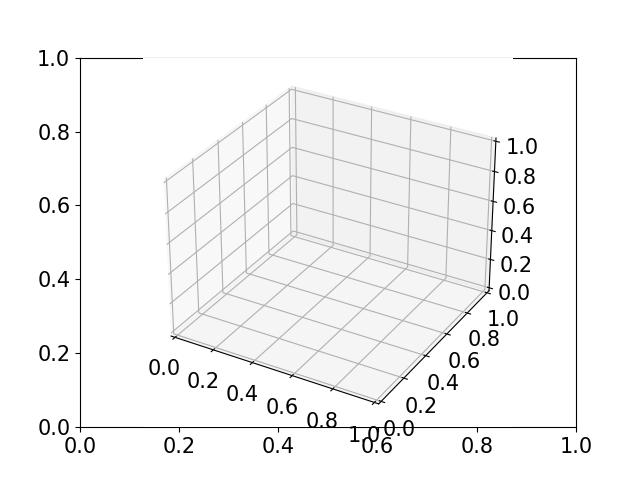

In [30]:
#Plotting the results
animate = True
save_results_img_gif = True
save_figure_pickle = False

#create coordinate arrays for plotting
x = np.linspace(0, xmax, nx)
y = np.linspace(0, ymax, ny)
xs, ys = np.meshgrid(x, y)

fignum +=1
fig = plt.figure(fignum)
ax = plt.axes(projection='3d')

if animate:
    #3d animation of the results
    num_steps = len(tkeep)
    def update_surface(num):
        ax.clear() # remove last iteration of plot 
        #labels
        ax.set_xlabel(r'$x (\mu m$)',fontsize=fontsize)
        ax.set_ylabel(r'$y (\mu m$)',fontsize=fontsize)
        ax.set_zlabel(r'$ice \ layers$',fontsize=fontsize)
        #limits
        ax.set_zlim3d(-layermax_2D, layermax_2D)
        ax.set_ylim(0, ymax)
        ax.set_xlim(0, xmax)
        #surface plot
        xmid = round(np.shape(Nice)[0]/2)
        #ax.plot_surface(X=xs[xmid:], Y=ys[xmid:], Z=Nicekeep[num][xmid:][:], cmap='viridis')#, vmin=0, vmax=200) #plot half of the surface of the ice  
        #ax.plot_surface(X=xs[xmid:], Y=ys[xmid:], Z=Ntotkeep[num][xmid:][:], cmap='YlGnBu_r')#, vmin=0, vmax=200) #plot half the surface of the QLL
        ax.plot_surface(X=xs, Y=ys, Z=Nicekeep[num], cmap='viridis')#, vmin=0, vmax=200) #plot the surface of the ice 
        #ax.plot_surface(X=xs, Y=ys, Z=Ntotkeep[num], cmap='bone')#, vmin=0, vmax=200)#plot the surface of the QLL
        # plot = ax.plot_surface(X=xs, Y=ys, Z=Nicekeep[num], cmap='viridis')#, vmin=0, vmax=200) #plot the surface of the ice  
        # plot = ax.plot_surface(X=xs, Y=ys, Z=Ntotkeep[num], cmap='YlGnBu_r')#, vmin=0, vmax=200)#plot the surface of the QLL
        # return plot
        pass
    
    proport_interval = int(50*30/layermax_2D)#targeting speeds similar to 50ms interval at 30 layers, if more layers it will speed it up to keep the animation at the same visual speed

    ani = animation.FuncAnimation(fig, update_surface, num_steps, interval=50, blit=False, cache_frame_data=False, repeat = True)
    
else:
    #3d plot of the results
    #surface plot
    plot = ax.plot_surface(X=xs, Y=ys, Z=Nice, cmap='viridis')#, vmin=0, vmax=200)
    plot = ax.plot_surface(X=xs, Y=ys, Z=Ntot, cmap='viridis')#, vmin=0, vmax=200)
    
    #countour plot
    # levels = np.arange(-6,12,0.25)
    # ax.contour(x,y, Nice, extent=(0, 2, 0, 2), cmap='YlGnBu_r', vmin=0, vmax=200, zorder=1, levels=levels)
plt.show()

#Save the results
filename = '3d_model_results_'+str(layermax_2D)+'_layers'
if save_results_img_gif and animate:
    #File writer for saving animations as gifs
    writergif = animation.PillowWriter(fps=480,bitrate=1800)
    ani.save(filename+'.gif',writer=writergif)
    #File writer for saving animations as mp4
    # writervideo = animation.FFMpegWriter(fps=60)
    # ani.save('3d_model.mp4', writer=writervideo)
elif save_results_img_gif and not animate:
    #Save the results as an image
    plt.savefig(filename+'.png', dpi=300)

if save_figure_pickle:
    serialized_fig = pickle.dumps(fig)
    pickle_filename = '2d_model_3d_results_fig_8-3-22.pkl'
    with open(pickle_filename, 'wb') as f:
        pickle.dump(serialized_fig, f)

In [ ]:
plt.close()